# Scale effects

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime
import statsmodels.api as sm
import zigzag
import logging
log = logging.getLogger(__name__)
import paper
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
table_scaling = pd.DataFrame()
denominators = df_prime.loc['denominator']
table_scaling['SI unit'] = df_prime.loc['SI unit'].apply(lambda x:"$"+x.replace('*',' \cdot ')+"$")
table_scaling['Prime system'] = denominators.apply(lambda x:f"${sp.latex(x)}$")
table_scaling.drop(index='-', inplace=True)

In [4]:
lambda_ = sp.symbols(r'lambda') 
scaled = denominators.apply(lambda x:x.subs([(L,L*lambda_),(U,U*sp.sqrt(lambda_),)]))
scale_factors = scaled/denominators
table_scaling['Froude scaling'] = scale_factors.apply(lambda x:f"${sp.latex(x)}$")

In [5]:
table_scaling.index.name="Physical quantity"
table = table_scaling.reset_index()
table["Physical quantity"] = table["Physical quantity"].apply(lambda x:x.replace('_',' '))
table.sort_values(by="Physical quantity")

Physical quantity         SI unit                  Prime system              Froude scaling
8                  angle           $rad$                           $1$                         $1$
12  angular acceleration       $rad/s^2$         $\frac{U^{2}}{L^{2}}$         $\frac{1}{\lambda}$
10      angular velocity         $rad/s$                 $\frac{U}{L}$  $\frac{1}{\sqrt{\lambda}}$
7                   area           $m^2$                       $L^{2}$               $\lambda^{2}$
3                density        $kg/m^3$              $\frac{\rho}{2}$                         $1$
13                 force             $N$  $\frac{L^{2} U^{2} \rho}{2}$               $\lambda^{3}$
6              frequency           $1/s$                 $\frac{U}{L}$  $\frac{1}{\sqrt{\lambda}}$
4         inertia moment  $kg \cdot m^2$        $\frac{L^{5} \rho}{2}$               $\lambda^{5}$
0                 length             $m$                           $L$                   $\lambda$
11   linear acceleration         $m/s^2$             $\frac{U^{2}}{L}$                         $1$
9        linear velocity           $m/s$                           $U$            $\sqrt{\lambda}$
2                   mass            $kg$        $\frac{L^{3} \rho}{2}$               $\lambda^{3}$
14                moment            $Nm$  $\frac{L^{3} U^{2} \rho}{2}$               $\lambda^{4}$
5                   time             $s$                 $\frac{L}{U}$            $\sqrt{\lambda}$
1                 volume           $m^3$                       $L^{3}$               $\lambda^{3}$

In [6]:
table.to_csv(paper.file_path_with_nb_ref("scalings.csv", directory='tables'), index=False)

In [7]:
%reload_kedro
ship='7m'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.tests")
#time_series = catalog.load(f"{ship}.tests_ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
ship_data = catalog.load(f"{ship}.ship_data")
units = catalog.load(f"{ship}.units")

[08/28/23 09:40:25] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=209194;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=969598;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/28/23 09:40:37] INFO     Kedro project phd                                                      ]8;id=721450;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=273843;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=723379;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=371275;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=946326;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=739079;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=549760;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=42376;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=531498;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689468;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=533398;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=236439;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=681979;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=505368;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=640327;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=313863;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [8]:
%reload_kedro
ship='wPCC'
time_series_wPCC = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
time_series_meta_data_wPCC = catalog.load(f"{ ship }.time_series_meta_data")
ship_data_wPCC = catalog.load(f"{ship}.ship_data")
model_loaders_MDL = catalog.load(f"{ship}.models")

                    INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=297932;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=808176;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/28/23 09:40:49] INFO     Kedro project phd                                                      ]8;id=961979;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=58629;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=368827;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=528164;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=5338;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=669704;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=107570;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=205712;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=990619;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=96667;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=17643;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=869234;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=143291;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=953849;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [9]:
def preprocess(data):
    data['-delta_deg'] = -np.rad2deg(data['delta'])
    psi0 = data.iloc[0]['psi'].copy()
    data['psi']-=psi0
    data['x0']-=data['x0'].iloc[0]
    data['y0']-=data['y0'].iloc[0]
    x0 = data['x0'].copy()
    y0 = data['y0'].copy()
    data['x0'] = x0*np.cos(psi0) + y0*np.sin(psi0)
    data['y0'] = -x0*np.sin(psi0) + y0*np.cos(psi0)
    data['psi_deg'] = np.rad2deg(smallest_signed_angle(data['psi']))

## Field study data

In [10]:
field_data = {}

id=6
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data

id=8
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data



## Model test data

In [11]:
id = 22764
data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
data_wPCC=data_wPCC.iloc[i:].copy()
data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
data_wPCC.index-=data_wPCC.index[0]

data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
data_wPCC['-delta_deg'] = -np.rad2deg(data_wPCC['delta'])
data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
data_wPCC['psi_deg'] = np.rad2deg(data_wPCC['psi'])
data_wPCC["rev"] = data_wPCC[["Prop/SB/Rpm", "Prop/PS/Rpm"]].mean(axis=1)

In [12]:
model_MDL = model_loaders_MDL['vmm_martins_simple_thrust.MDL_inverse_dynamics']()
model = model_loaders['vmm_martins_simple_thrust.MDL_inverse_dynamics']()

## Scaling model test data to 7m

In [13]:
scaling=model_MDL.ship_parameters['scale_factor']/model.ship_parameters['scale_factor']
scaling

1.3733333333333335

In [14]:
data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
data_wPCC_7m.index*=np.sqrt(scaling)

In [15]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

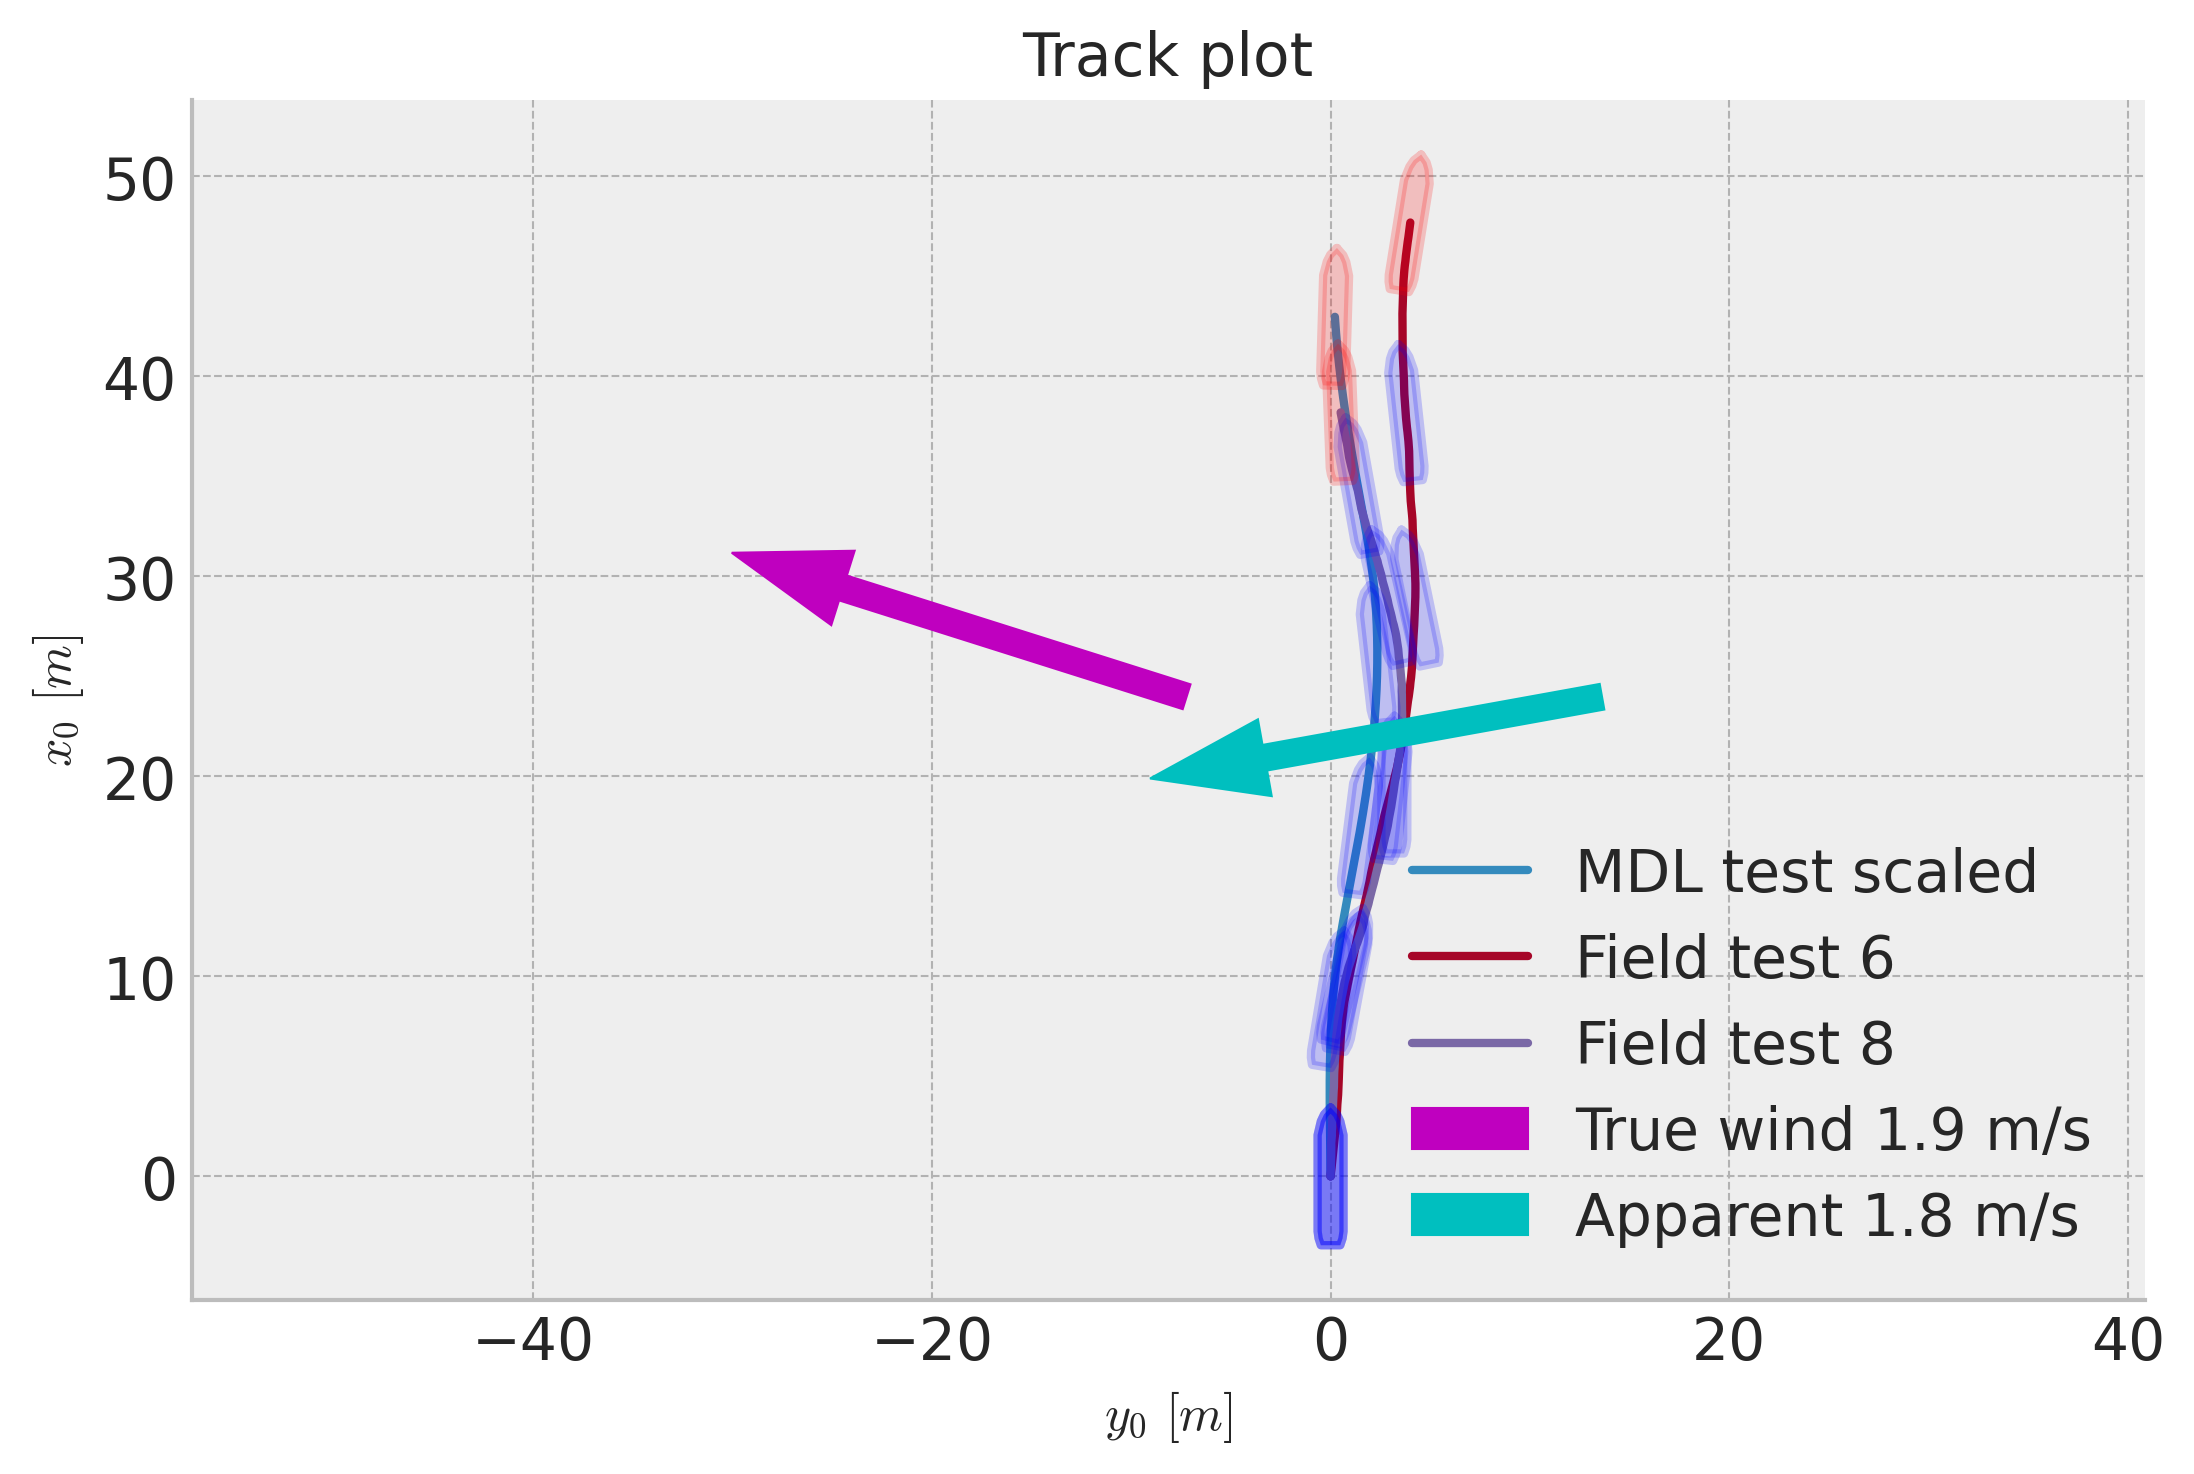

In [16]:
dataframes = {
    'MDL test scaled':data_wPCC_7m.loc[0:data.index[-1]],
}
dataframes.update(field_data)
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

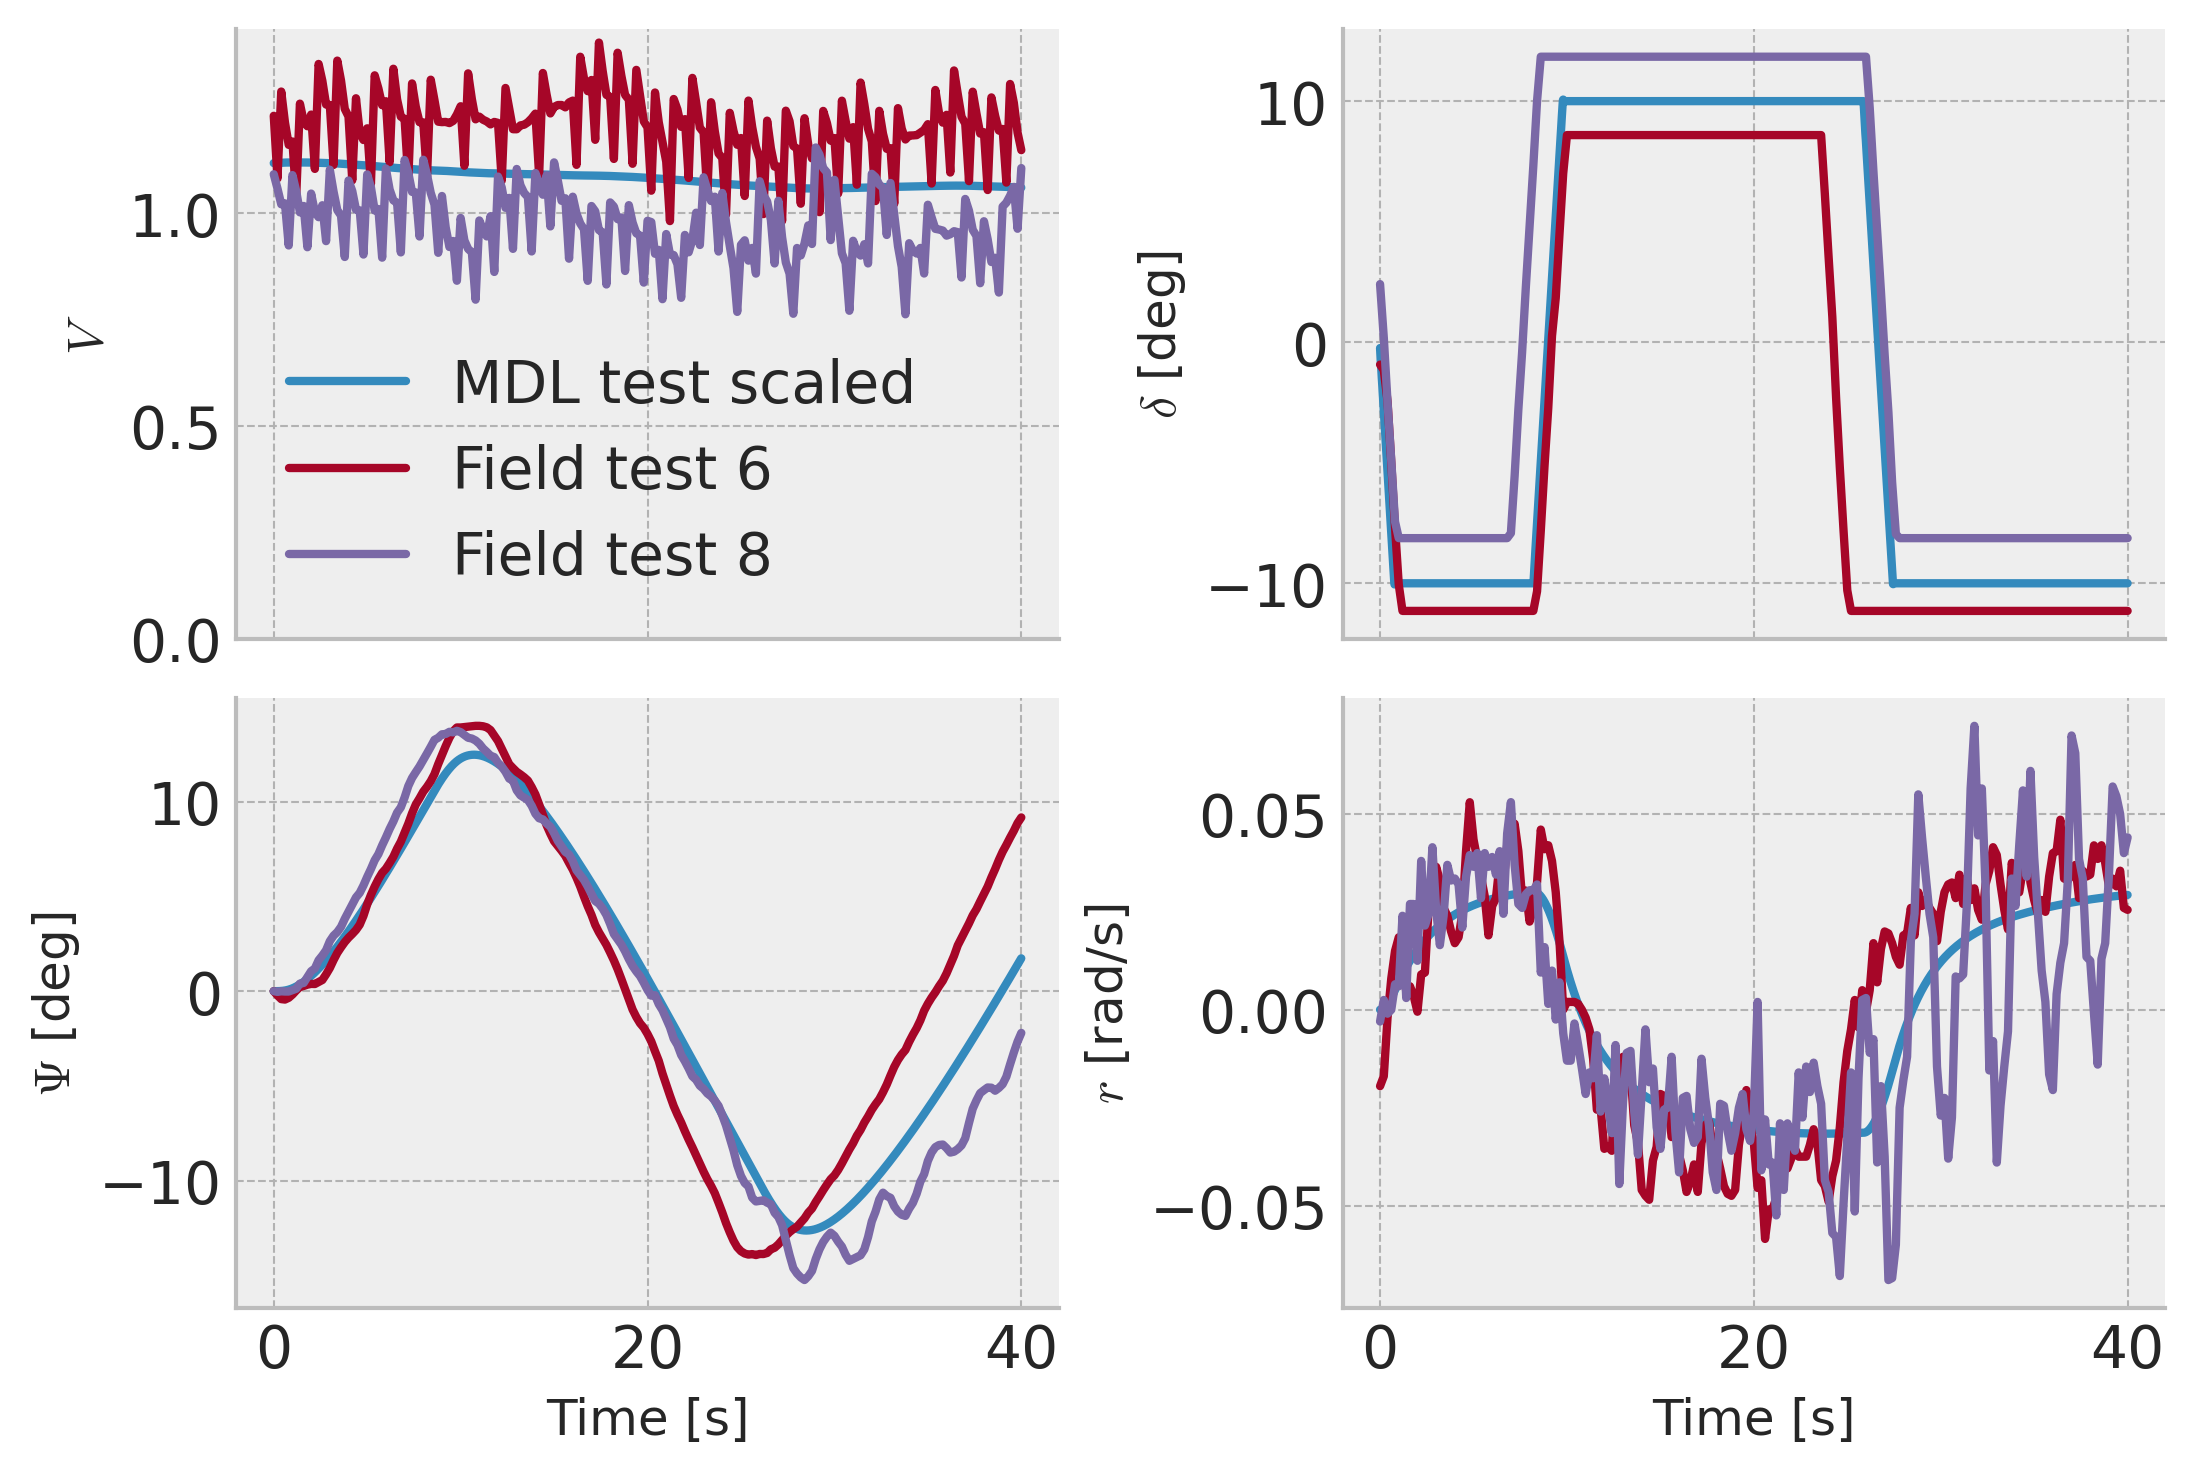

In [17]:
fig = plot(dataframes, keys=['psi','V','r','delta'], units=units, symbols=symbols_dict);
fig.savefig(paper.file_path_with_nb_ref("MDL_test_scaled.pdf"))

<Axes: >

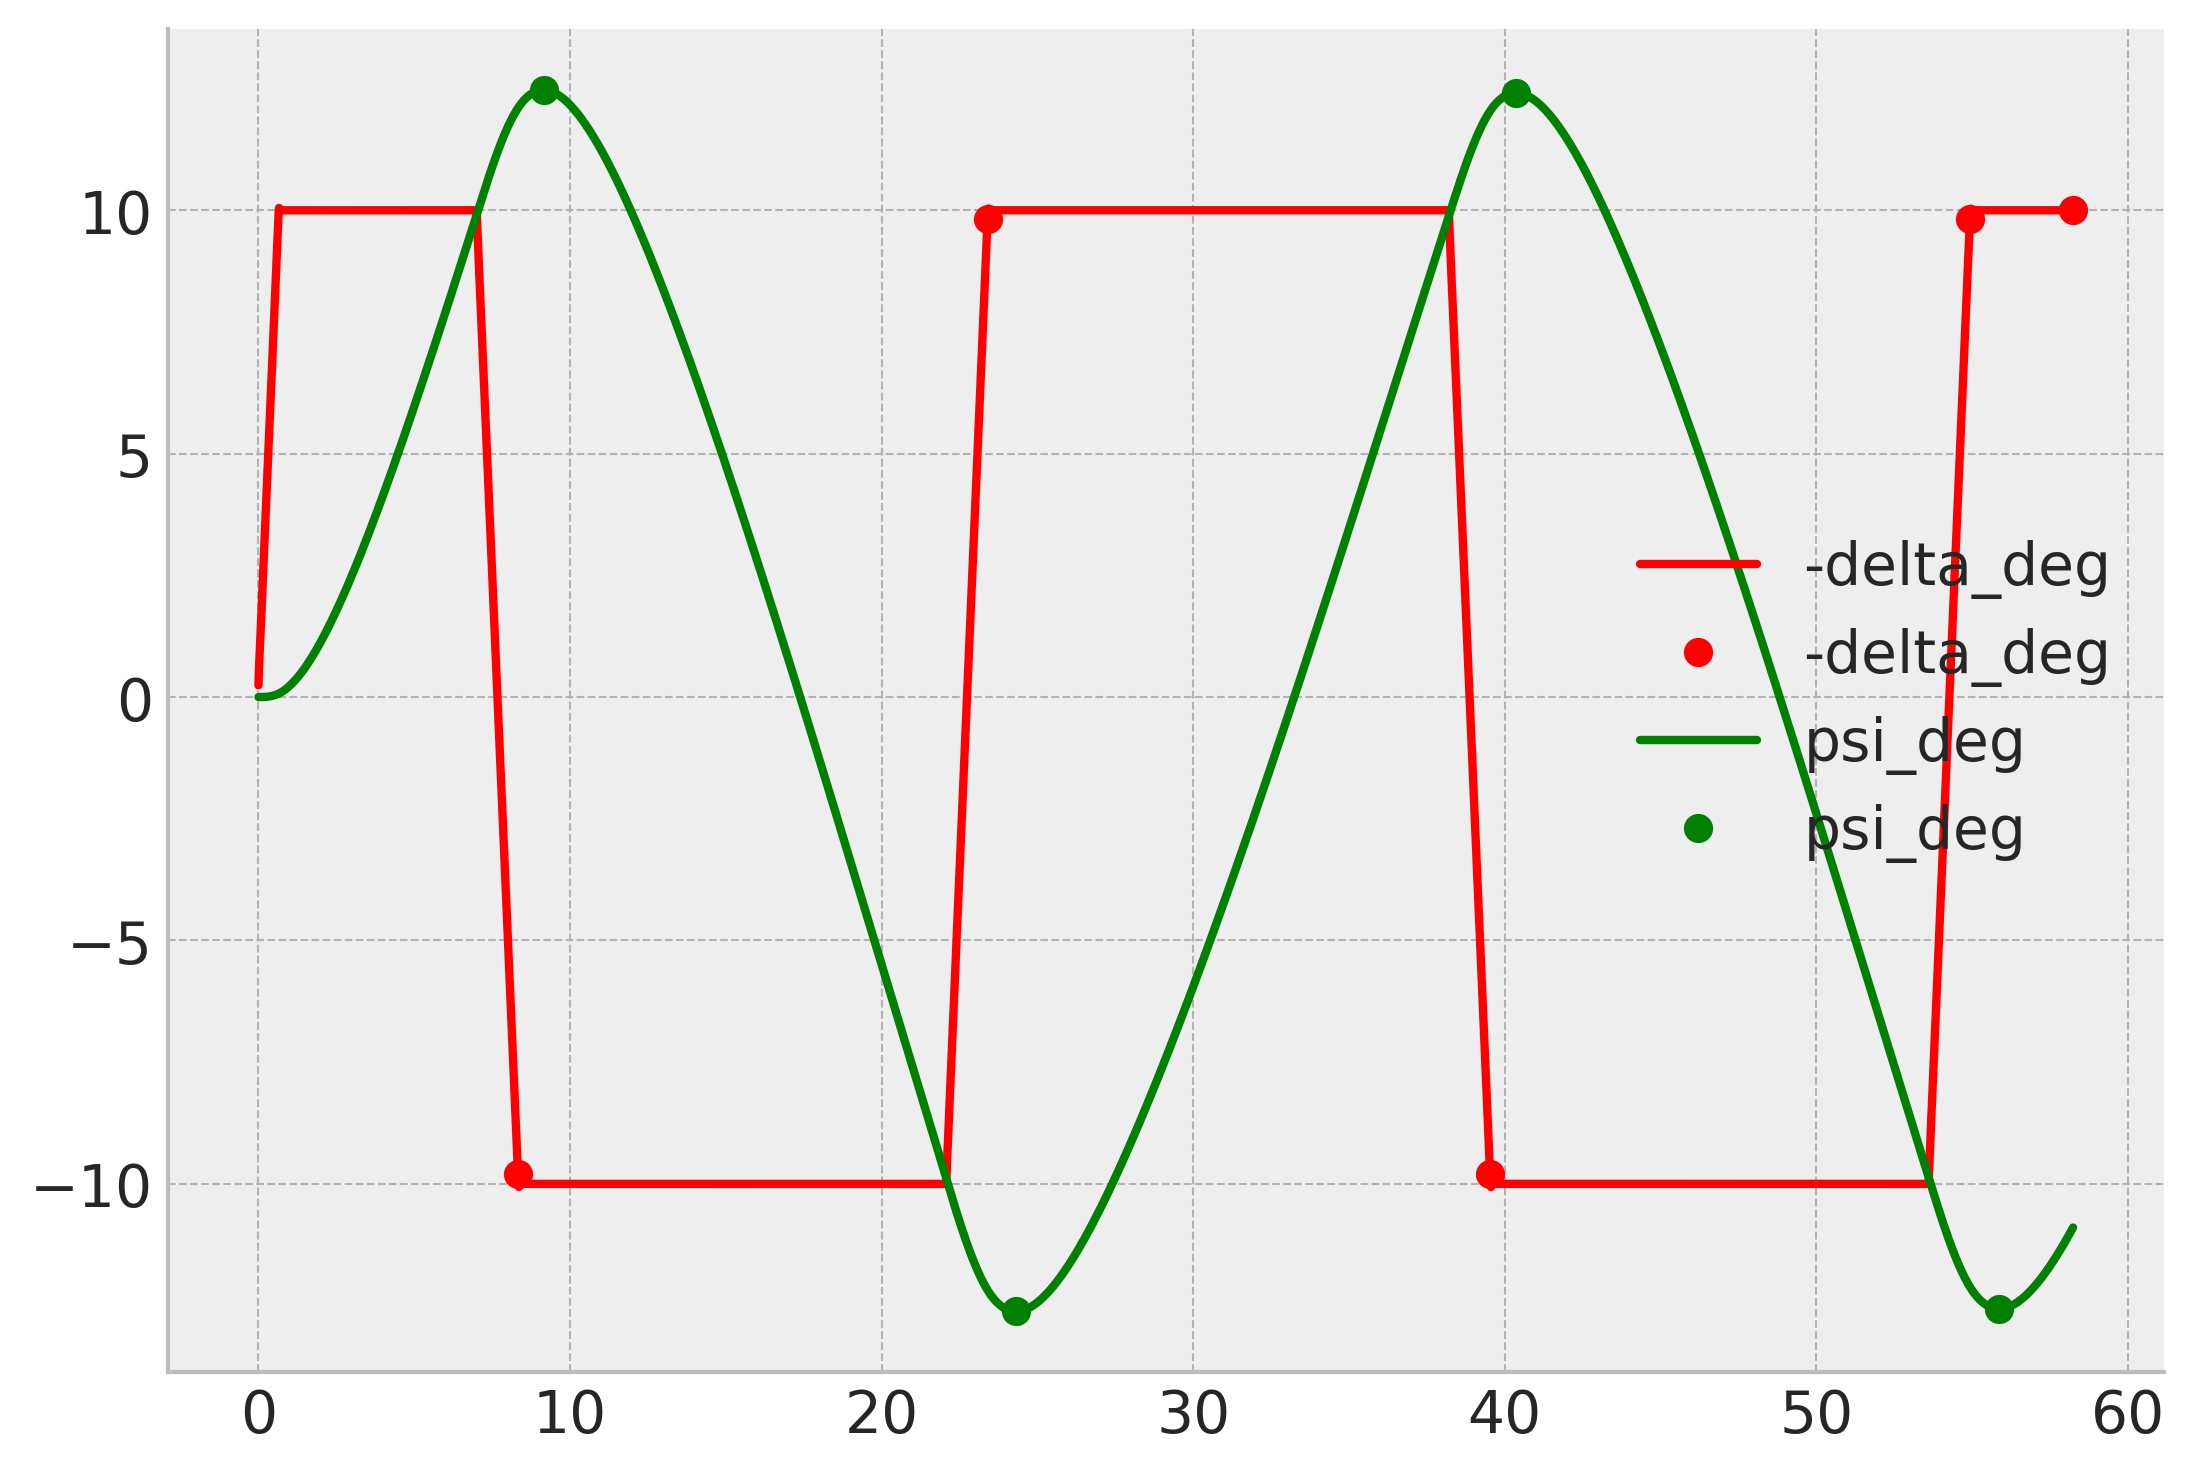

In [18]:
corners = zigzag._get_corners(angle=np.deg2rad(10), df=data_wPCC)
maximums = zigzag._get_maximums(df=data_wPCC, corners=corners)

fig,ax=plt.subplots()
data_wPCC.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

data_wPCC.plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [19]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=data_wPCC_7m)

10.722821    2.468470
28.488720    2.618598
47.297604    2.407741
65.473665    2.564913
Name: psi, dtype: float64

<Axes: xlabel='time(us)'>

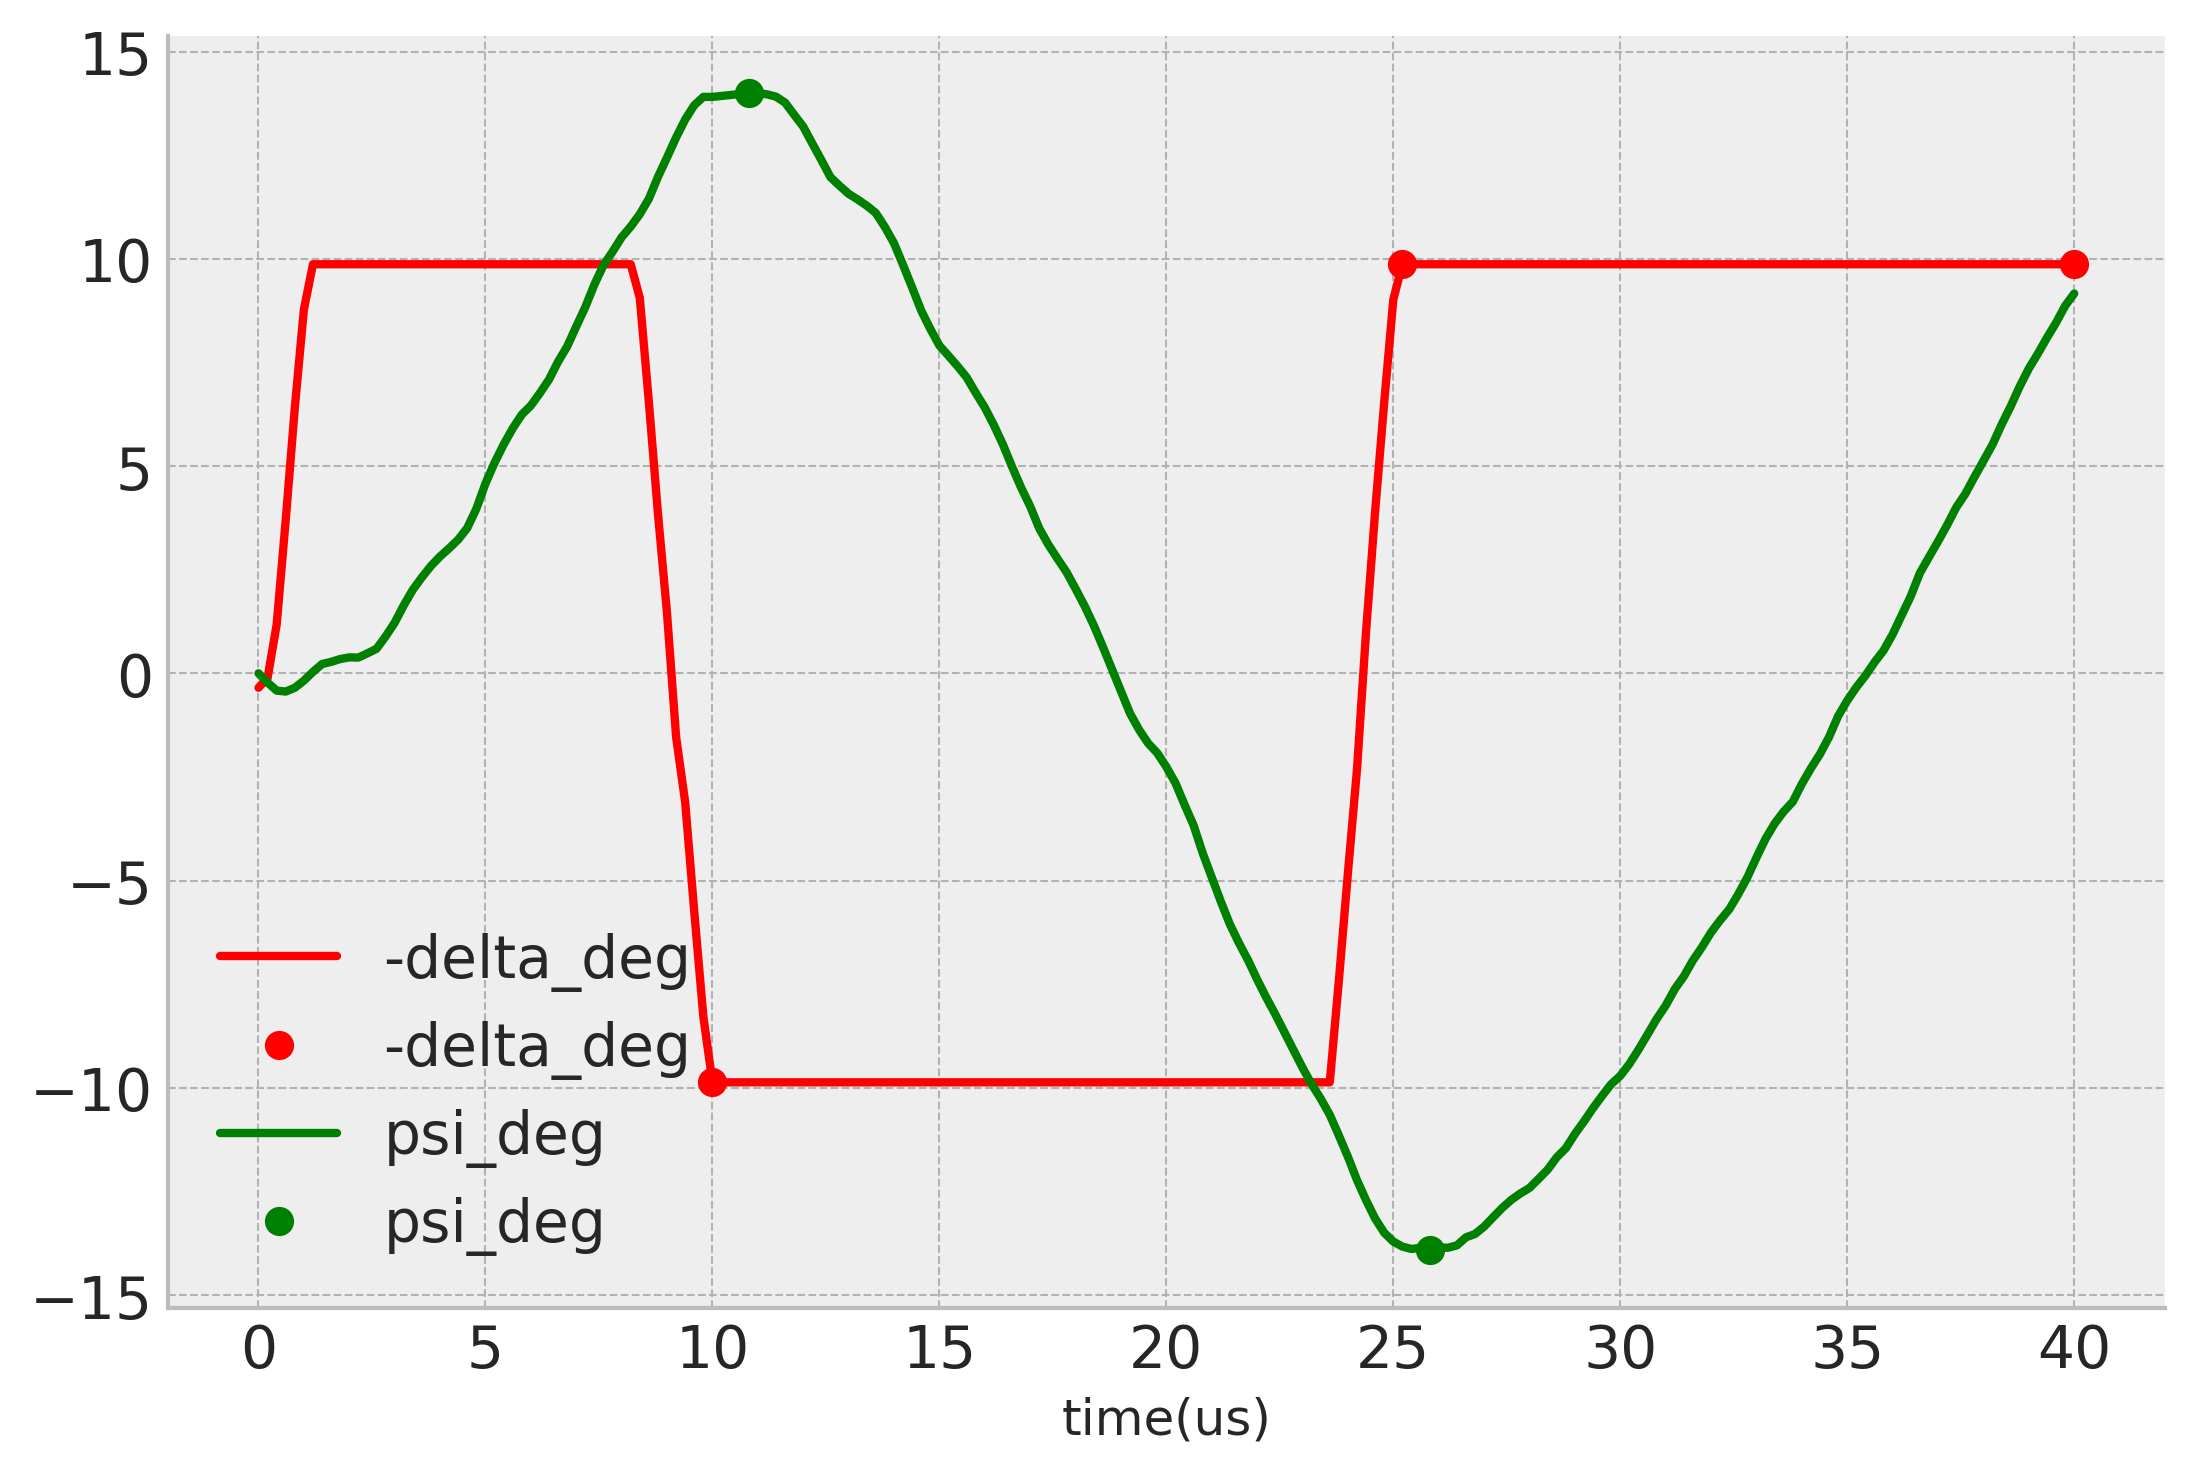

In [20]:
id = "Field test 6"

df = field_data[id].copy()
df['psi_deg'] = np.rad2deg(df['psi'])
df['delta']-=(df['delta'].max() + df['delta'].min())/2
df['-delta_deg']=-np.rad2deg(df['delta'])

corners = zigzag._get_corners(angle=np.deg2rad(10), df=df)
maximums = zigzag._get_maximums(df=df, corners=corners)

fig,ax=plt.subplots()
df.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

field_data[id].plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [21]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=df)

time(us)
10.799802    3.990788
25.799617    3.911415
Name: psi, dtype: float64

In [22]:
def load_MDL(id):
    data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
    #i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
    #data_wPCC=data_wPCC.iloc[i:].copy()
    data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
    data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
    data_wPCC.index-=data_wPCC.index[0]
    
    data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
    
    data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
    
    ## scaling:
    data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
    data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
    data_wPCC_7m.index*=np.sqrt(scaling)
    
    data_wPCC_7m['psi_deg'] = np.rad2deg(data_wPCC_7m['psi'])
    data_wPCC_7m['-delta_deg'] = -np.rad2deg(data_wPCC_7m['delta'])
    
    
    return data_wPCC_7m

In [23]:
def evaluate(df,angle):
    overshoots = zigzag.get_overshoots(angle=np.deg2rad(angle), df=df)
    
    results = pd.Series(name=id)
    for i, overshoot in enumerate(overshoots.values):
        results[f"overshoot_{i+1}"] = overshoot
        
    for n in range(i-1):
        results[f"period_{n+1}"] = overshoots.index[n+1] - overshoots.index[n]
        
    results['V'] = df['V'].iloc[0:10].mean()
    
    return results
    

In [24]:
_ = []
mask = time_series_meta_data_wPCC['test_type'] == 'zigzag'
time_series_selection = time_series_meta_data_wPCC.loc[mask].copy()
time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_MDL(id)
    except:
        continue
        
    angle = meta_data['angle1']
    results = evaluate(df=df, angle=angle)   
    _.append(results)
    
evaluations_MDL = pd.DataFrame(_)
evaluations_MDL = pd.merge(left=evaluations_MDL, right=time_series_meta_data_wPCC, left_index=True, right_index=True, how='left')

In [25]:
evaluations_MDL

overshoot_1  overshoot_2  overshoot_3  overshoot_4   period_1   period_2         V  overshoot_5  period_3  project_number  series_number  run_number  test_number model_number   ship_name  loading_condition_id  ascii_name  ship_speed     comment  file_path_ascii  file_path_ascii_temp  file_path_log                                     file_path_hdf5        date test_type facility  angle1  angle2  scale_factor    name      lcg        kg        gm  CW        TF        TA  BWL       KXX       KZZ  BTT1  CP    Volume        A0  RH       lpp      beam  ABULB  BKX  TWIN  DCLR  VDES  RHBL  ASKEG  PD  ARH  CFP  AIX  PDTDES  RTYPE  SFP  BKL  BKB  PROT   D  LSKEG  RR  XSKEG  NDES  AR  BR  BRA  IRUD  PTYPE  XRUD  AI  HSKEG  RSKEG  LOA  ship_type_id  xm  ym     zm  description
22770     2.513903     2.446363     2.447115     2.288891  17.625274  18.000280  1.106733          NaN       NaN        40199079              5           6            2   M5139-02-A  M5139-02-A                   167         NaN     0.96177  ZZ 10/10PS              NaN                   NaN            NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...  2020-09-24    zigzag      MDL    10.0    10.0          41.2  Design -0.24432  0.438908  0.136092 NaN  0.206311  0.206311  NaN  0.331311  1.253641   NaN NaN  0.441027  0.722775 NaN  5.014563  0.946602    NaN  NaN   NaN   NaN   NaN   NaN    NaN NaN  NaN  NaN  NaN     NaN    NaN  NaN  NaN  NaN   NaN NaN    NaN NaN    NaN   NaN NaN NaN  NaN   NaN    NaN   NaN NaN    NaN    NaN  NaN           NaN   0   0 -0.214  ZigZag10/10
22769     2.535368     2.467289    -1.253929          NaN  17.695577        NaN  1.110152          NaN       NaN        40199079              5           5            2   M5139-02-A  M5139-02-A                   167         NaN     0.96177  ZZ 10/10PS              NaN                   NaN            NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...  2020-09-24    zigzag      MDL    10.0    10.0          41.2  Design -0.24432  0.438908  0.136092 NaN  0.206311  0.206311  NaN  0.331311  1.253641   NaN NaN  0.441027  0.722775 NaN  5.014563  0.946602    NaN  NaN   NaN   NaN   NaN   NaN    NaN NaN  NaN  NaN  NaN     NaN    NaN  NaN  NaN  NaN   NaN NaN    NaN NaN    NaN   NaN NaN NaN  NaN   NaN    NaN   NaN NaN    NaN    NaN  NaN           NaN   0   0 -0.214  ZigZag10/10
22771     7.263554     5.621849     6.071580    -3.090032  20.097969  21.586273  1.113647     4.941169  6.996203        40199079              5           1            3   M5139-02-A  M5139-02-A                   167         NaN     0.96177  ZZ 20/20SB              NaN                   NaN            NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...  2020-09-24    zigzag      MDL    20.0    20.0          41.2  Design -0.24432  0.438908  0.136092 NaN  0.206311  0.206311  NaN  0.331311  1.253641   NaN NaN  0.441027  0.722775 NaN  5.014563  0.946602    NaN  NaN   NaN   NaN   NaN   NaN    NaN NaN  NaN  NaN  NaN     NaN    NaN  NaN  NaN  NaN   NaN NaN    NaN NaN    NaN   NaN NaN NaN  NaN   NaN    NaN   NaN NaN    NaN    NaN  NaN           NaN   0   0 -0.214  ZigZag20/20
22773     7.435742     5.401102     6.298248     5.020544  20.402659  21.152671  1.101385          NaN       NaN        40199079              5           1            4   M5139-02-A  M5139-02-A                   167         NaN     0.96177  ZZ 20/20PS              NaN                   NaN            NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...  2020-09-25    zigzag      MDL    20.0    20.0          41.2  Design -0.24432  0.438908  0.136092 NaN  0.206311  0.206311  NaN  0.331311  1.253641   NaN NaN  0.441027  0.722775 NaN  5.014563  0.946602    NaN  NaN   NaN   NaN   NaN   NaN    NaN NaN  NaN  NaN  NaN     NaN    NaN  NaN  NaN  NaN   NaN NaN    NaN NaN    NaN   NaN NaN NaN  NaN   NaN    NaN   NaN NaN    NaN    NaN  NaN           NaN   0   0 -0.214  ZigZag20/20
22772     7.375330     5.793146     5.911041     5.270874  20.320624  21.351890  1.111596          NaN

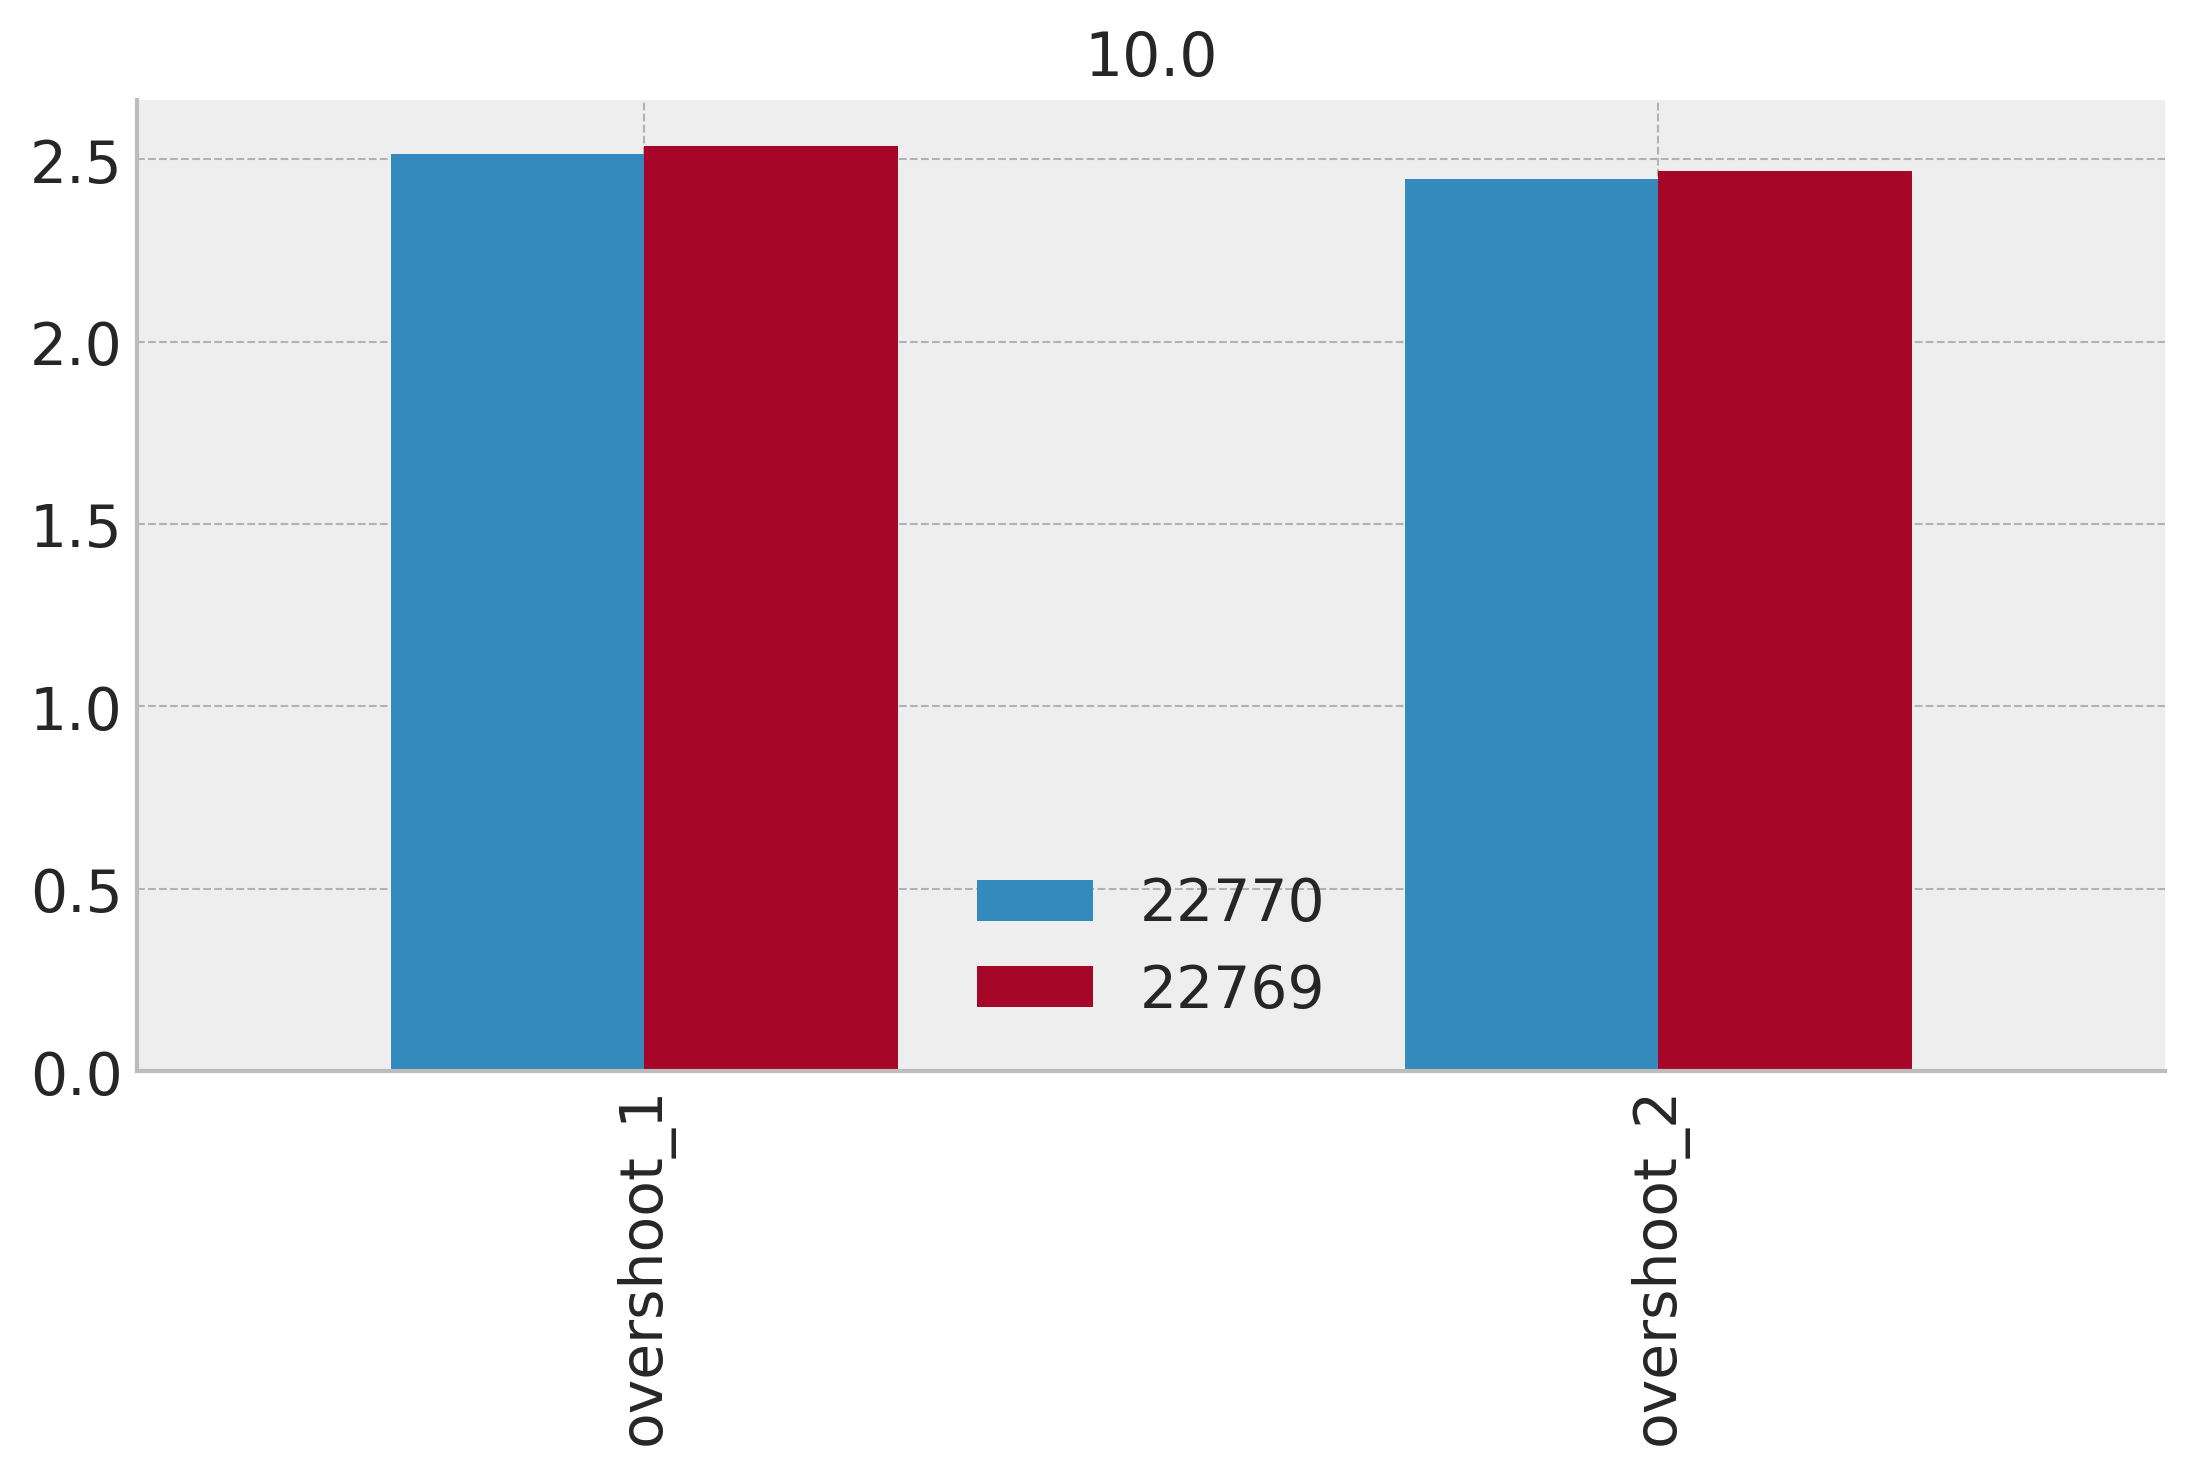

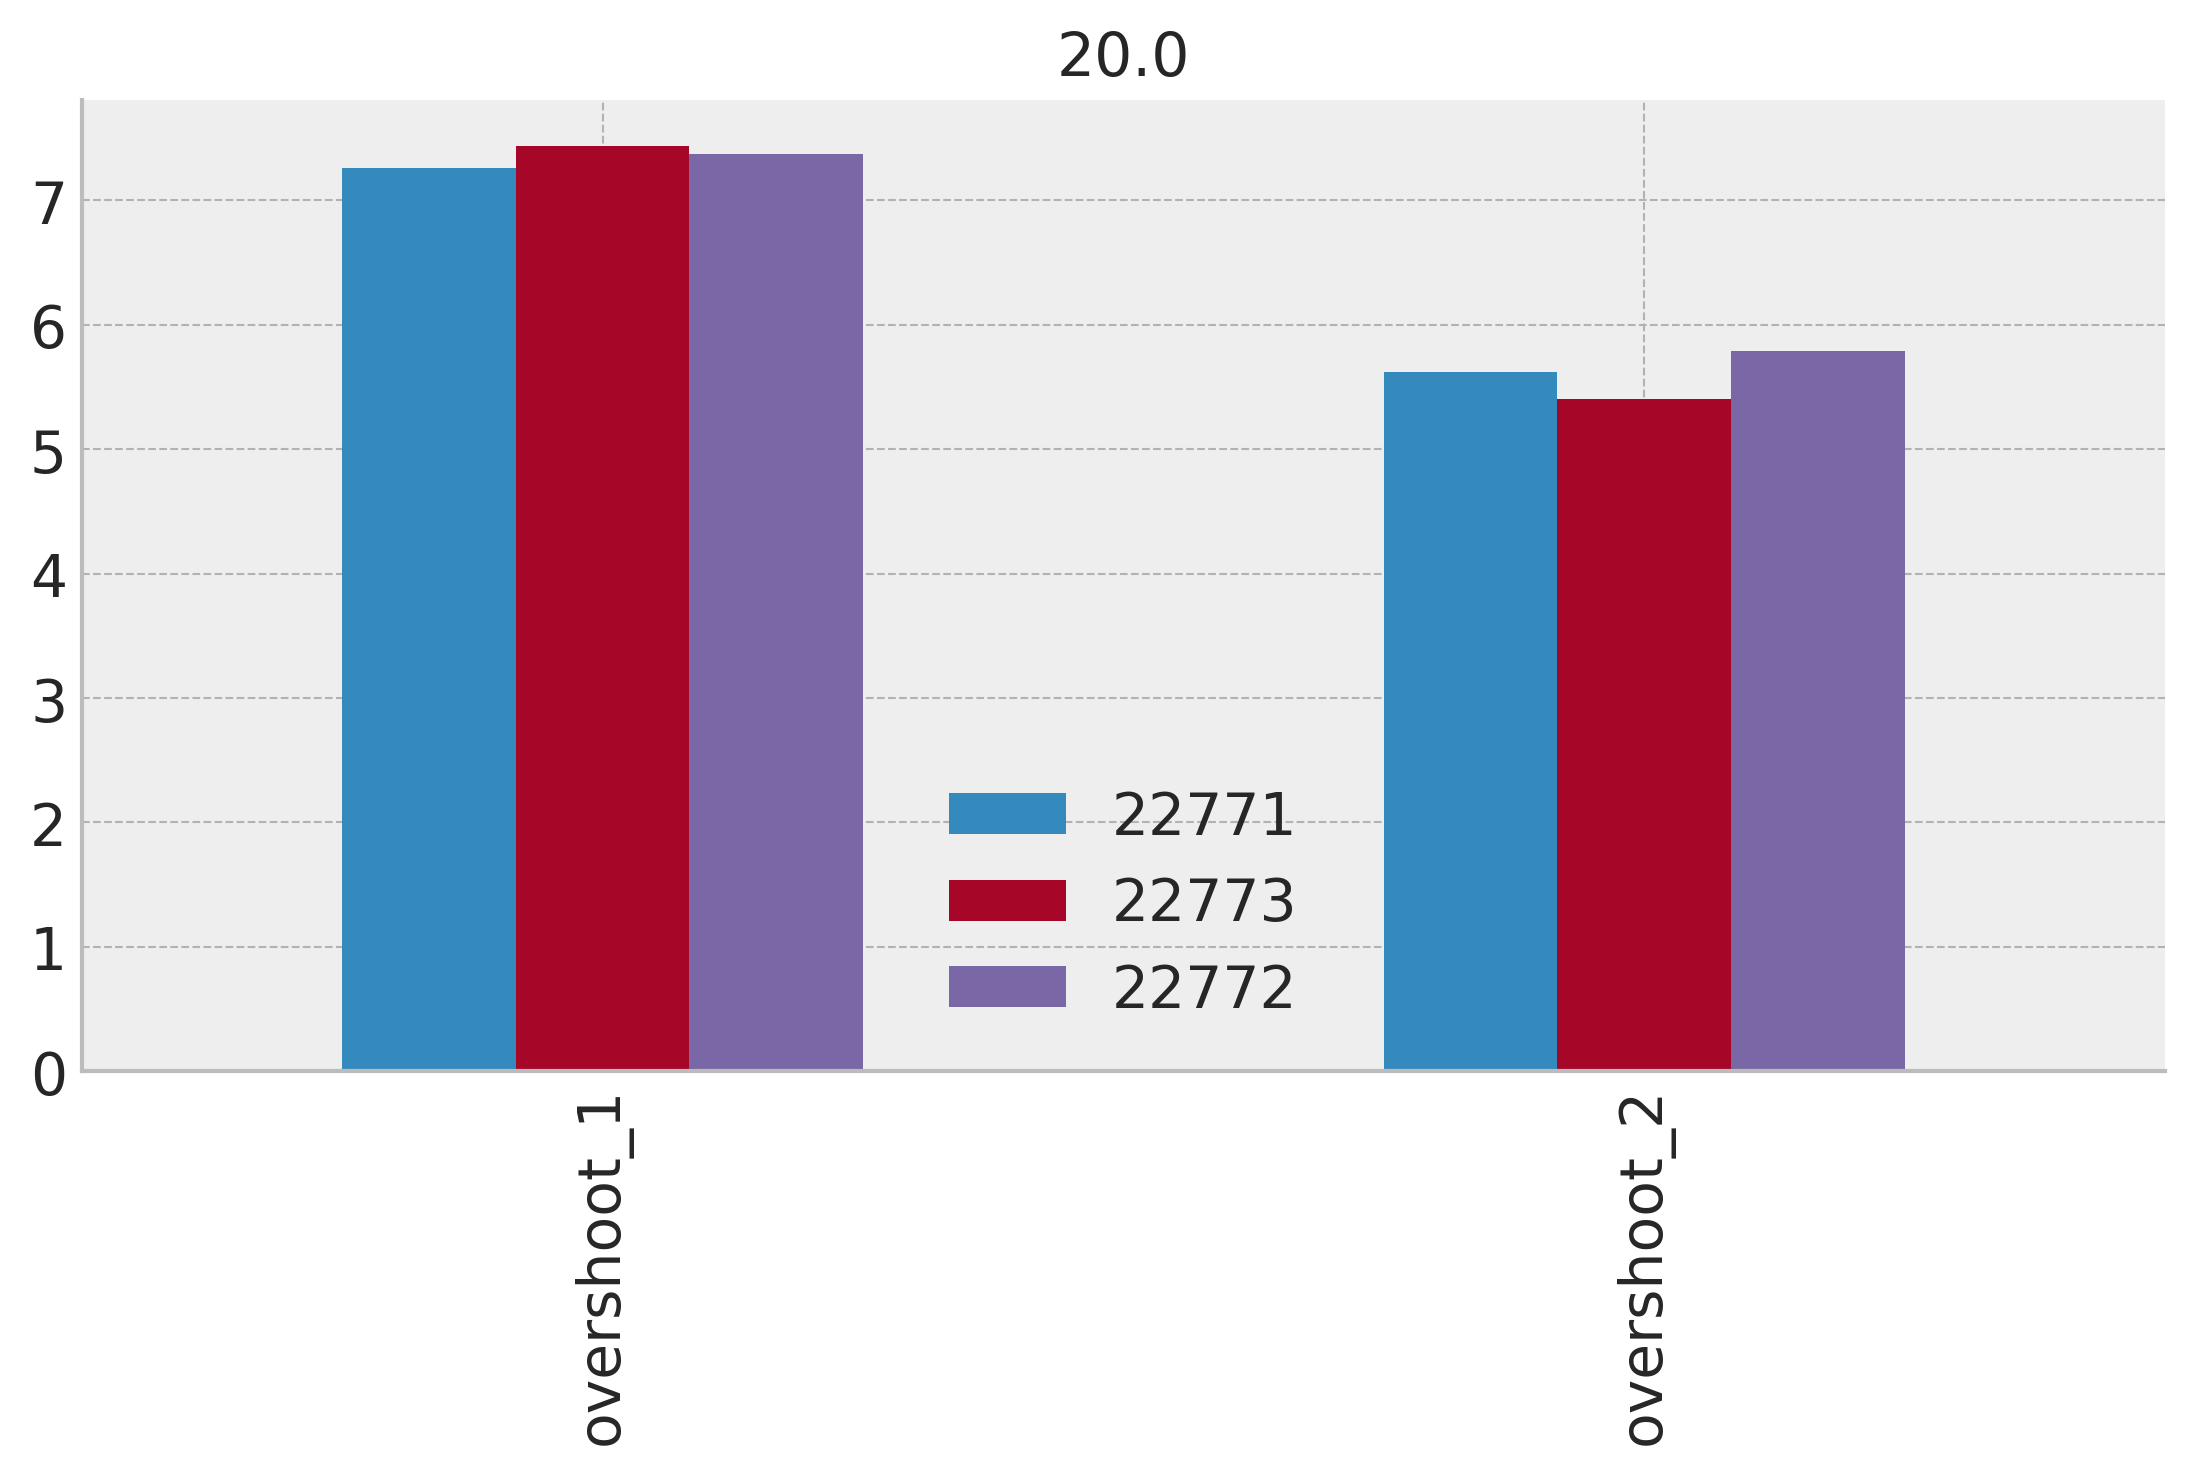

In [26]:
for angle, group in evaluations_MDL.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

In [27]:
time_series_ek_smooth = catalog.load(f"7m.tests_ek_smooth")

[08/28/23 09:40:56] INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataSet)...     ]8;id=538878;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=962666;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [28]:
def load_field_data(id):
    data = time_series_ek_smooth[str(id)]()
    preprocess(data)
    return data

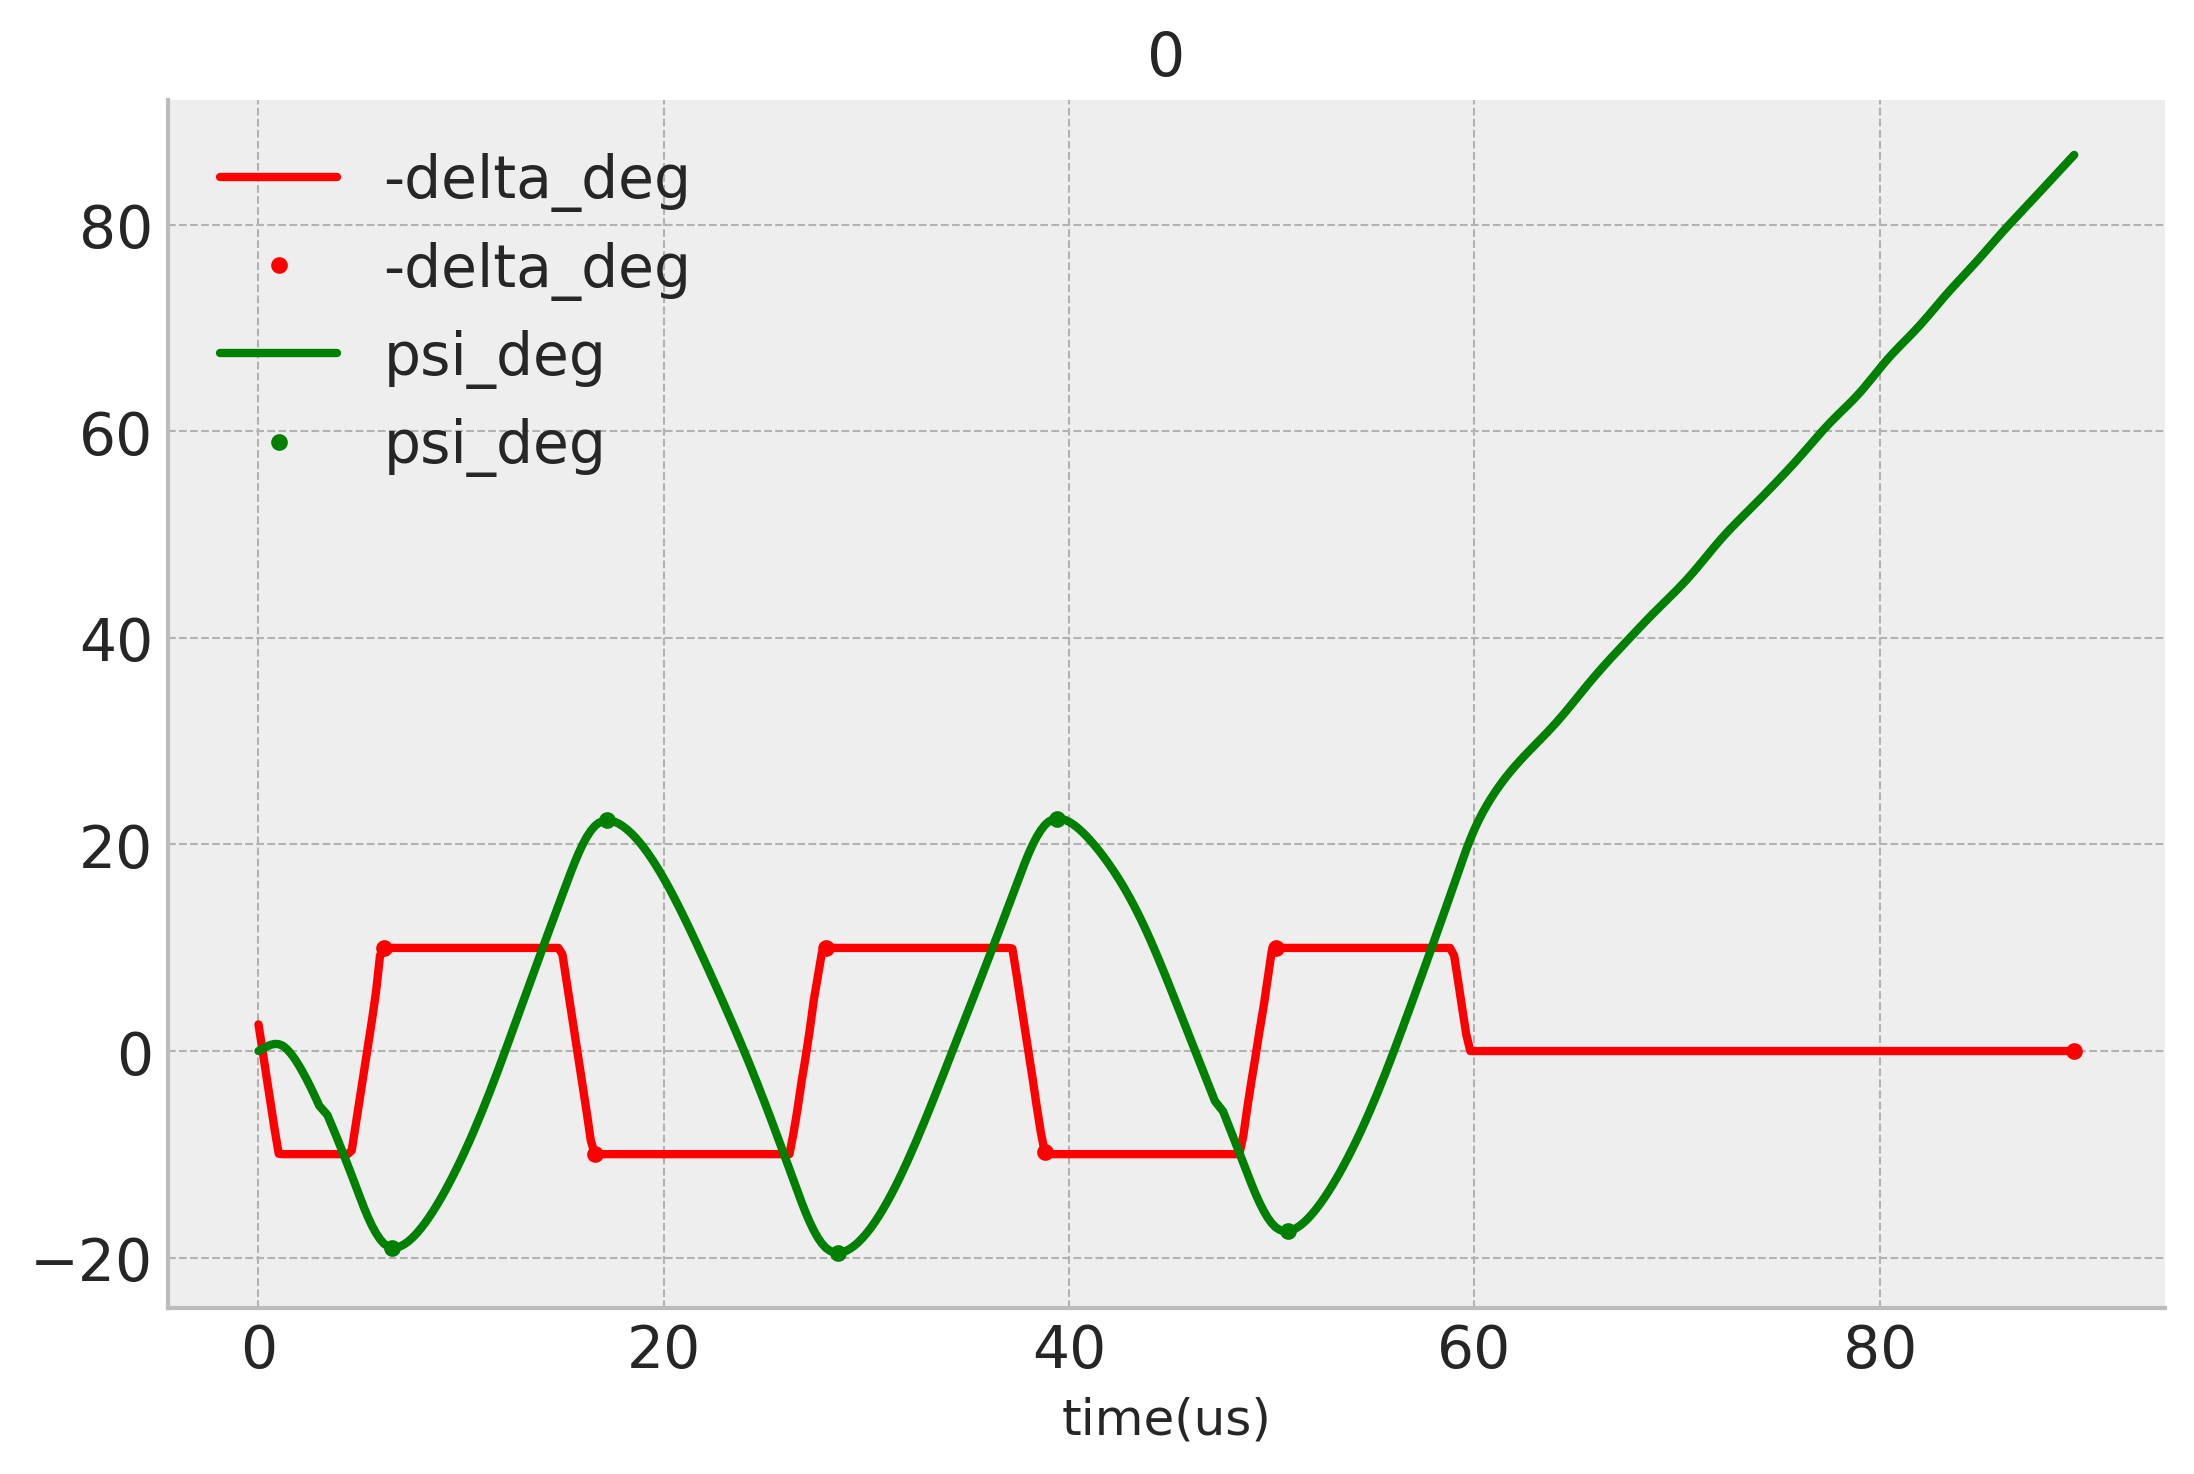

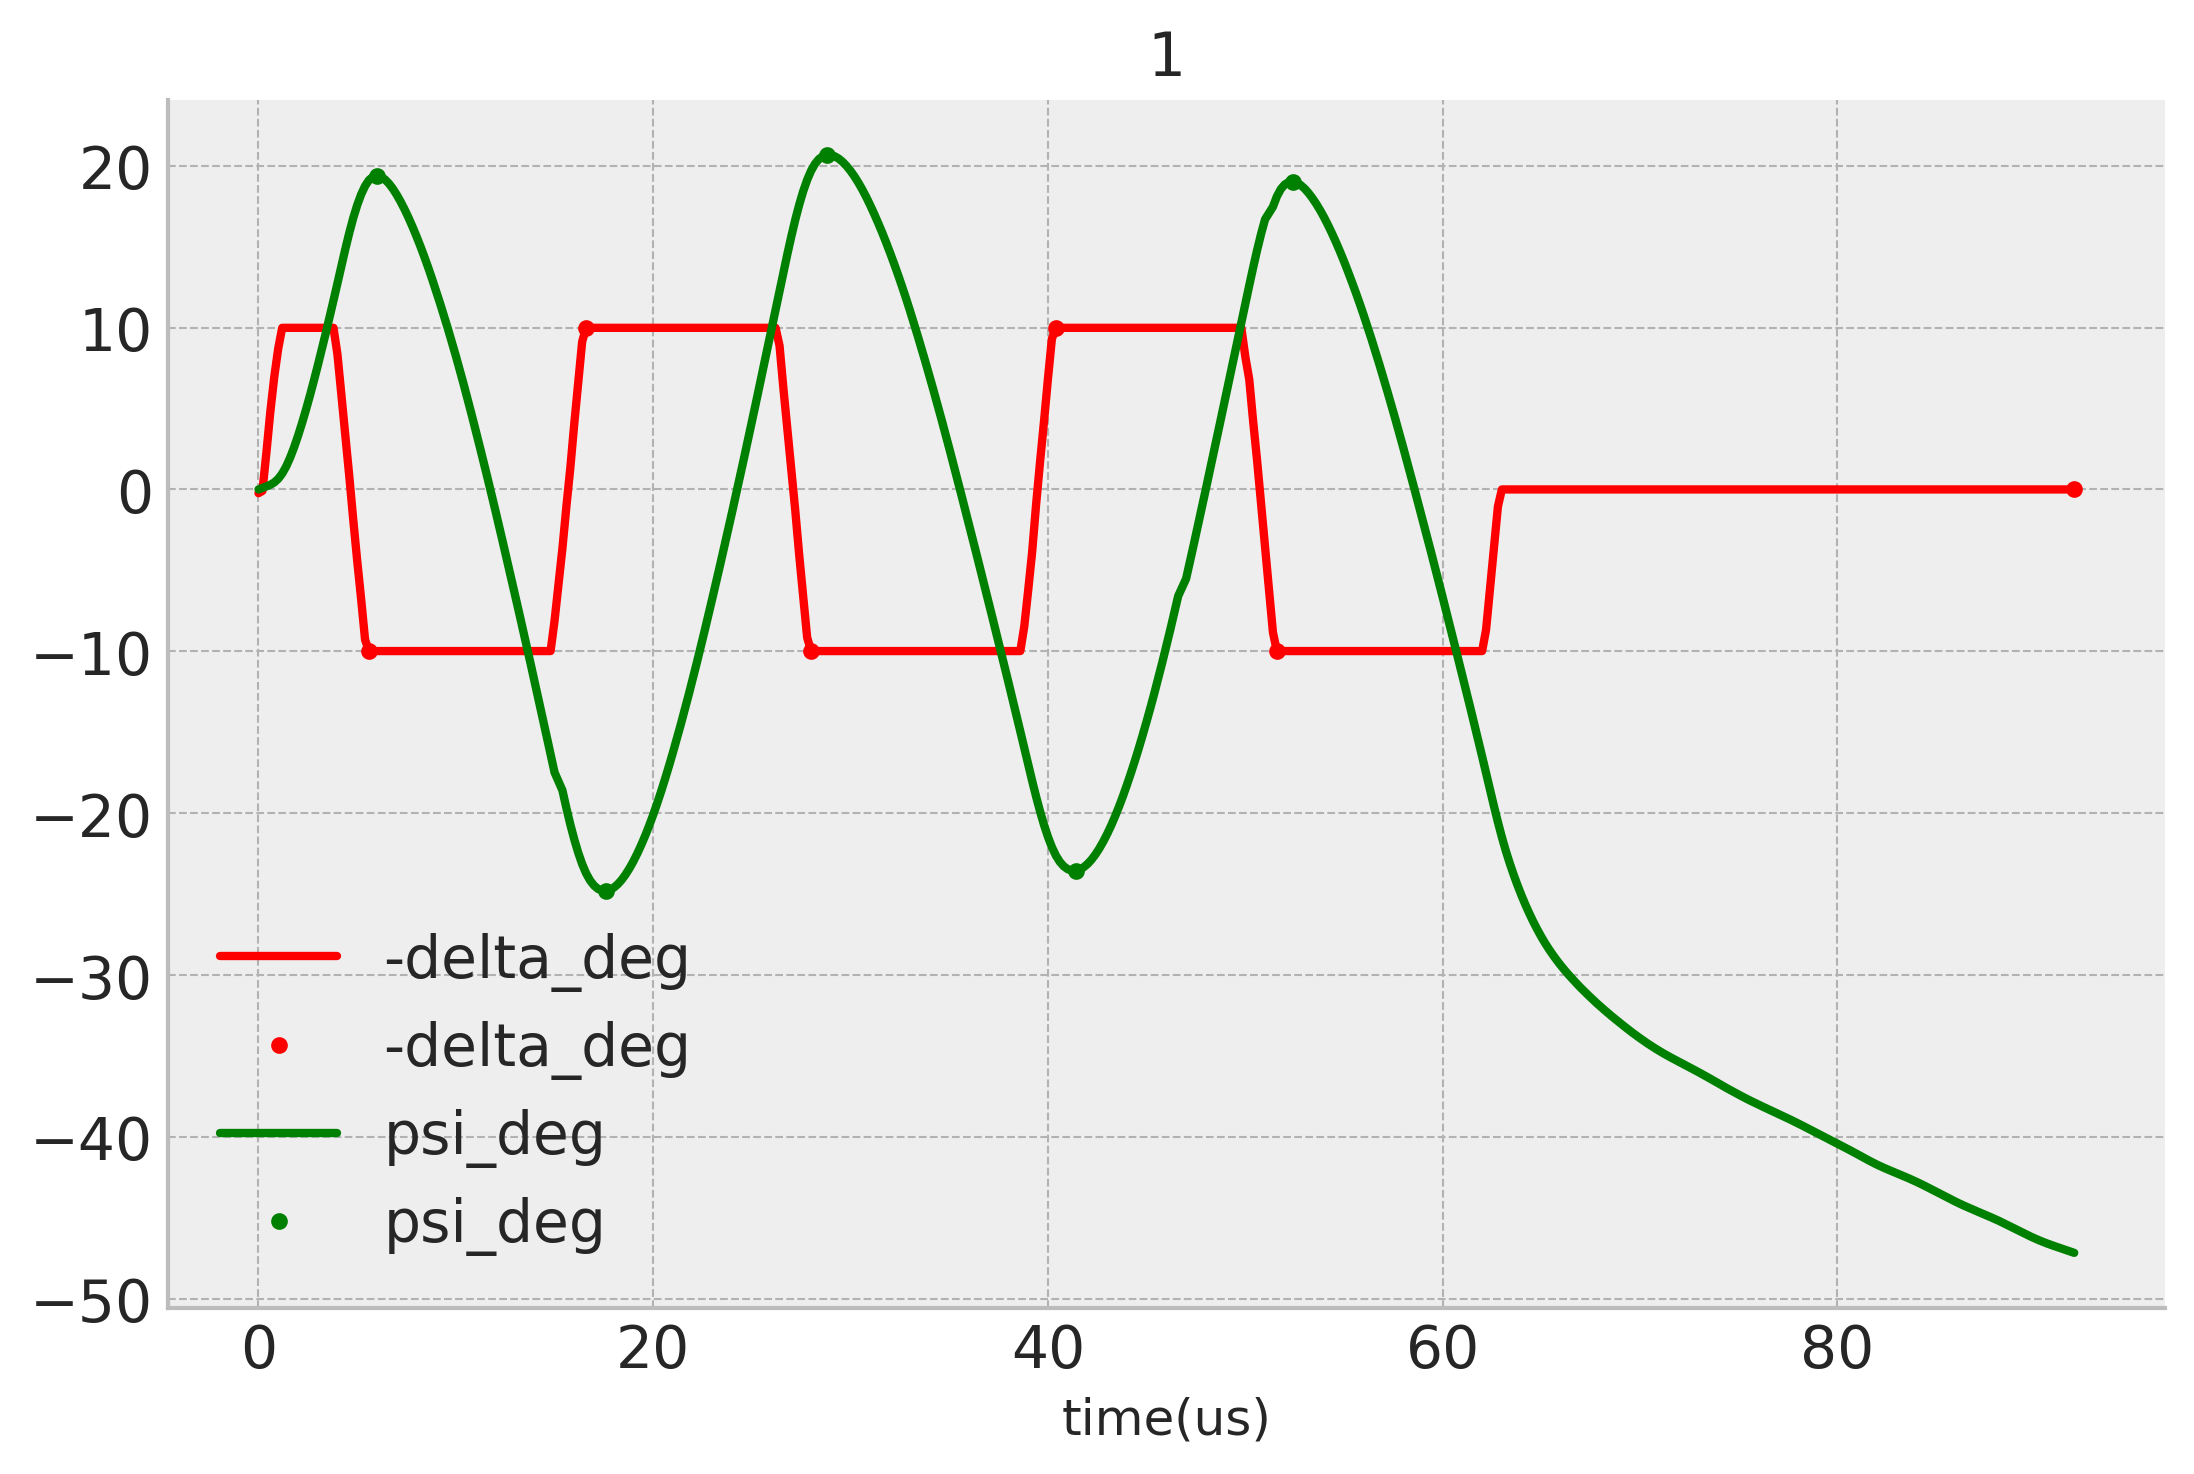

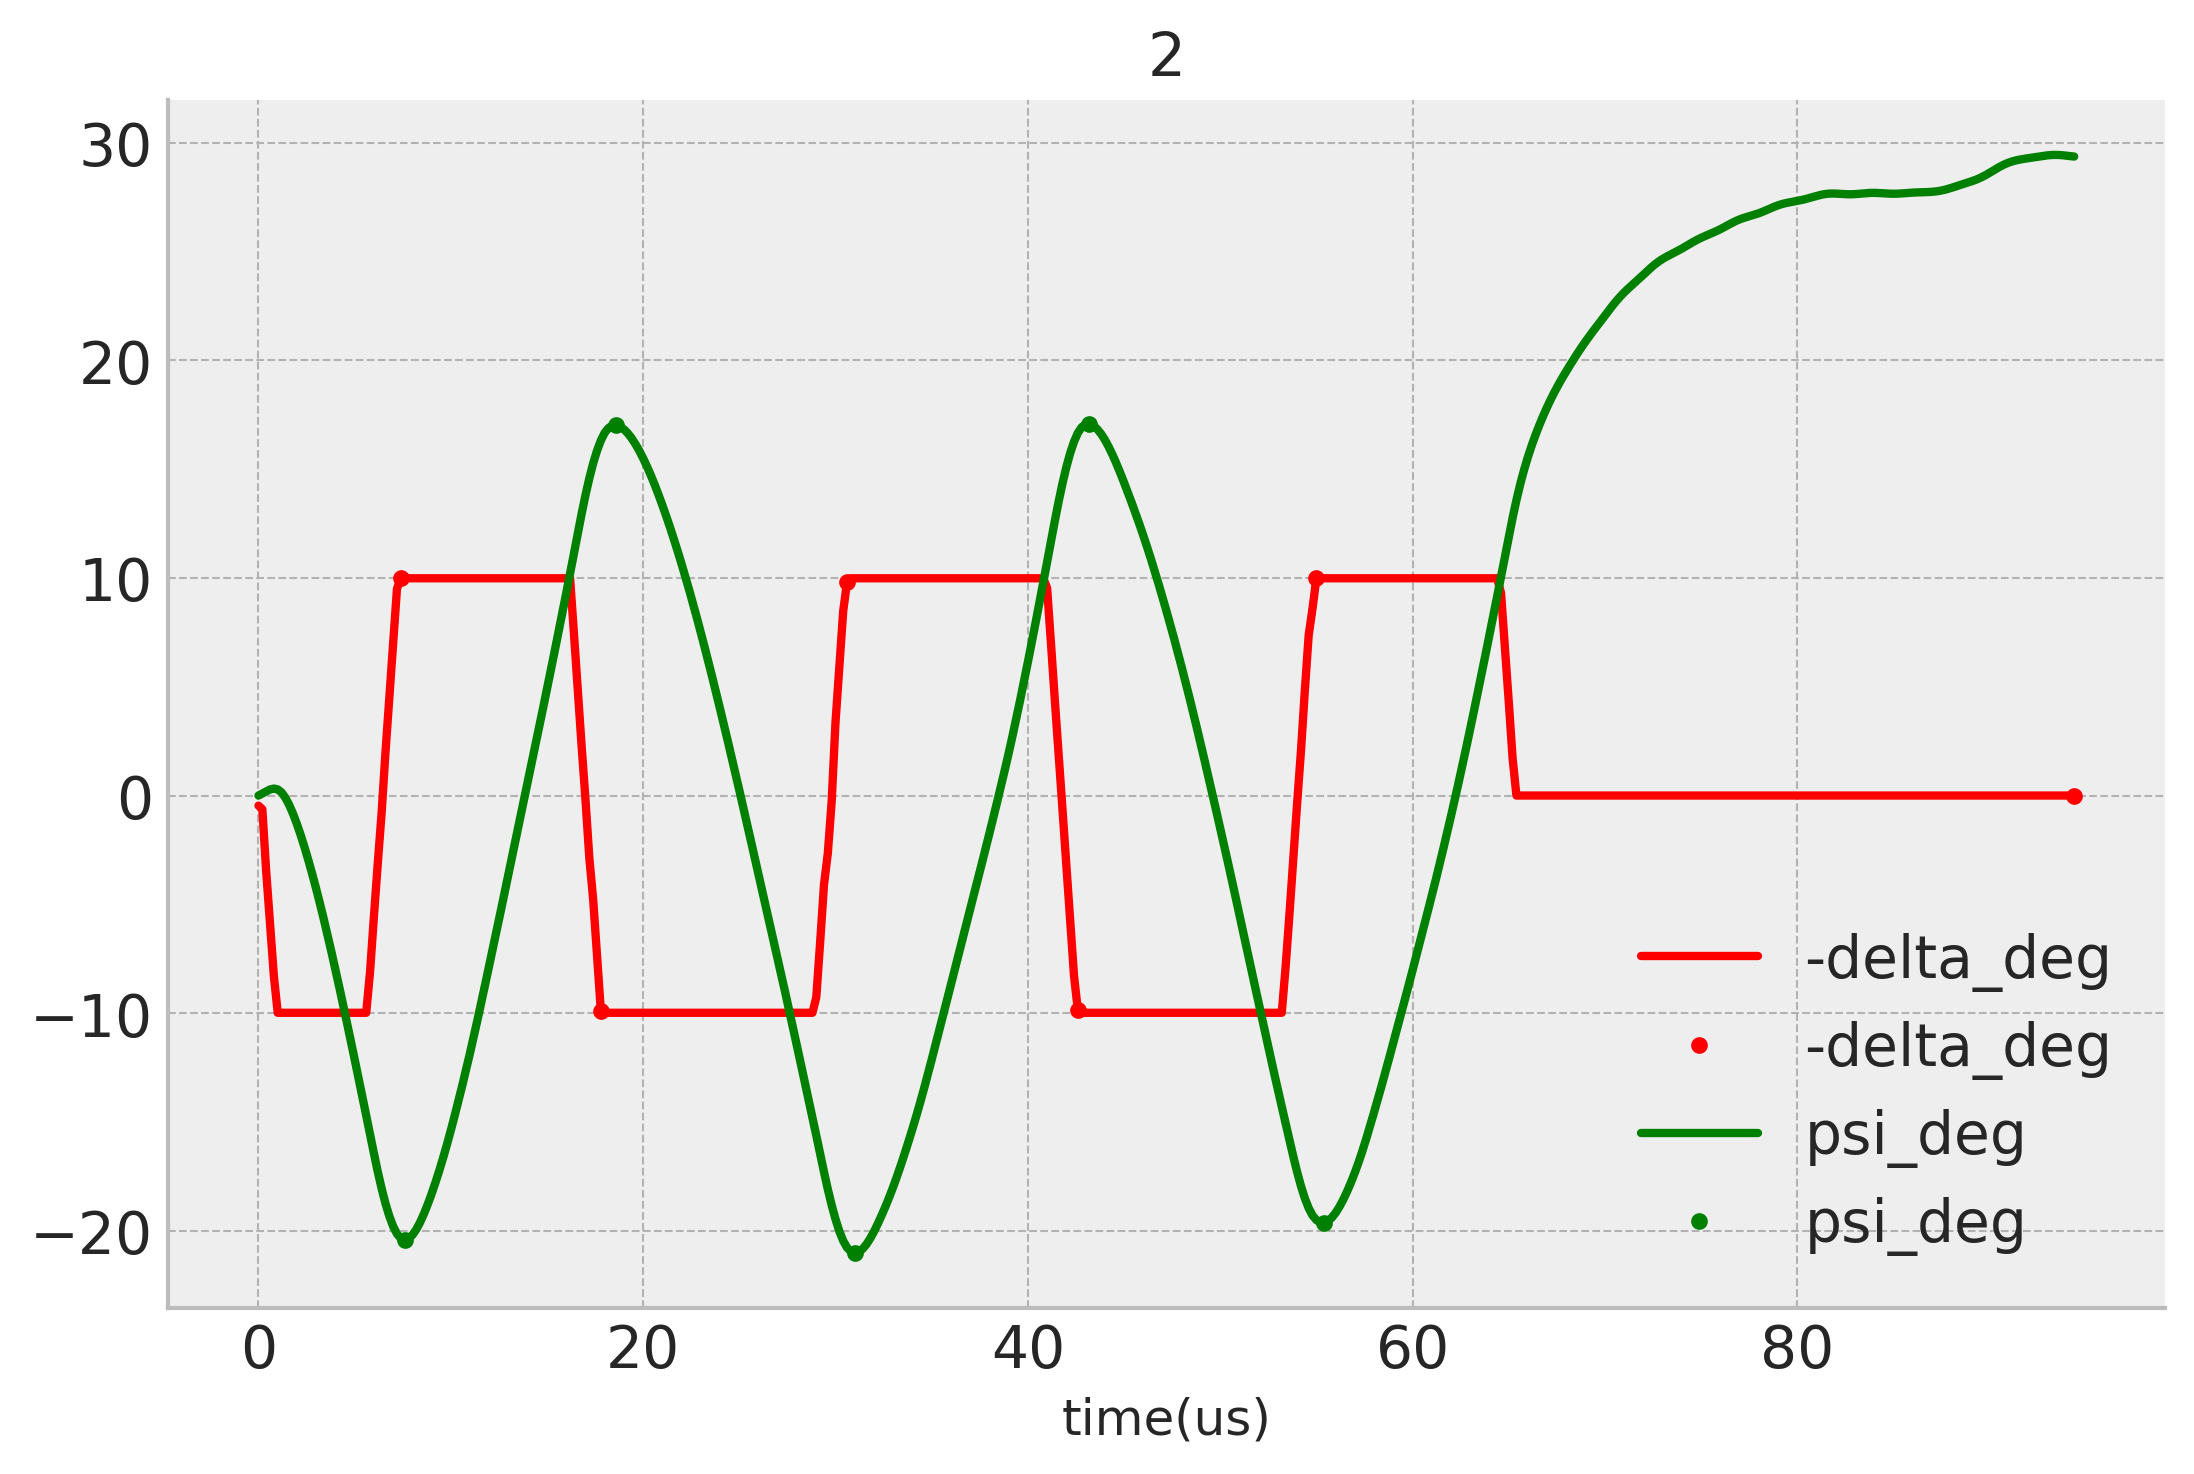

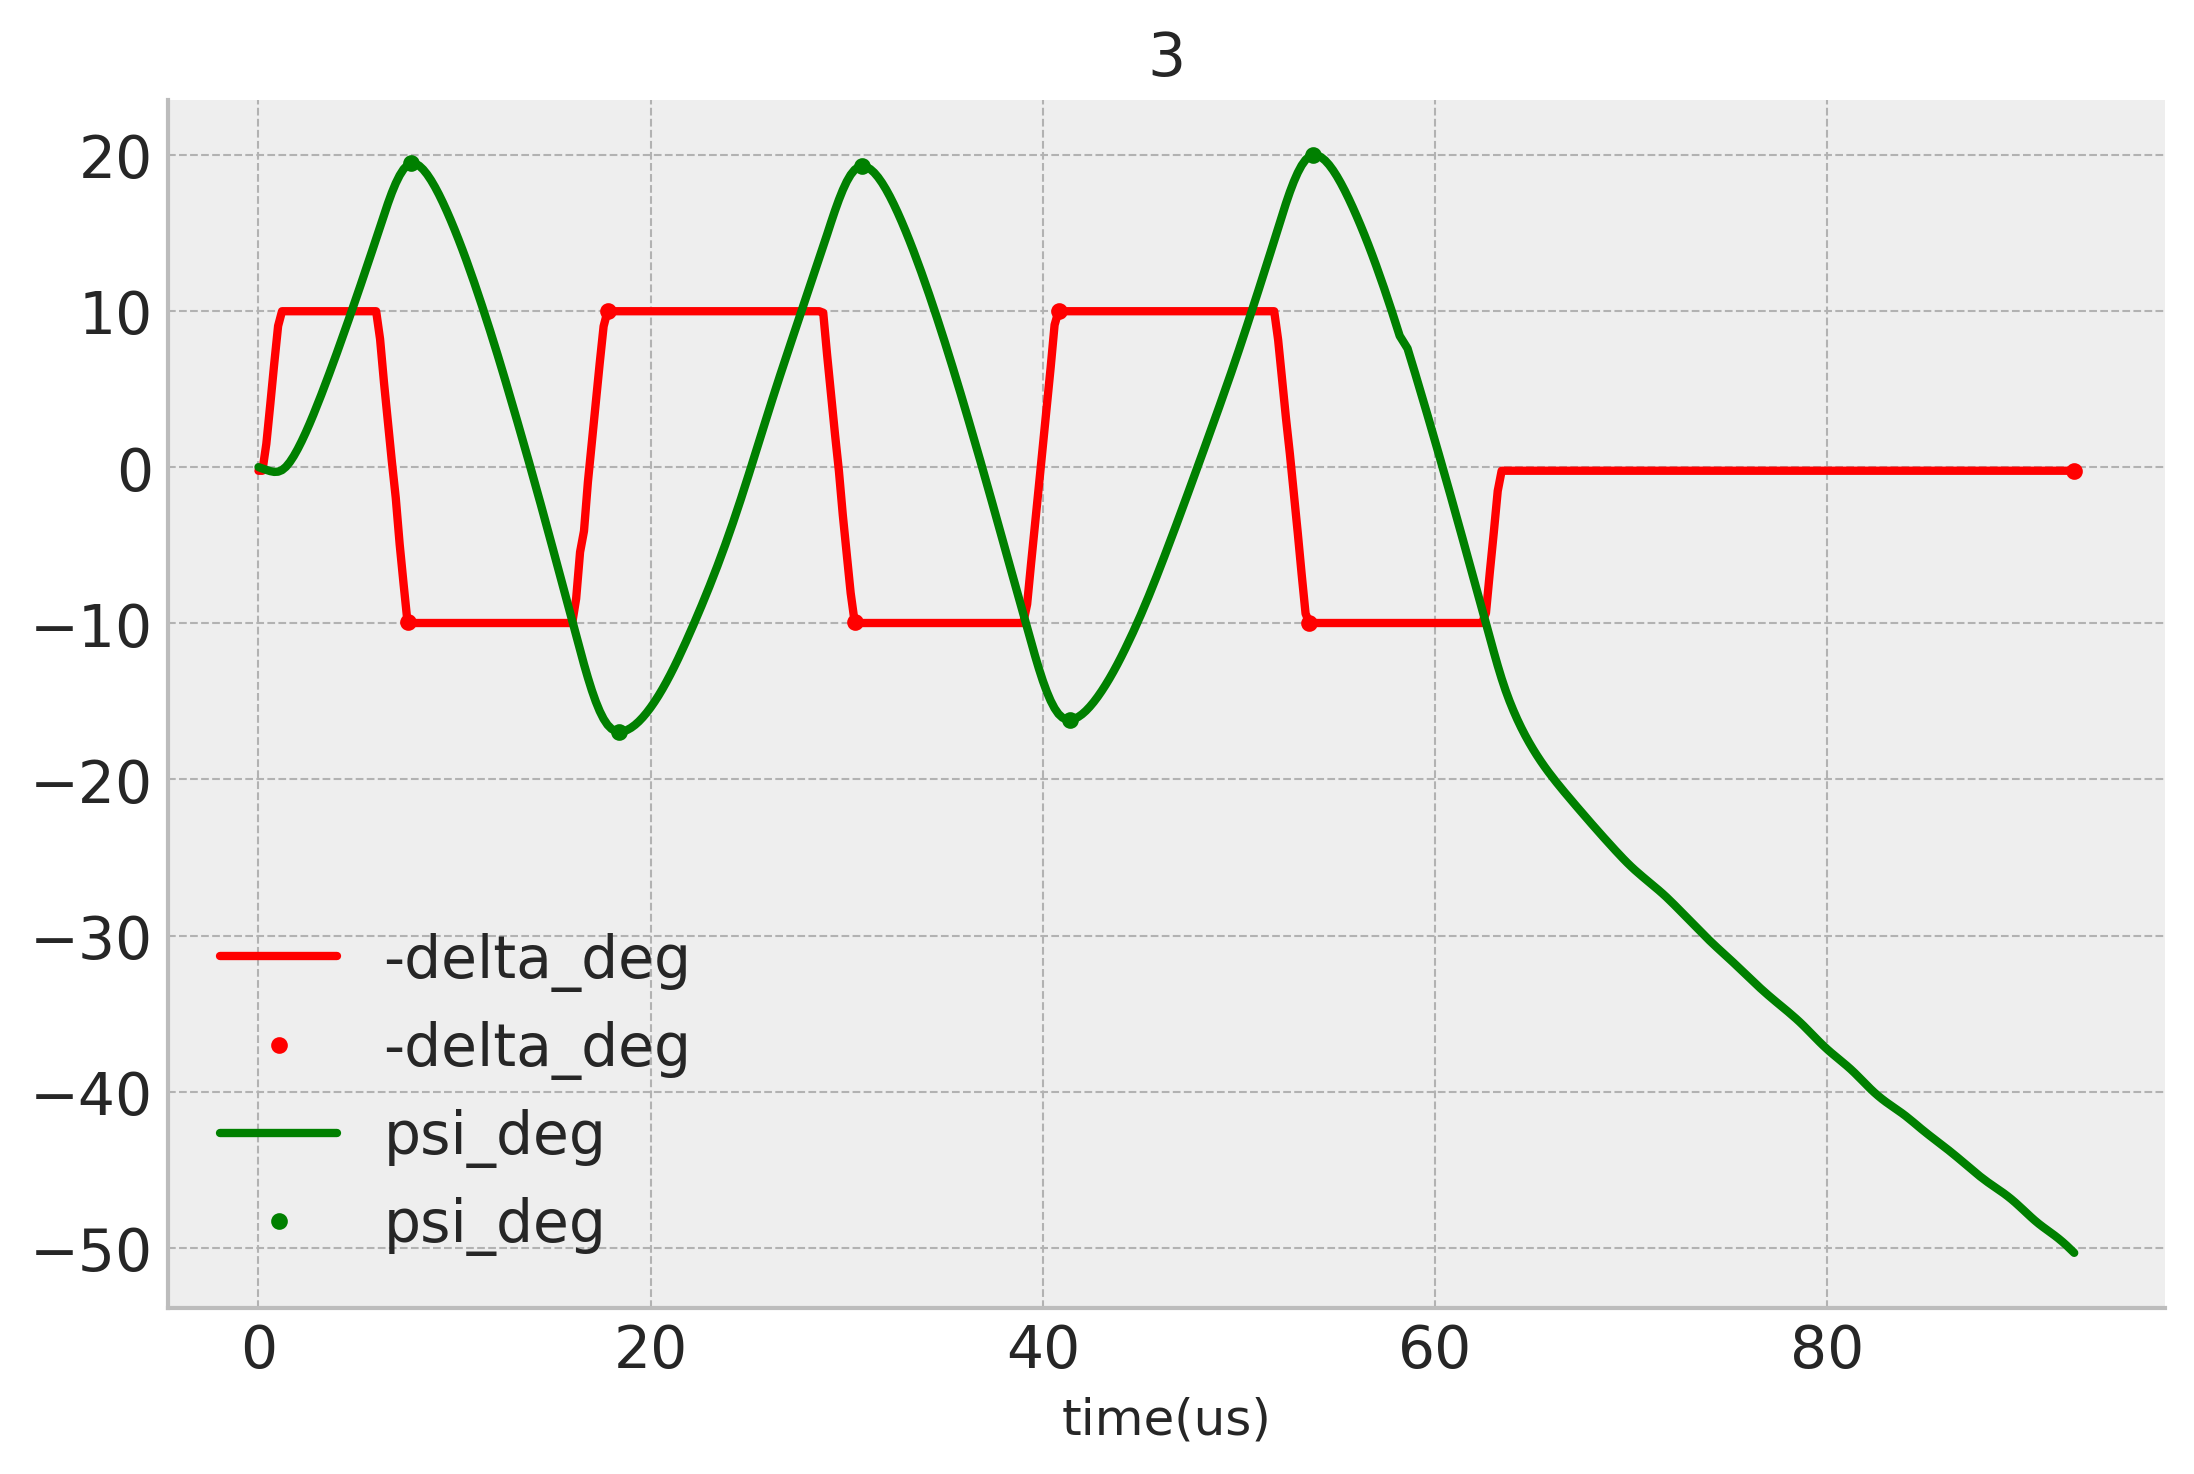

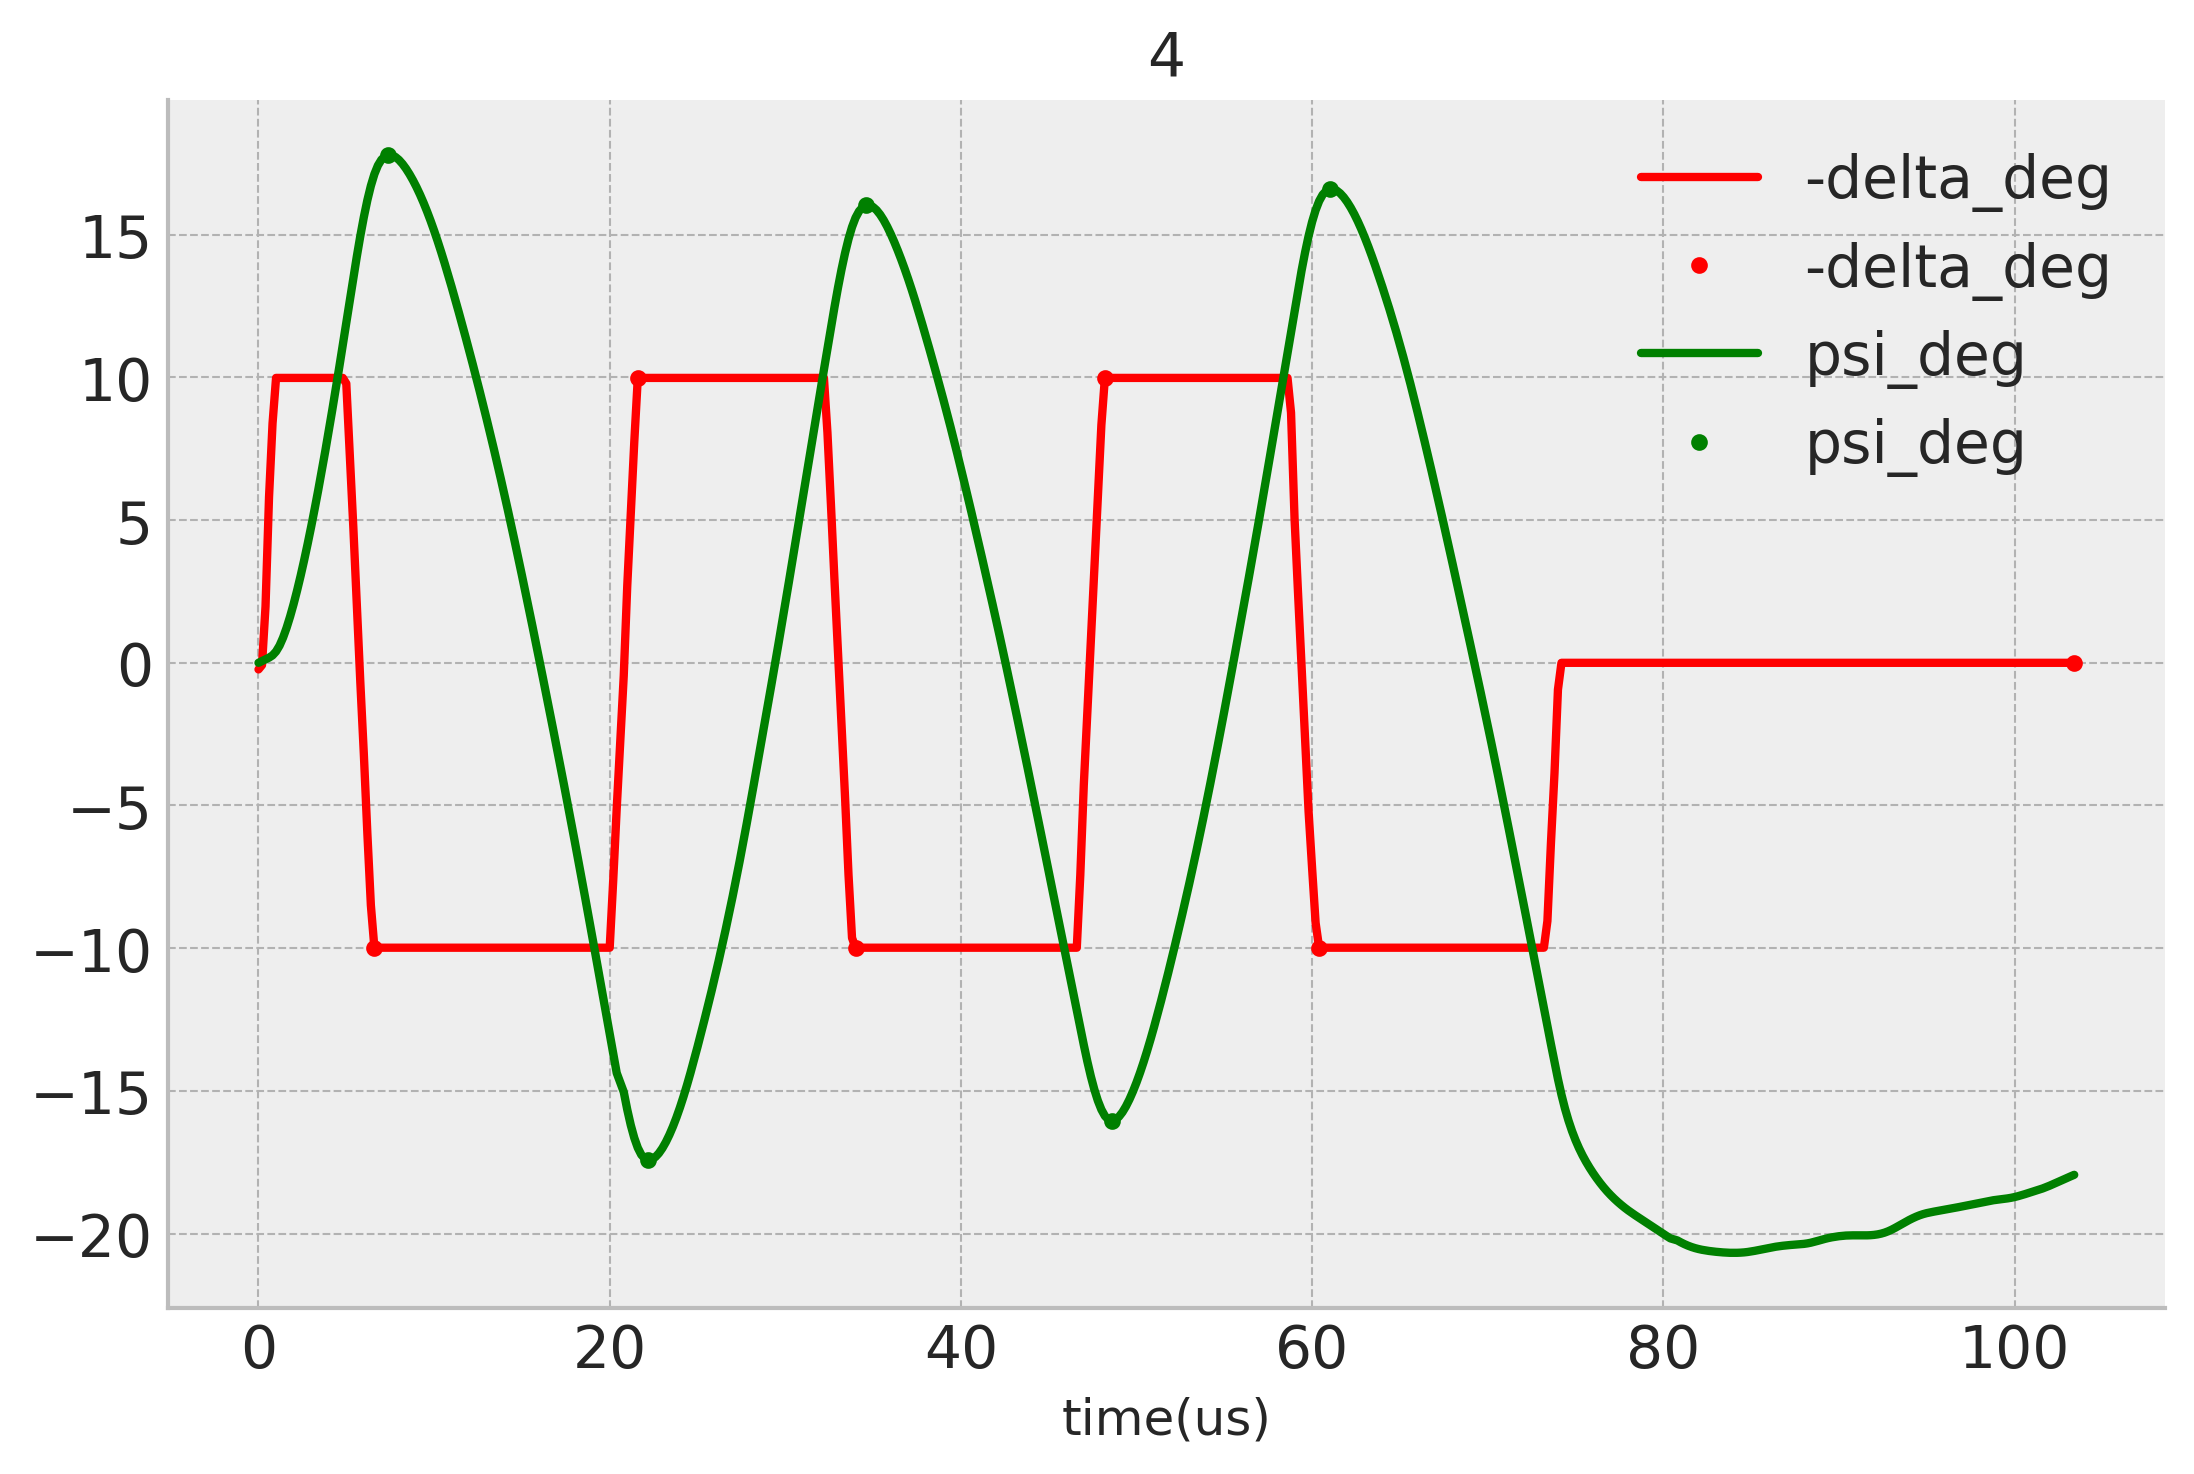

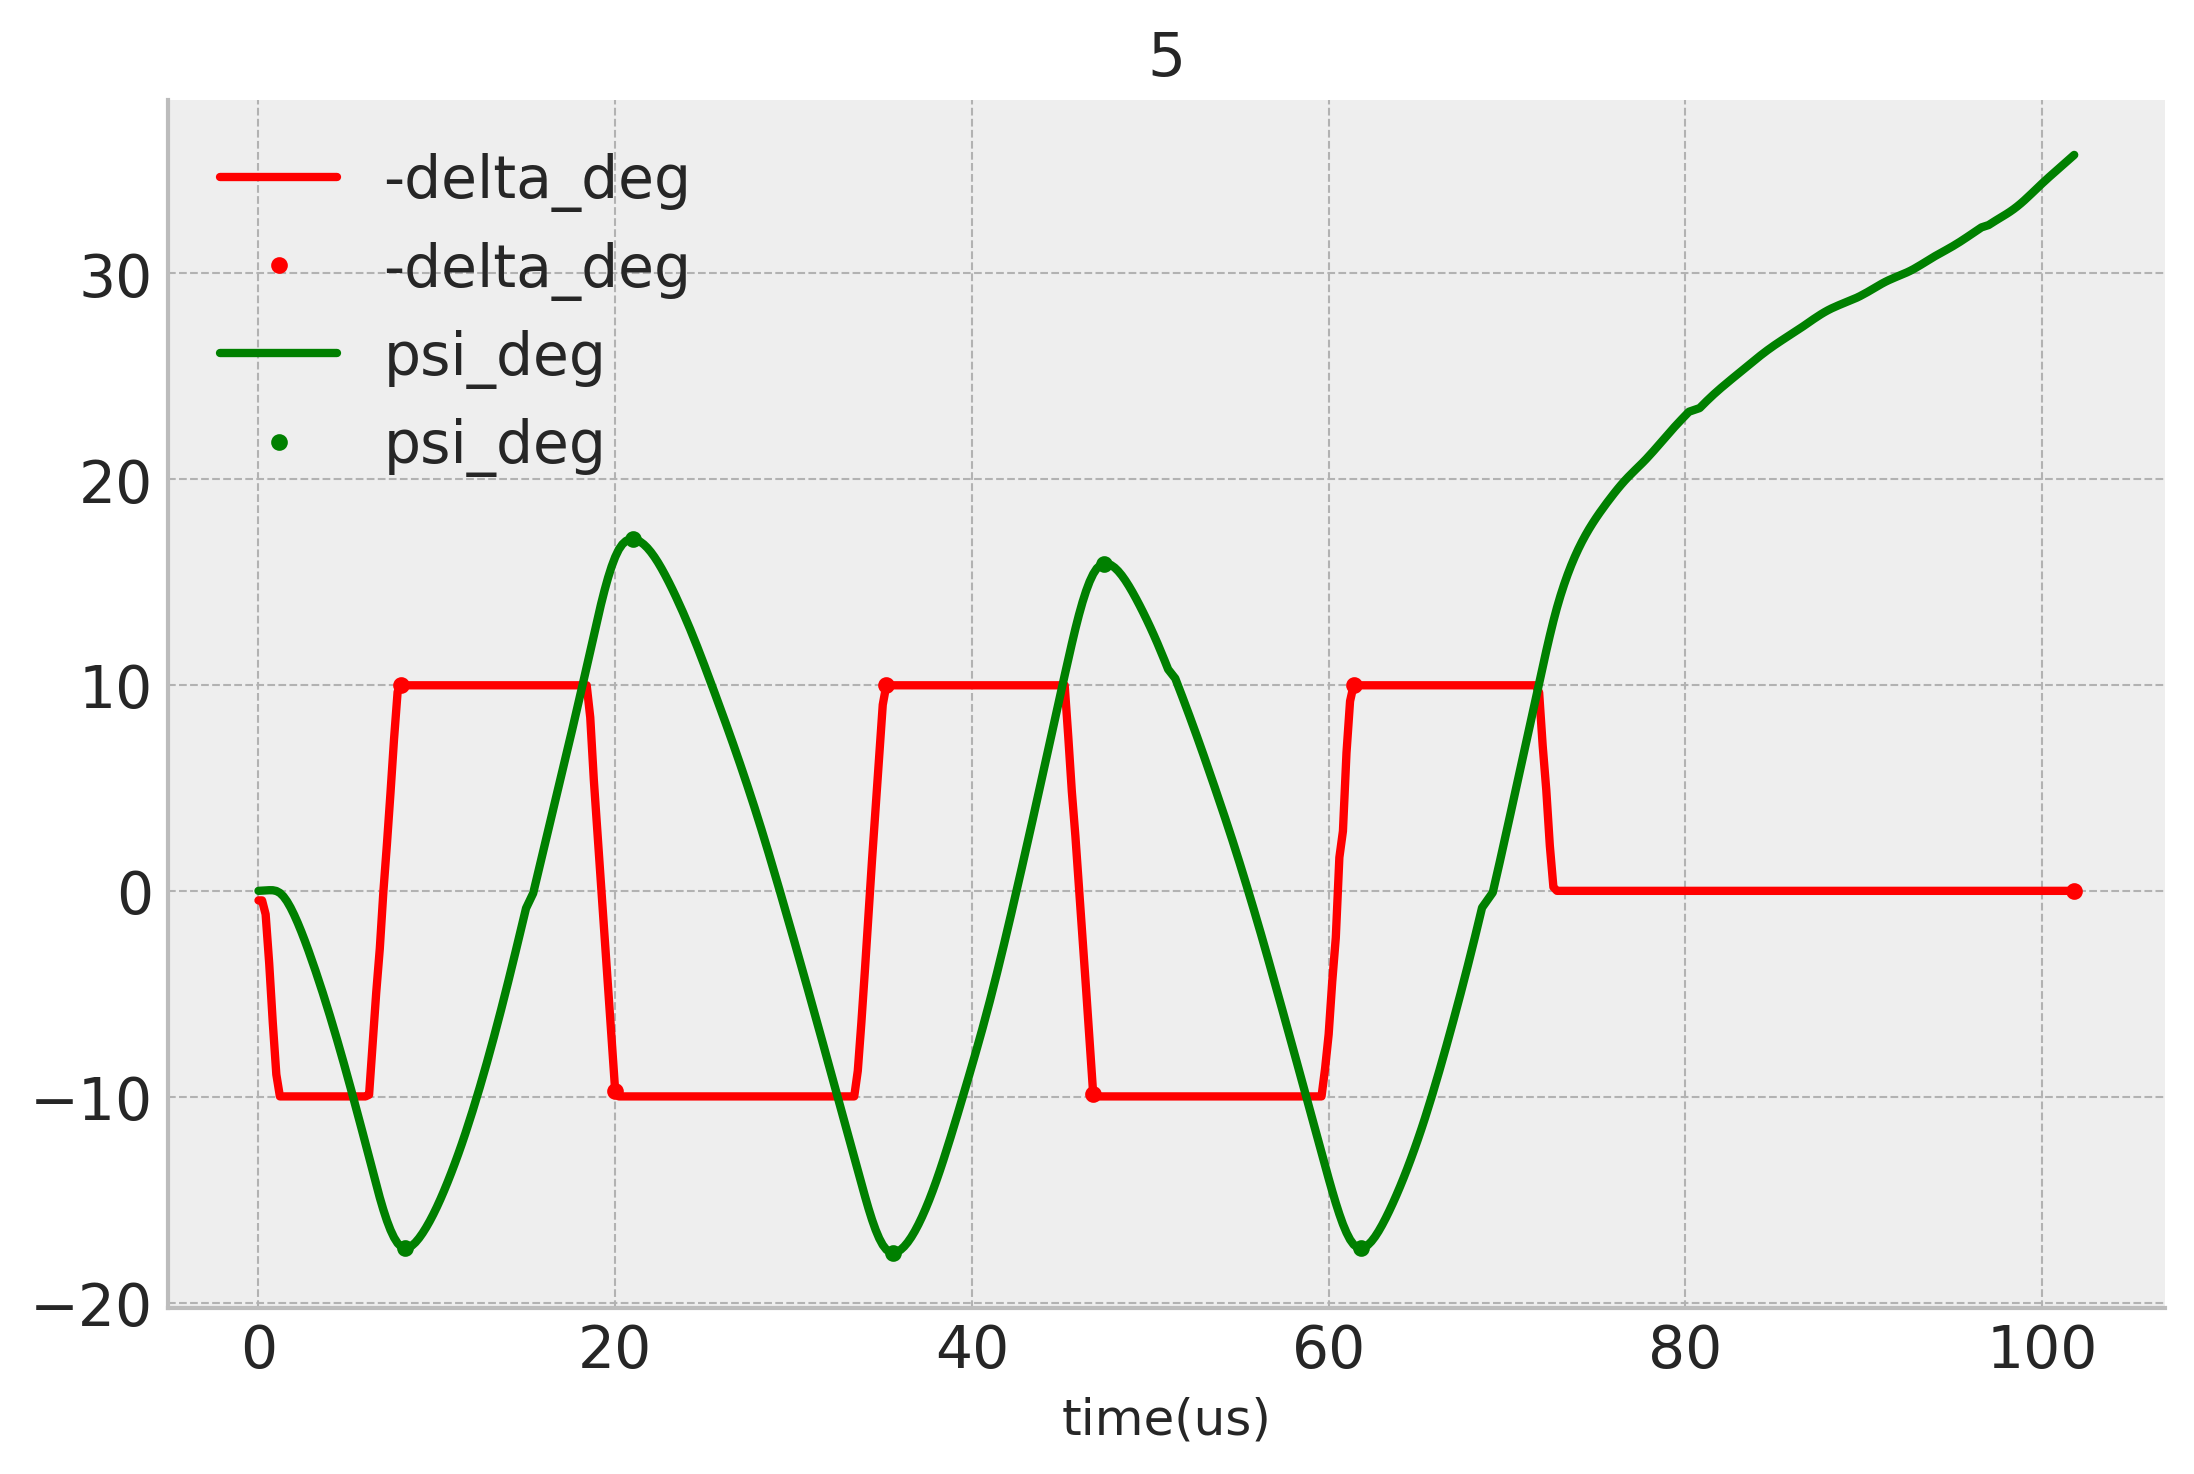

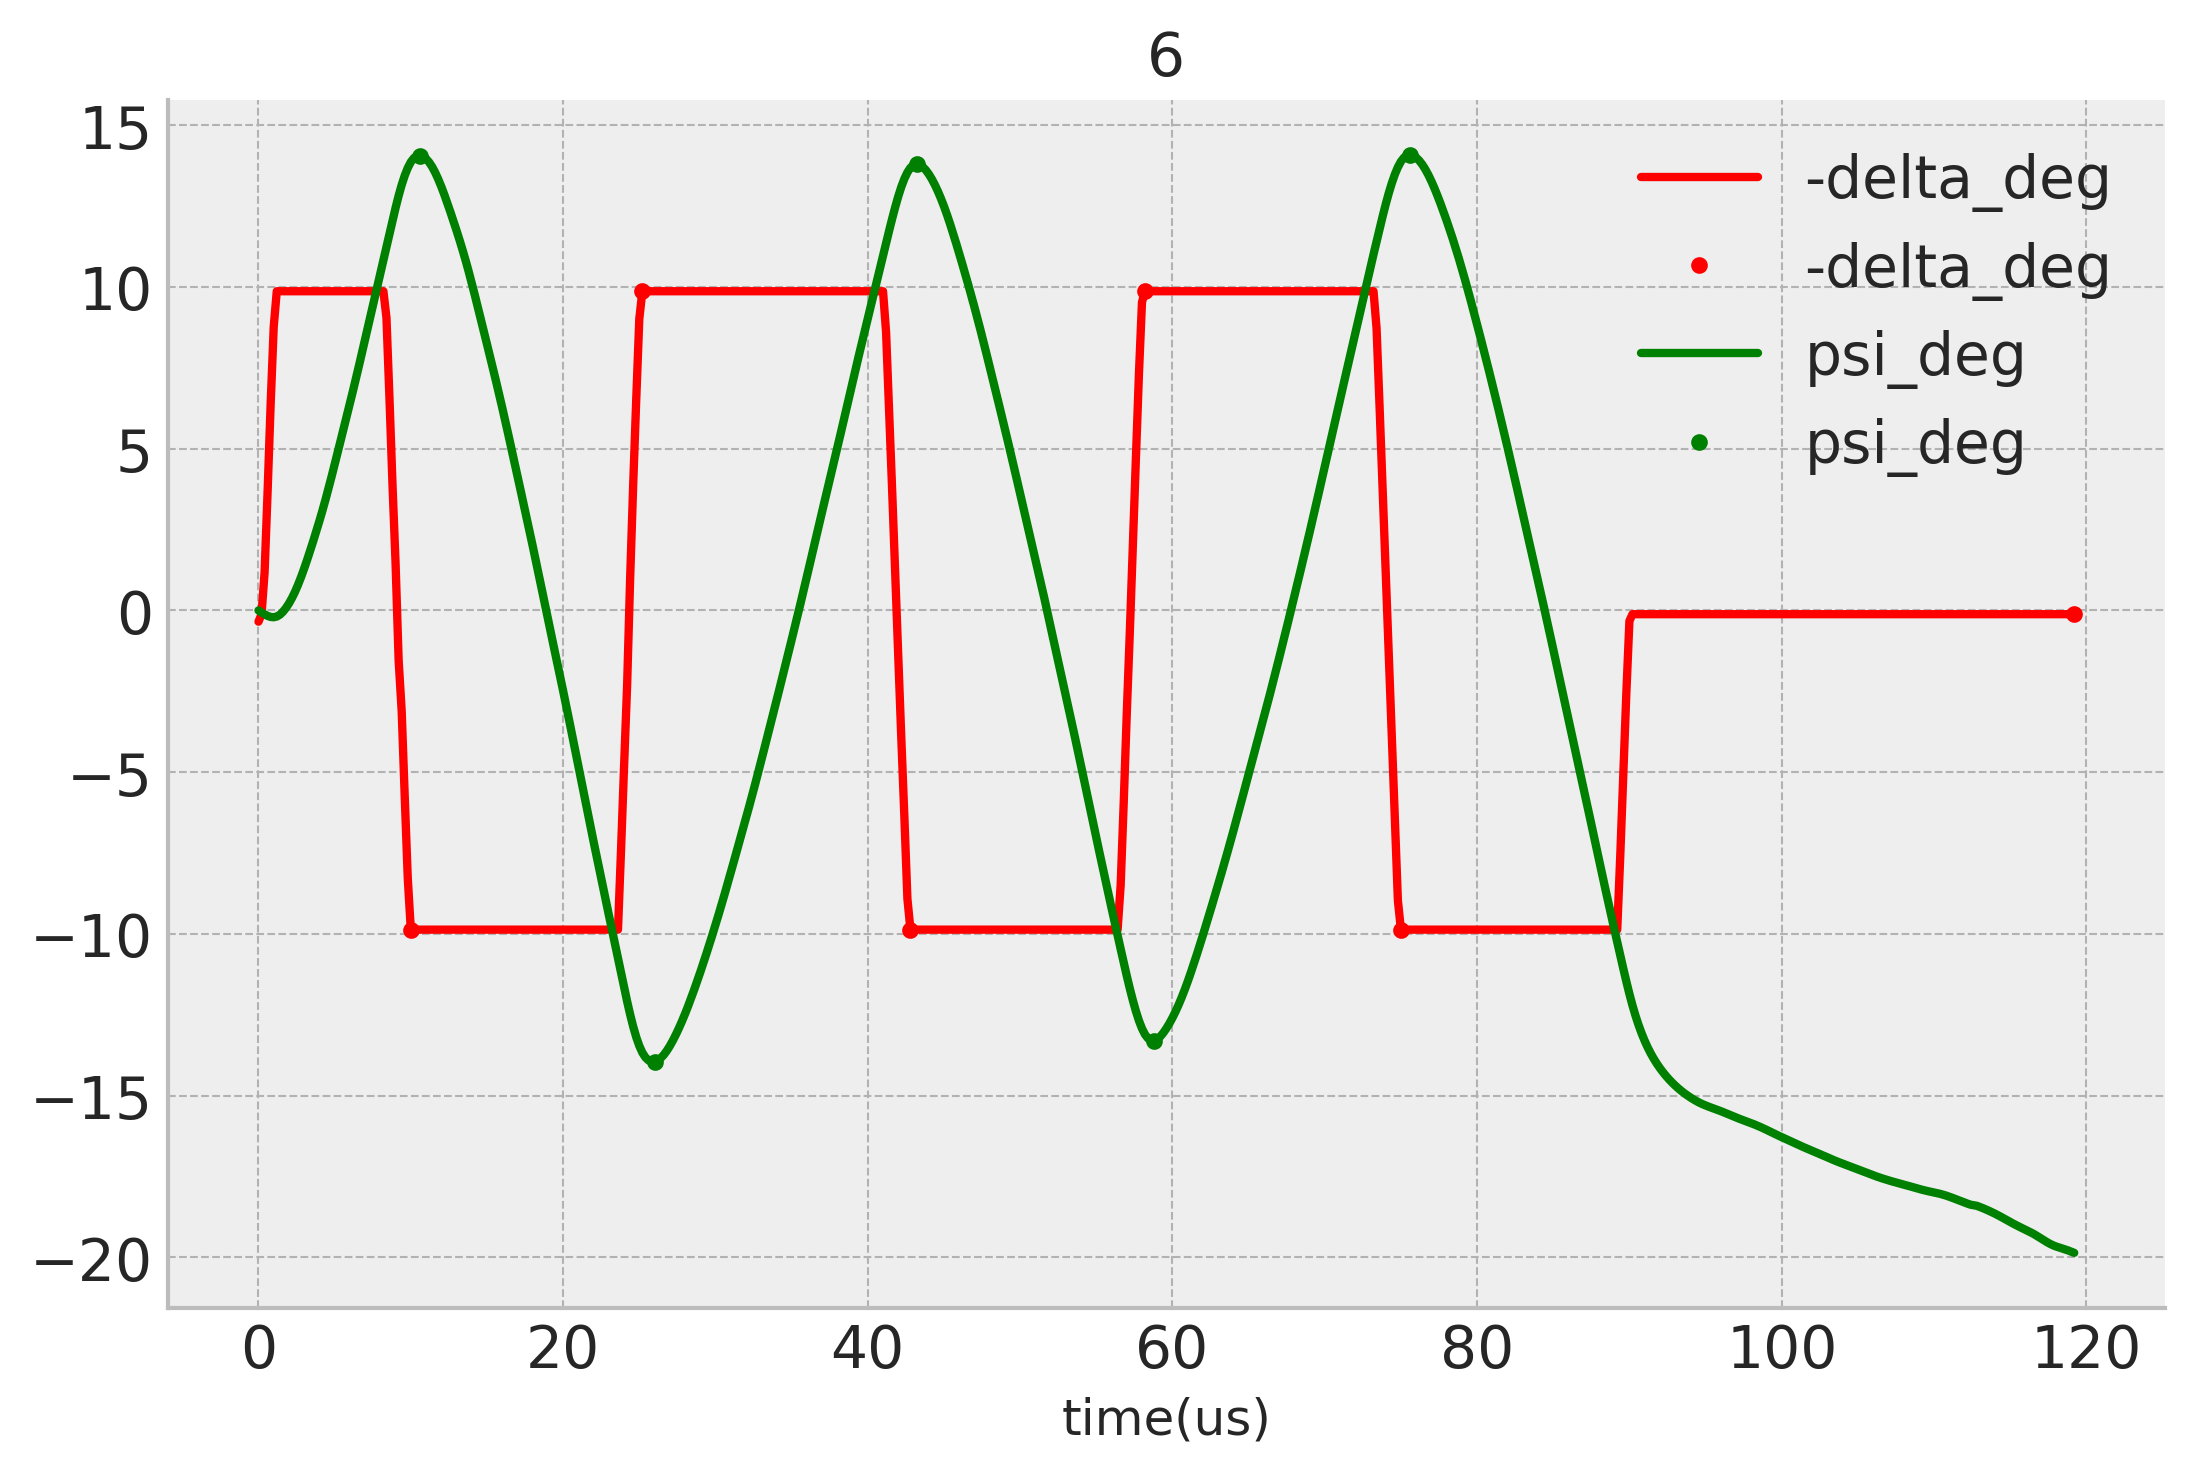

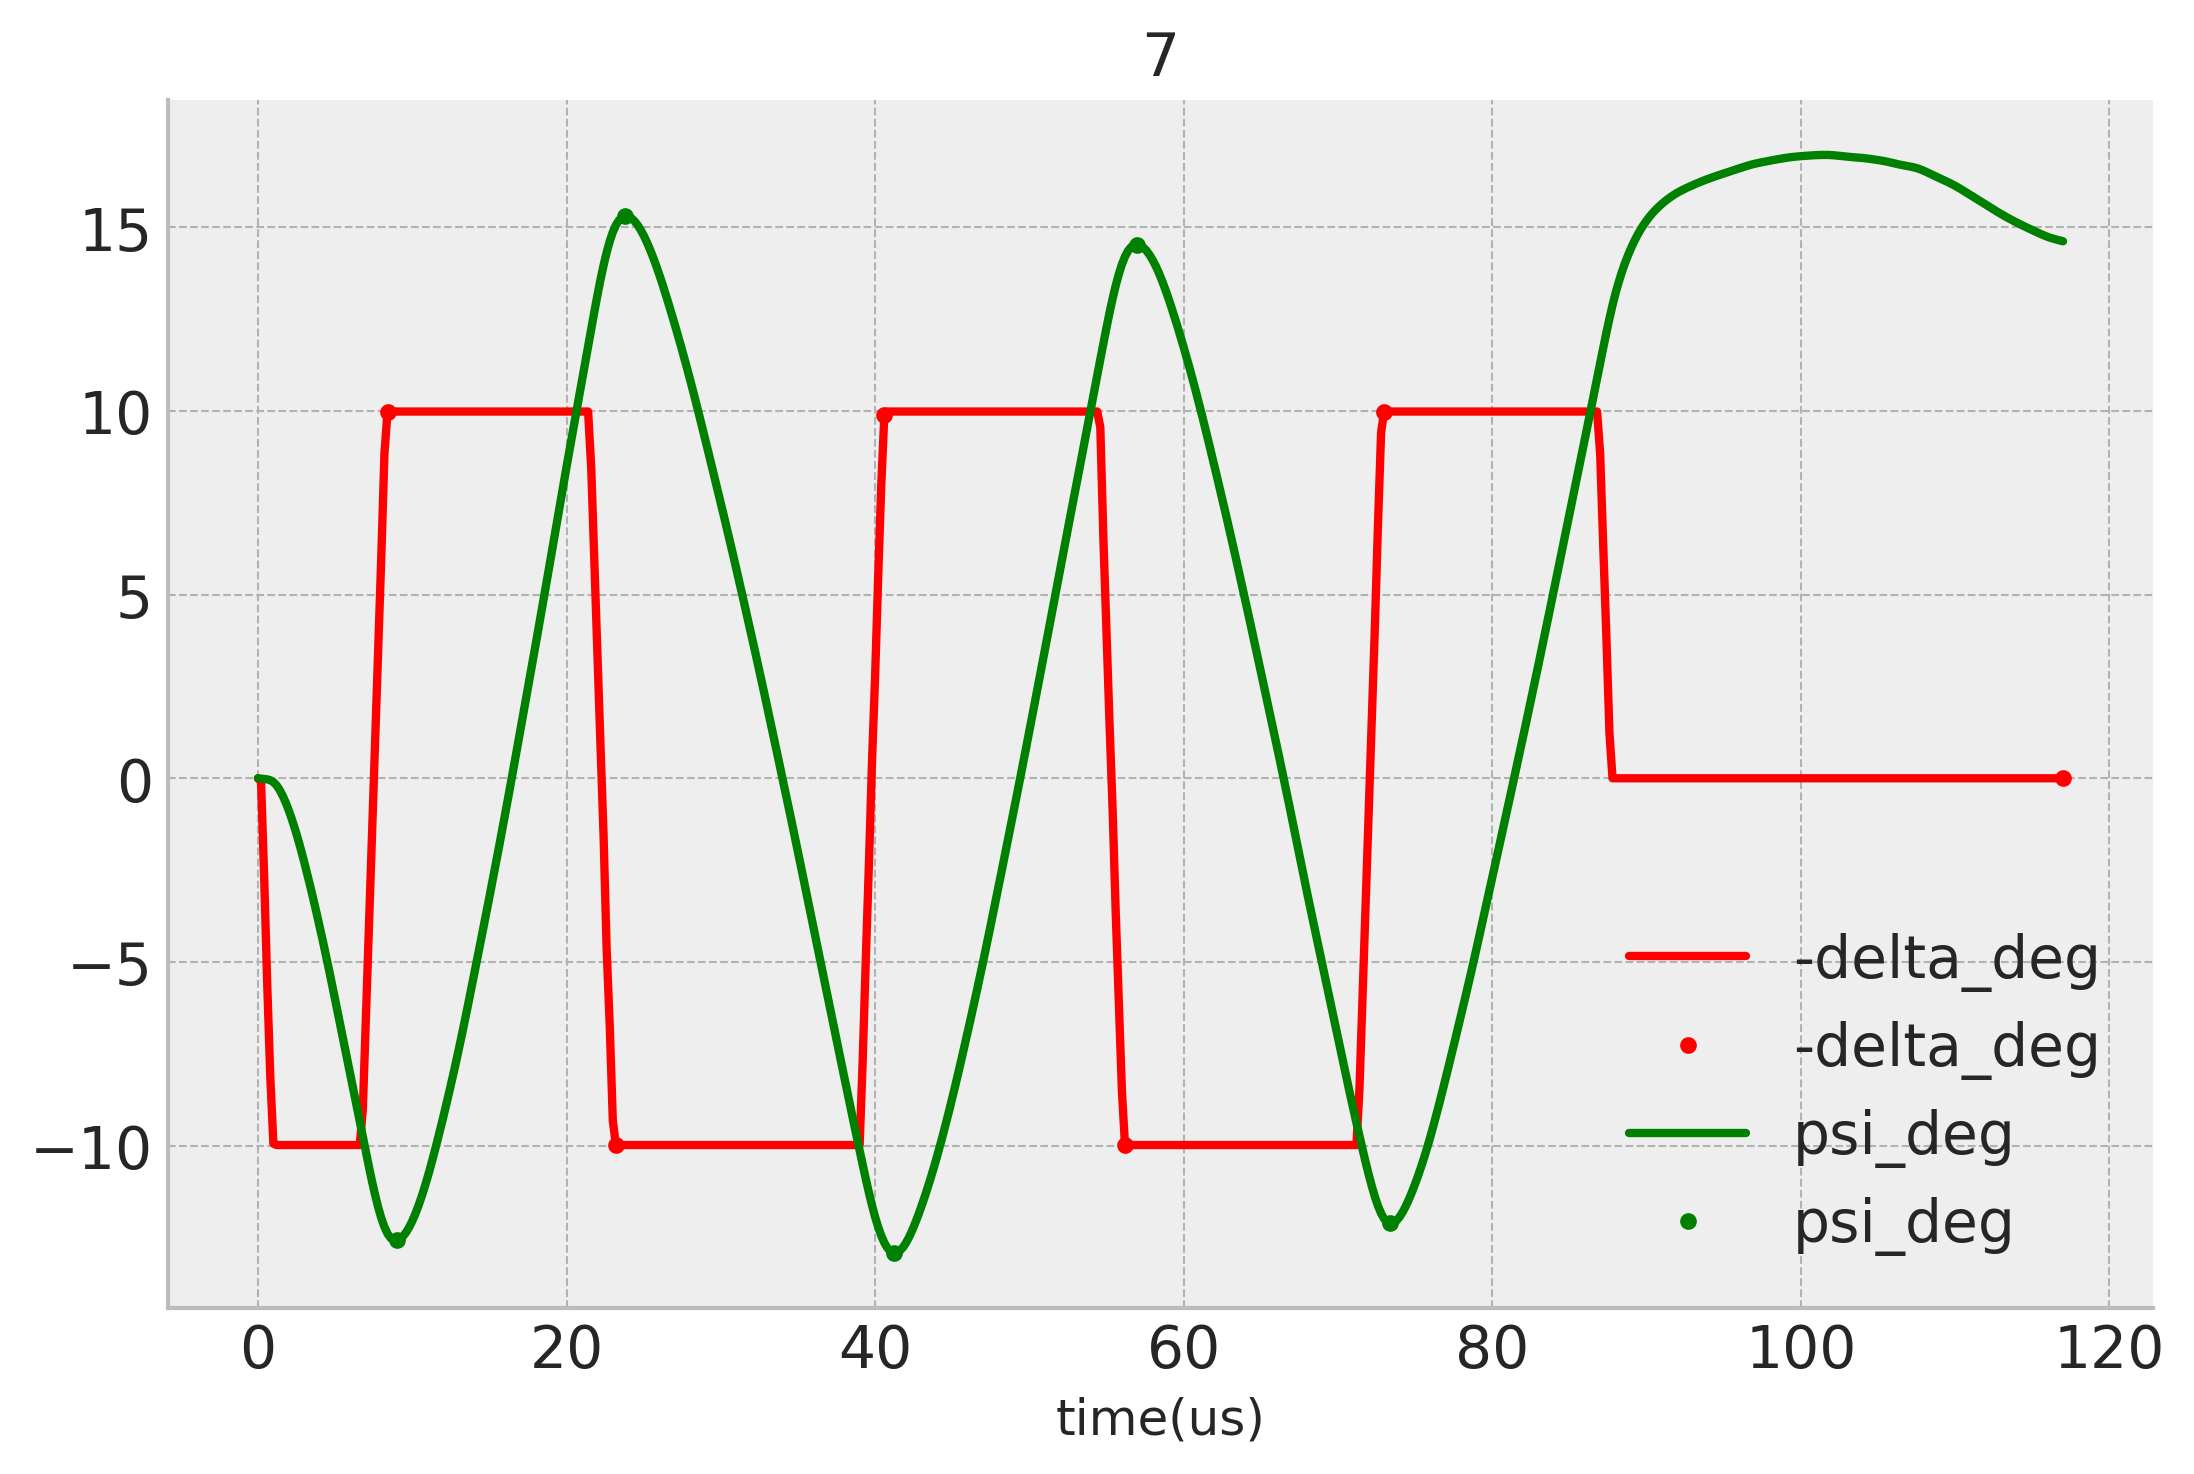

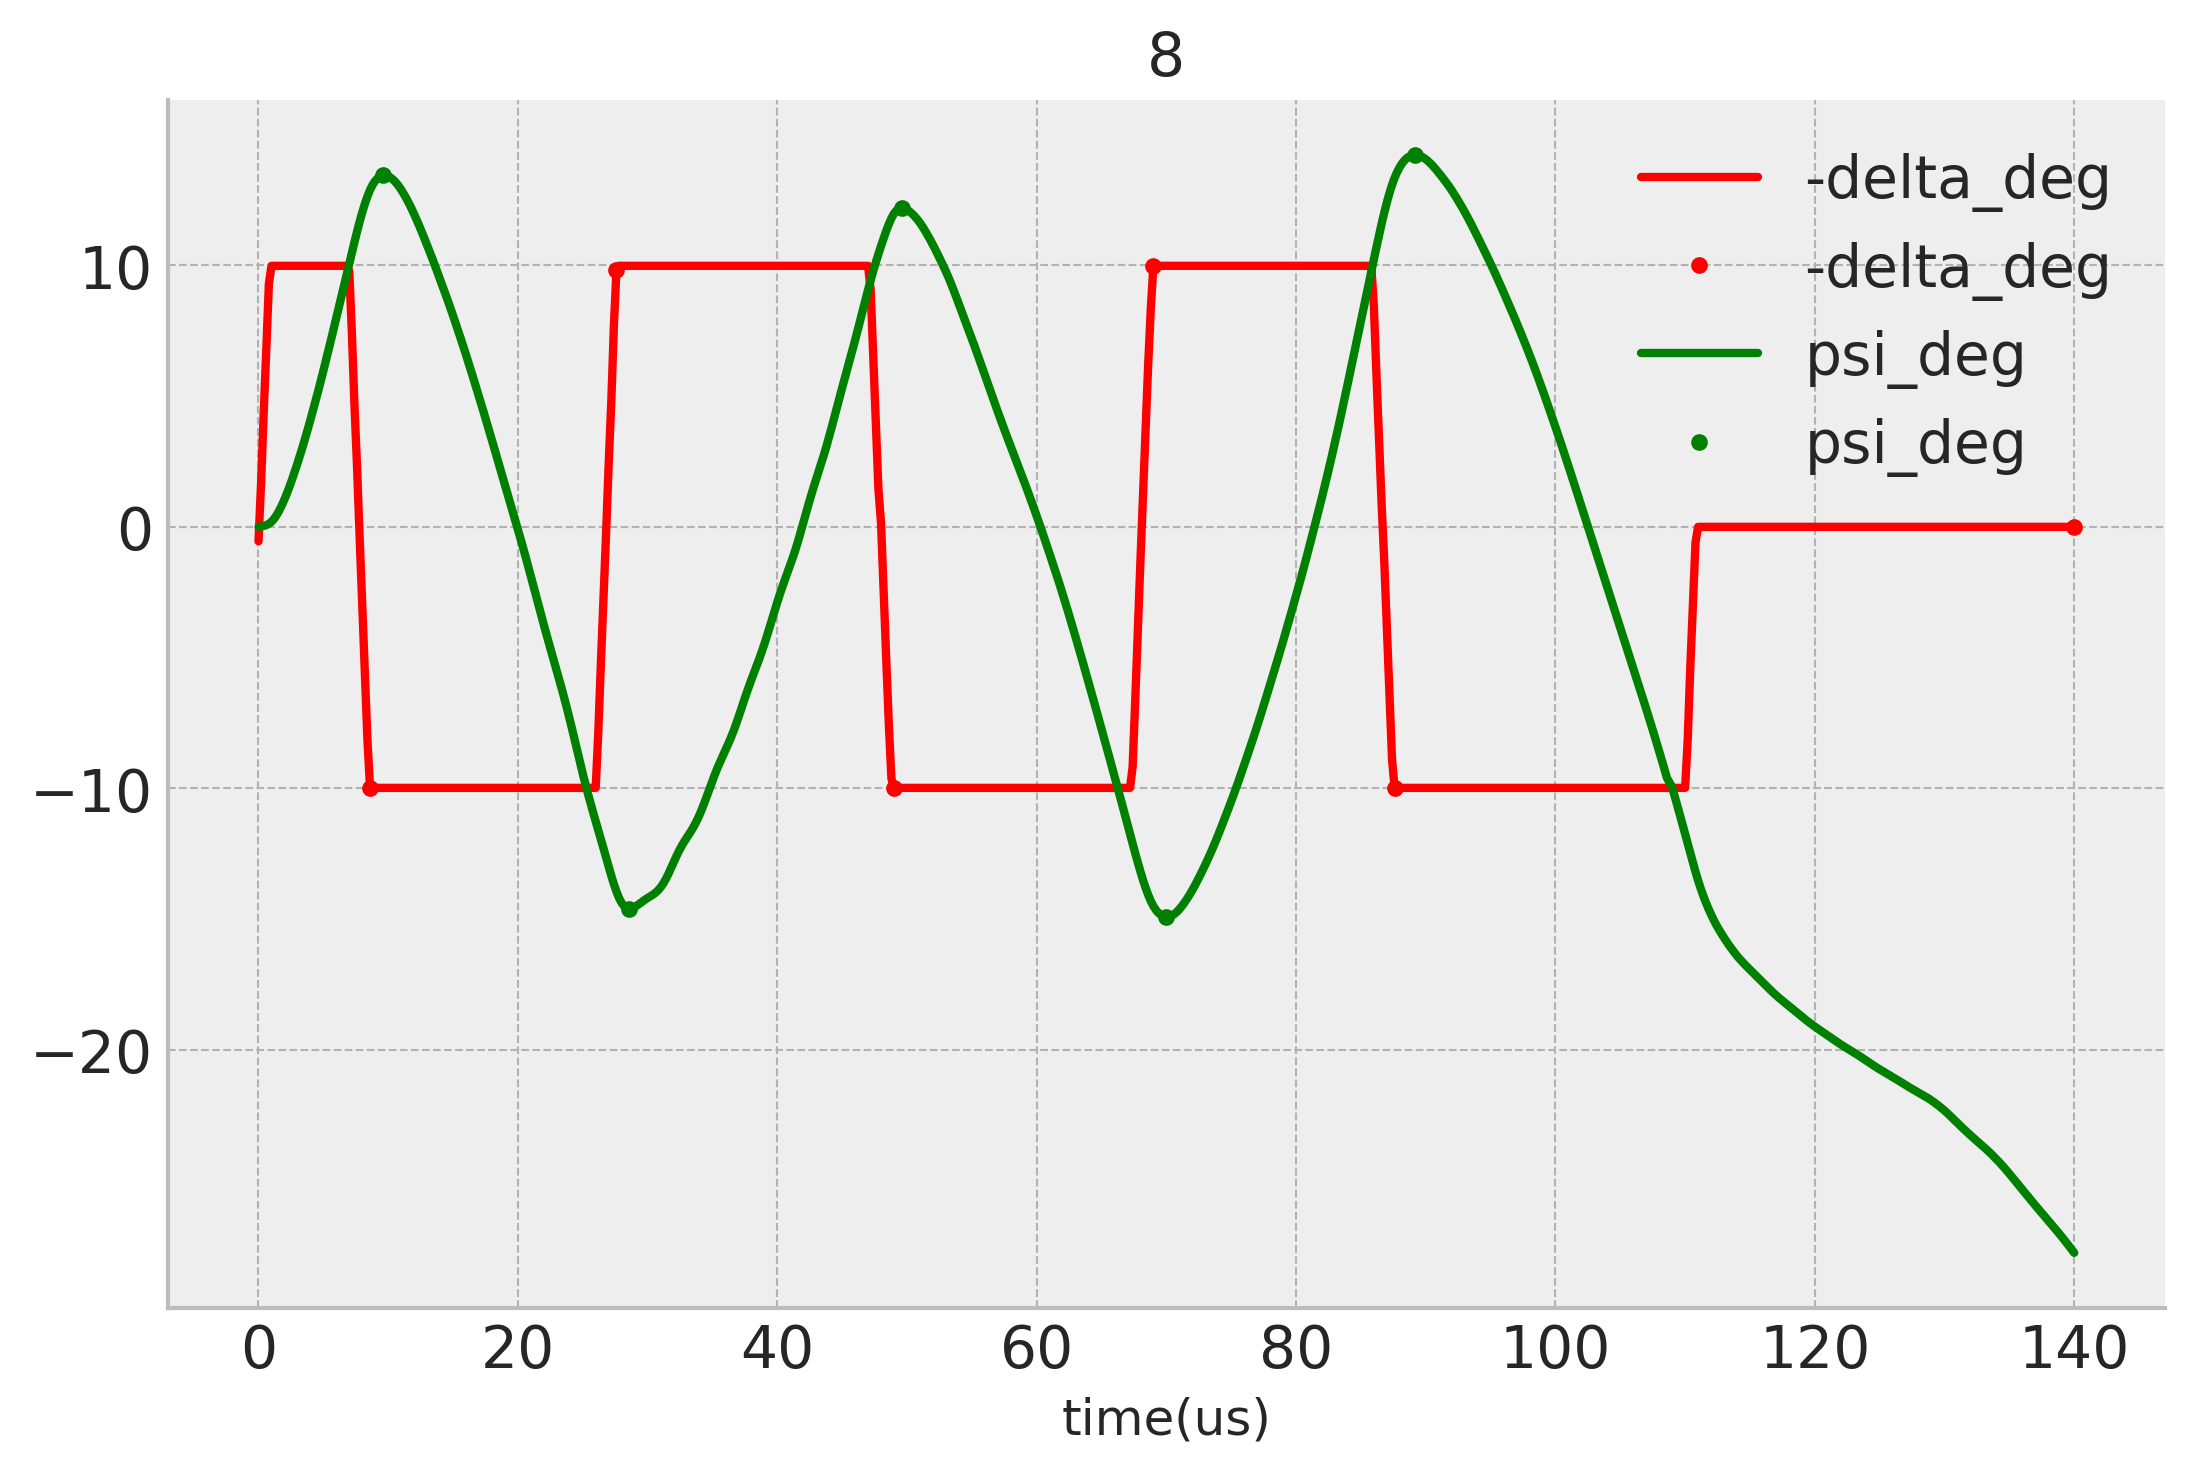

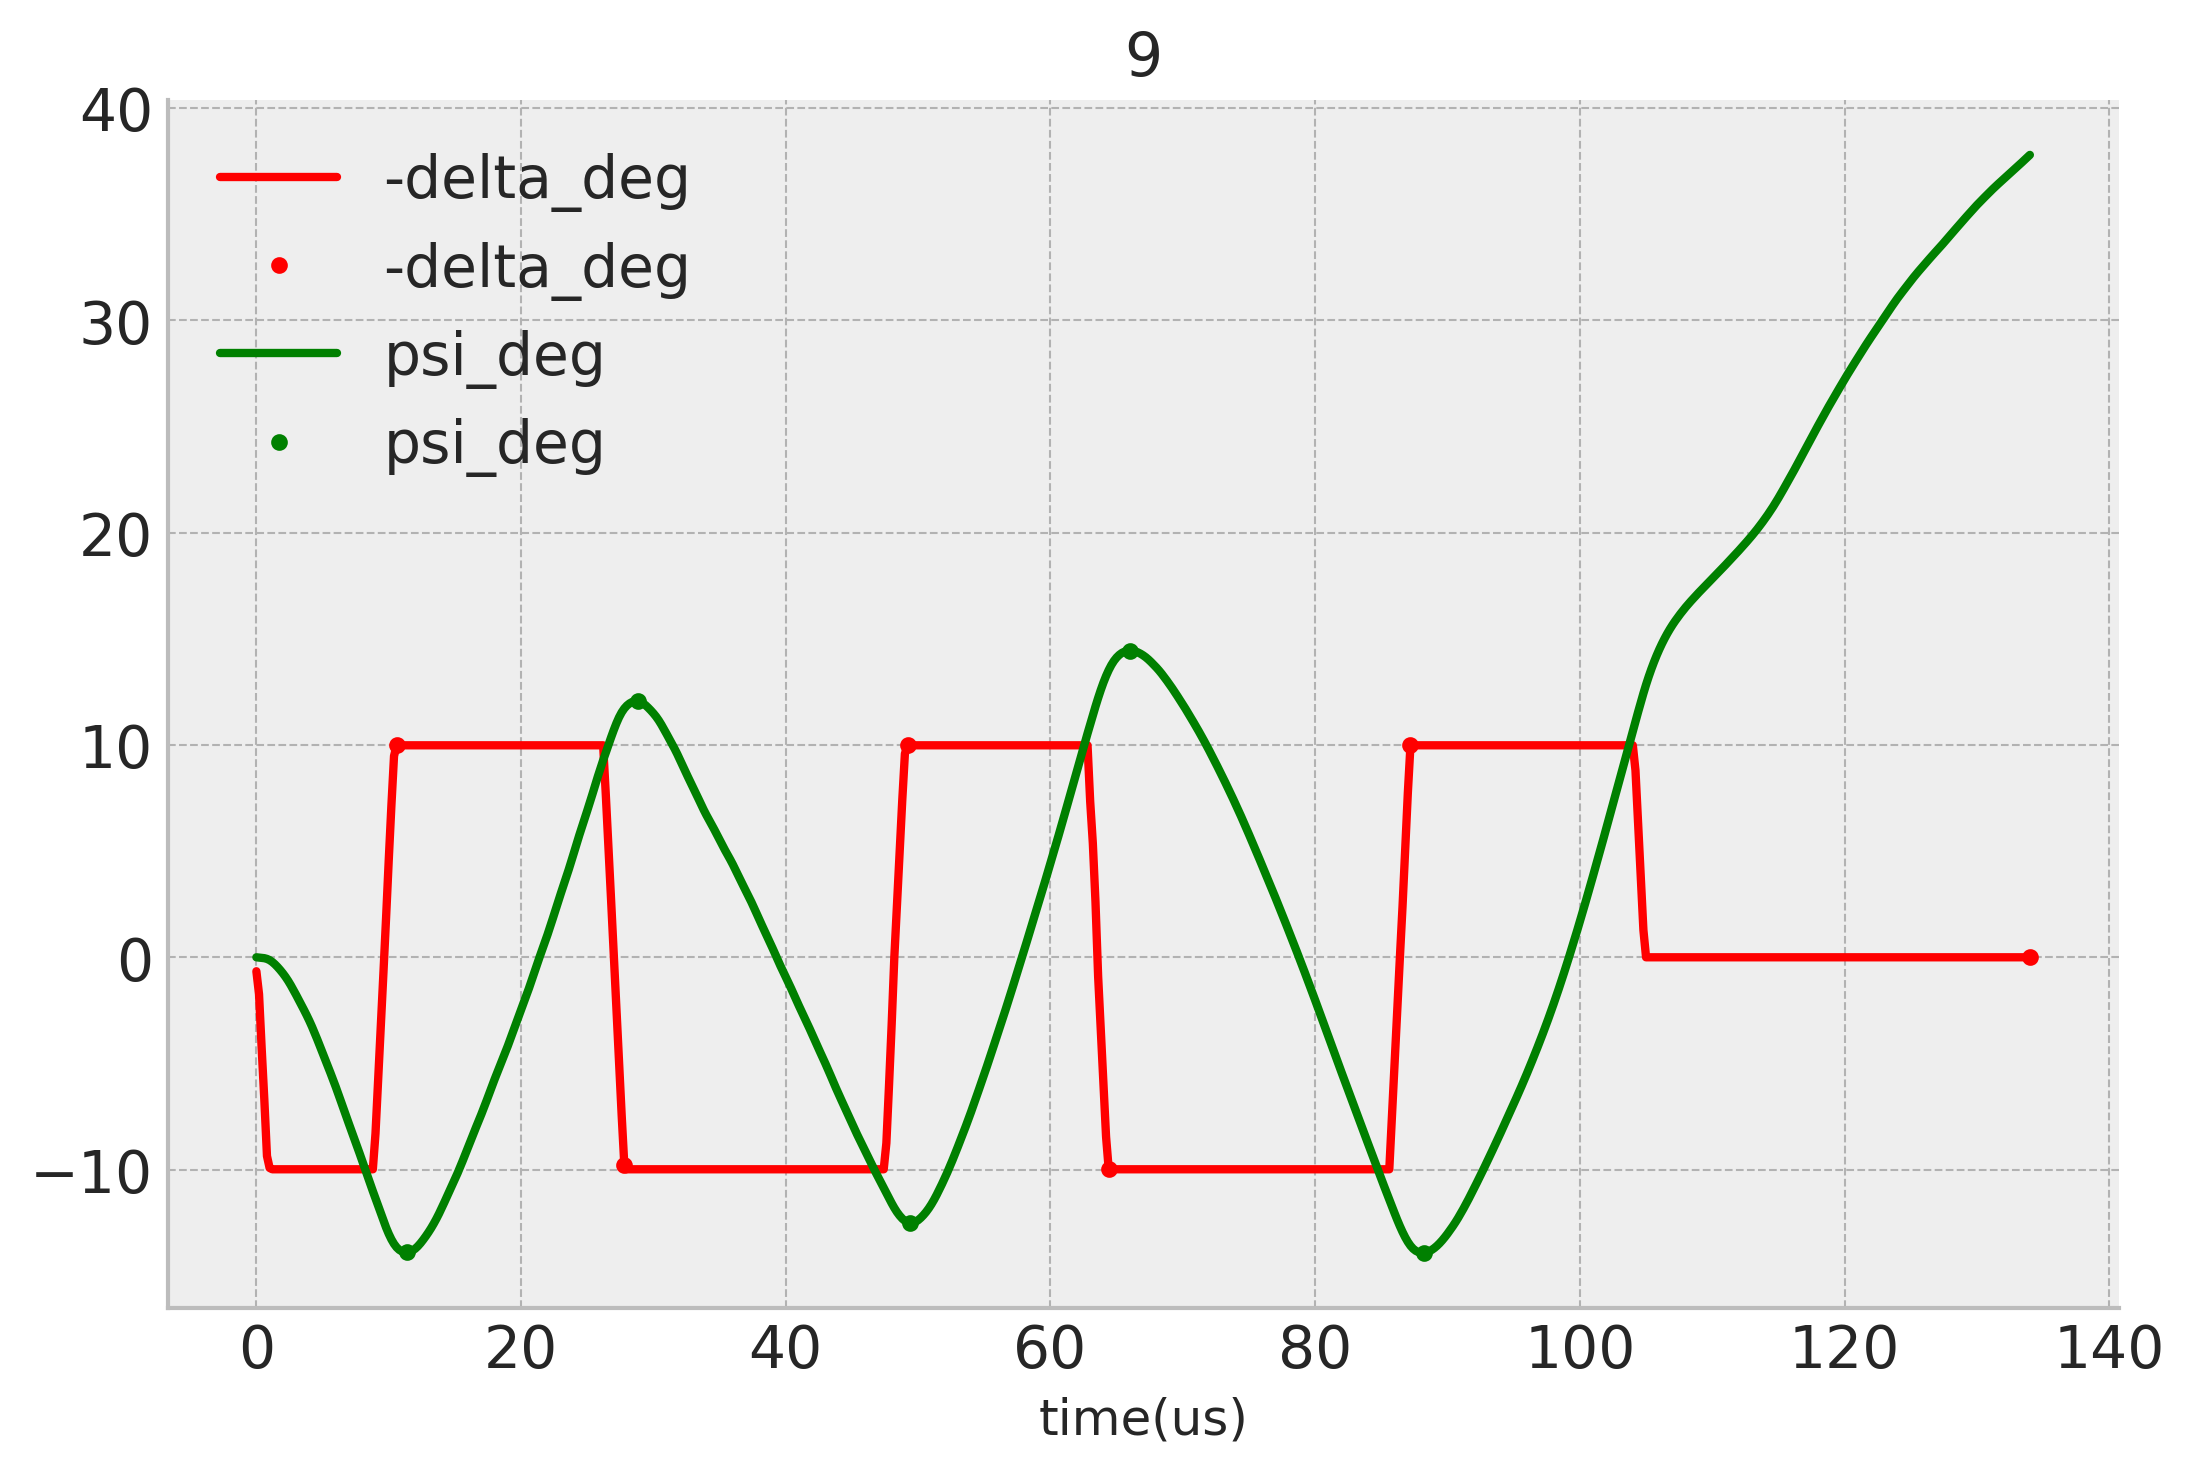

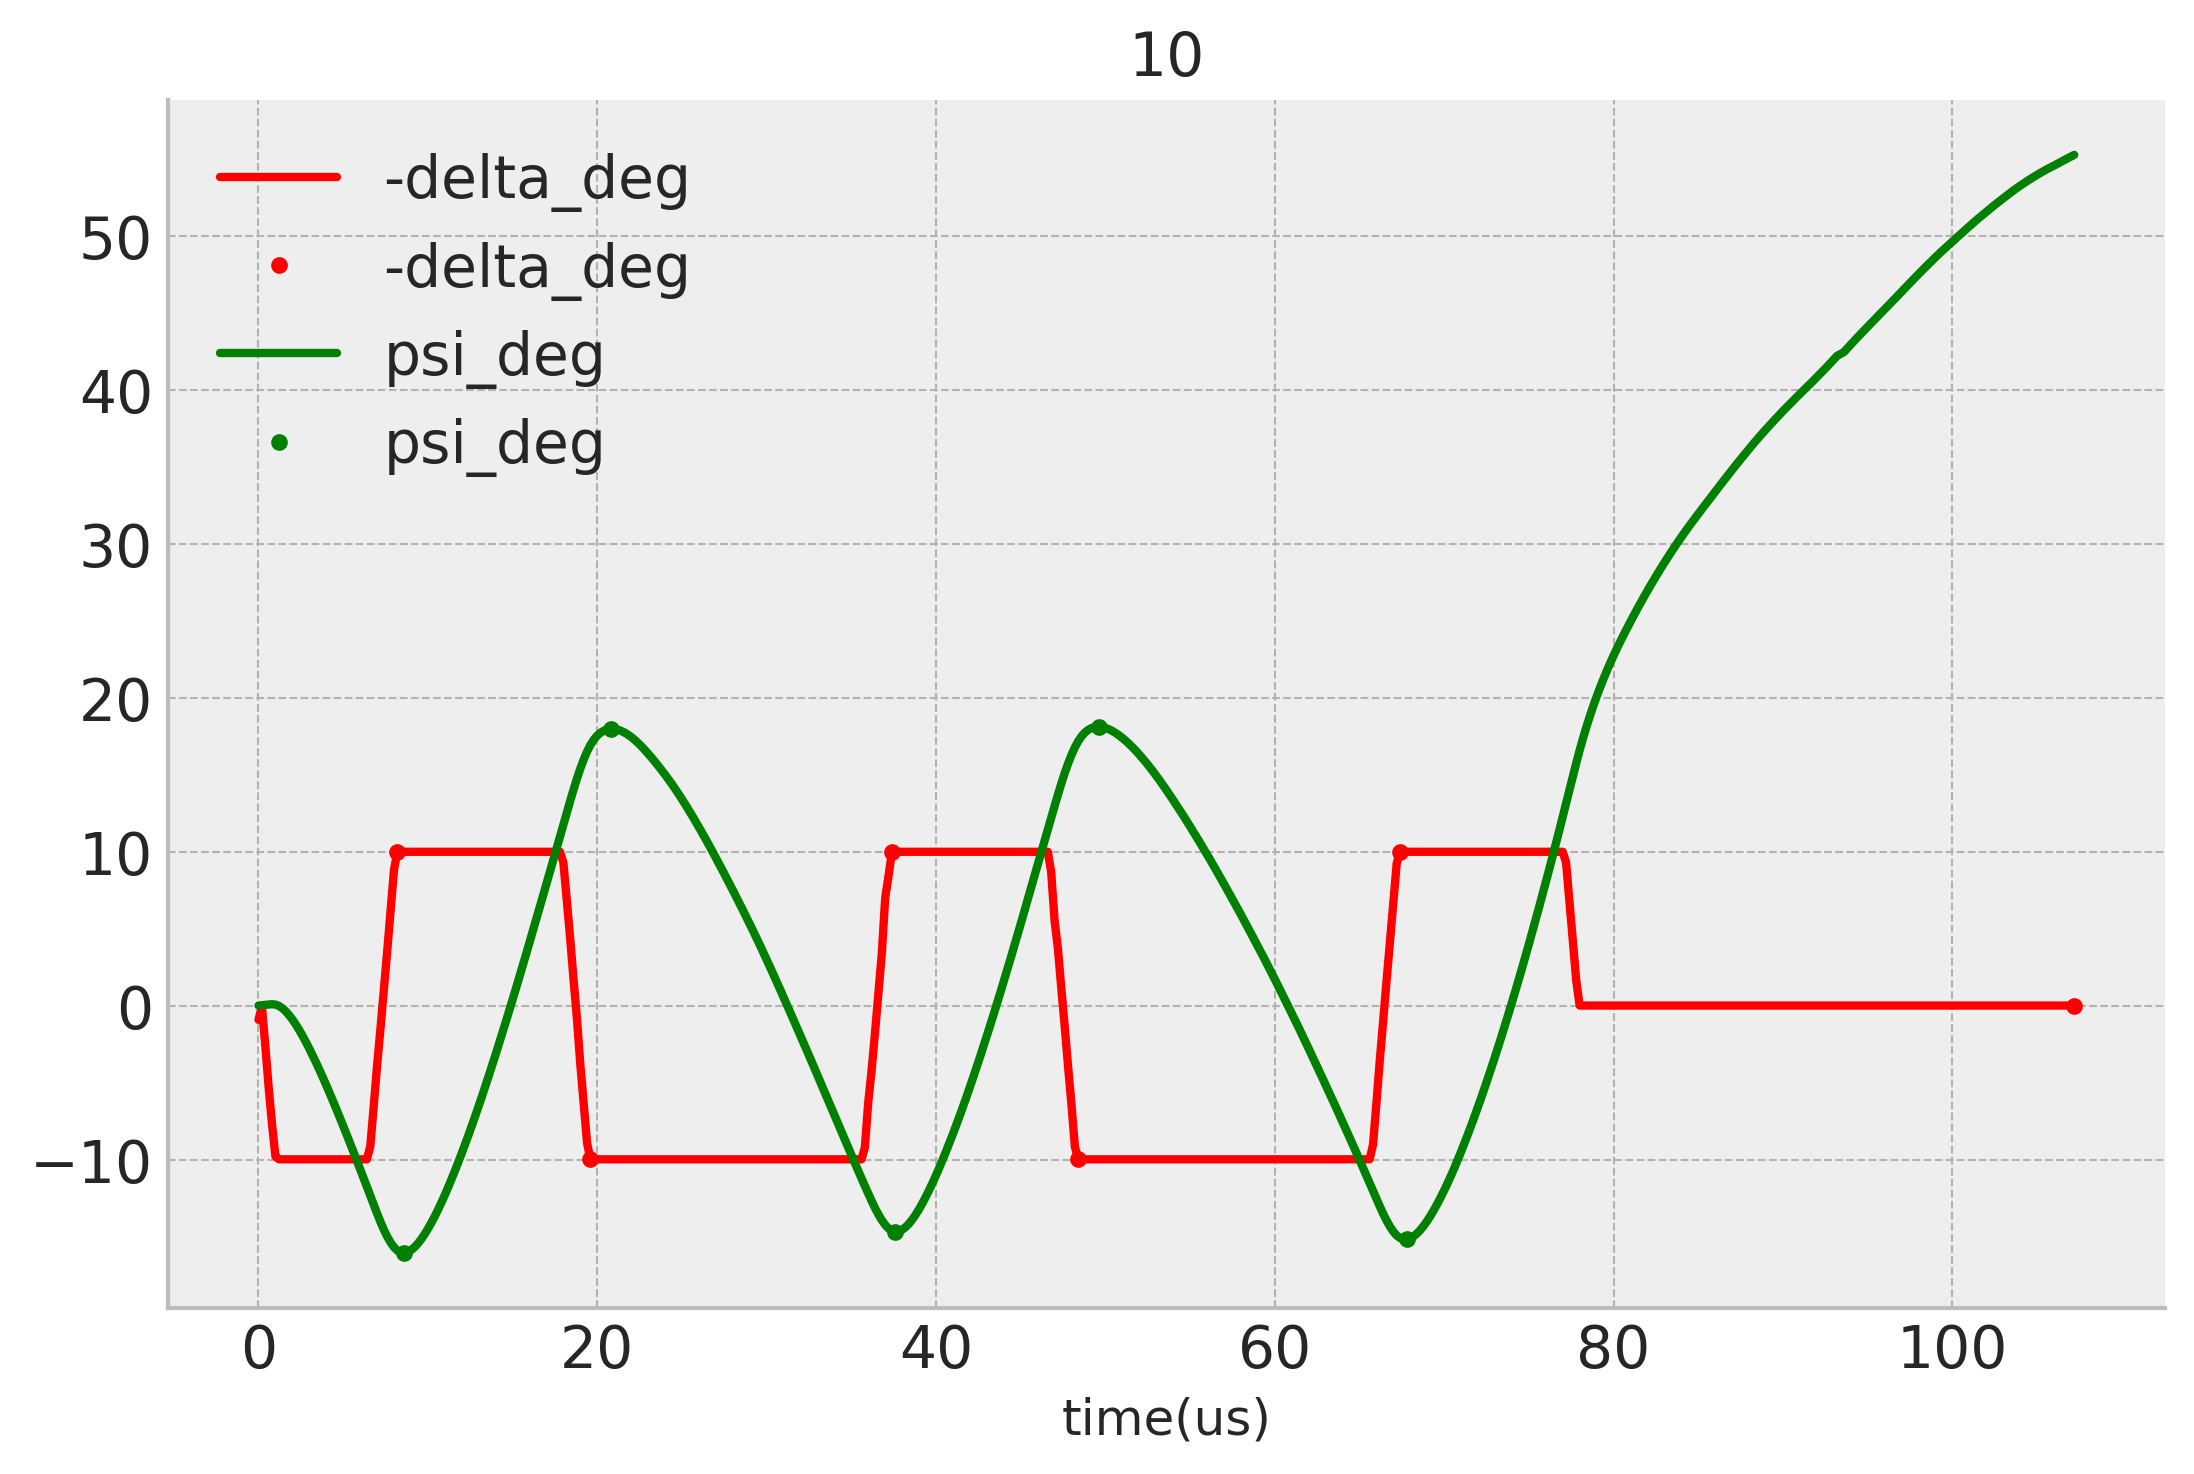

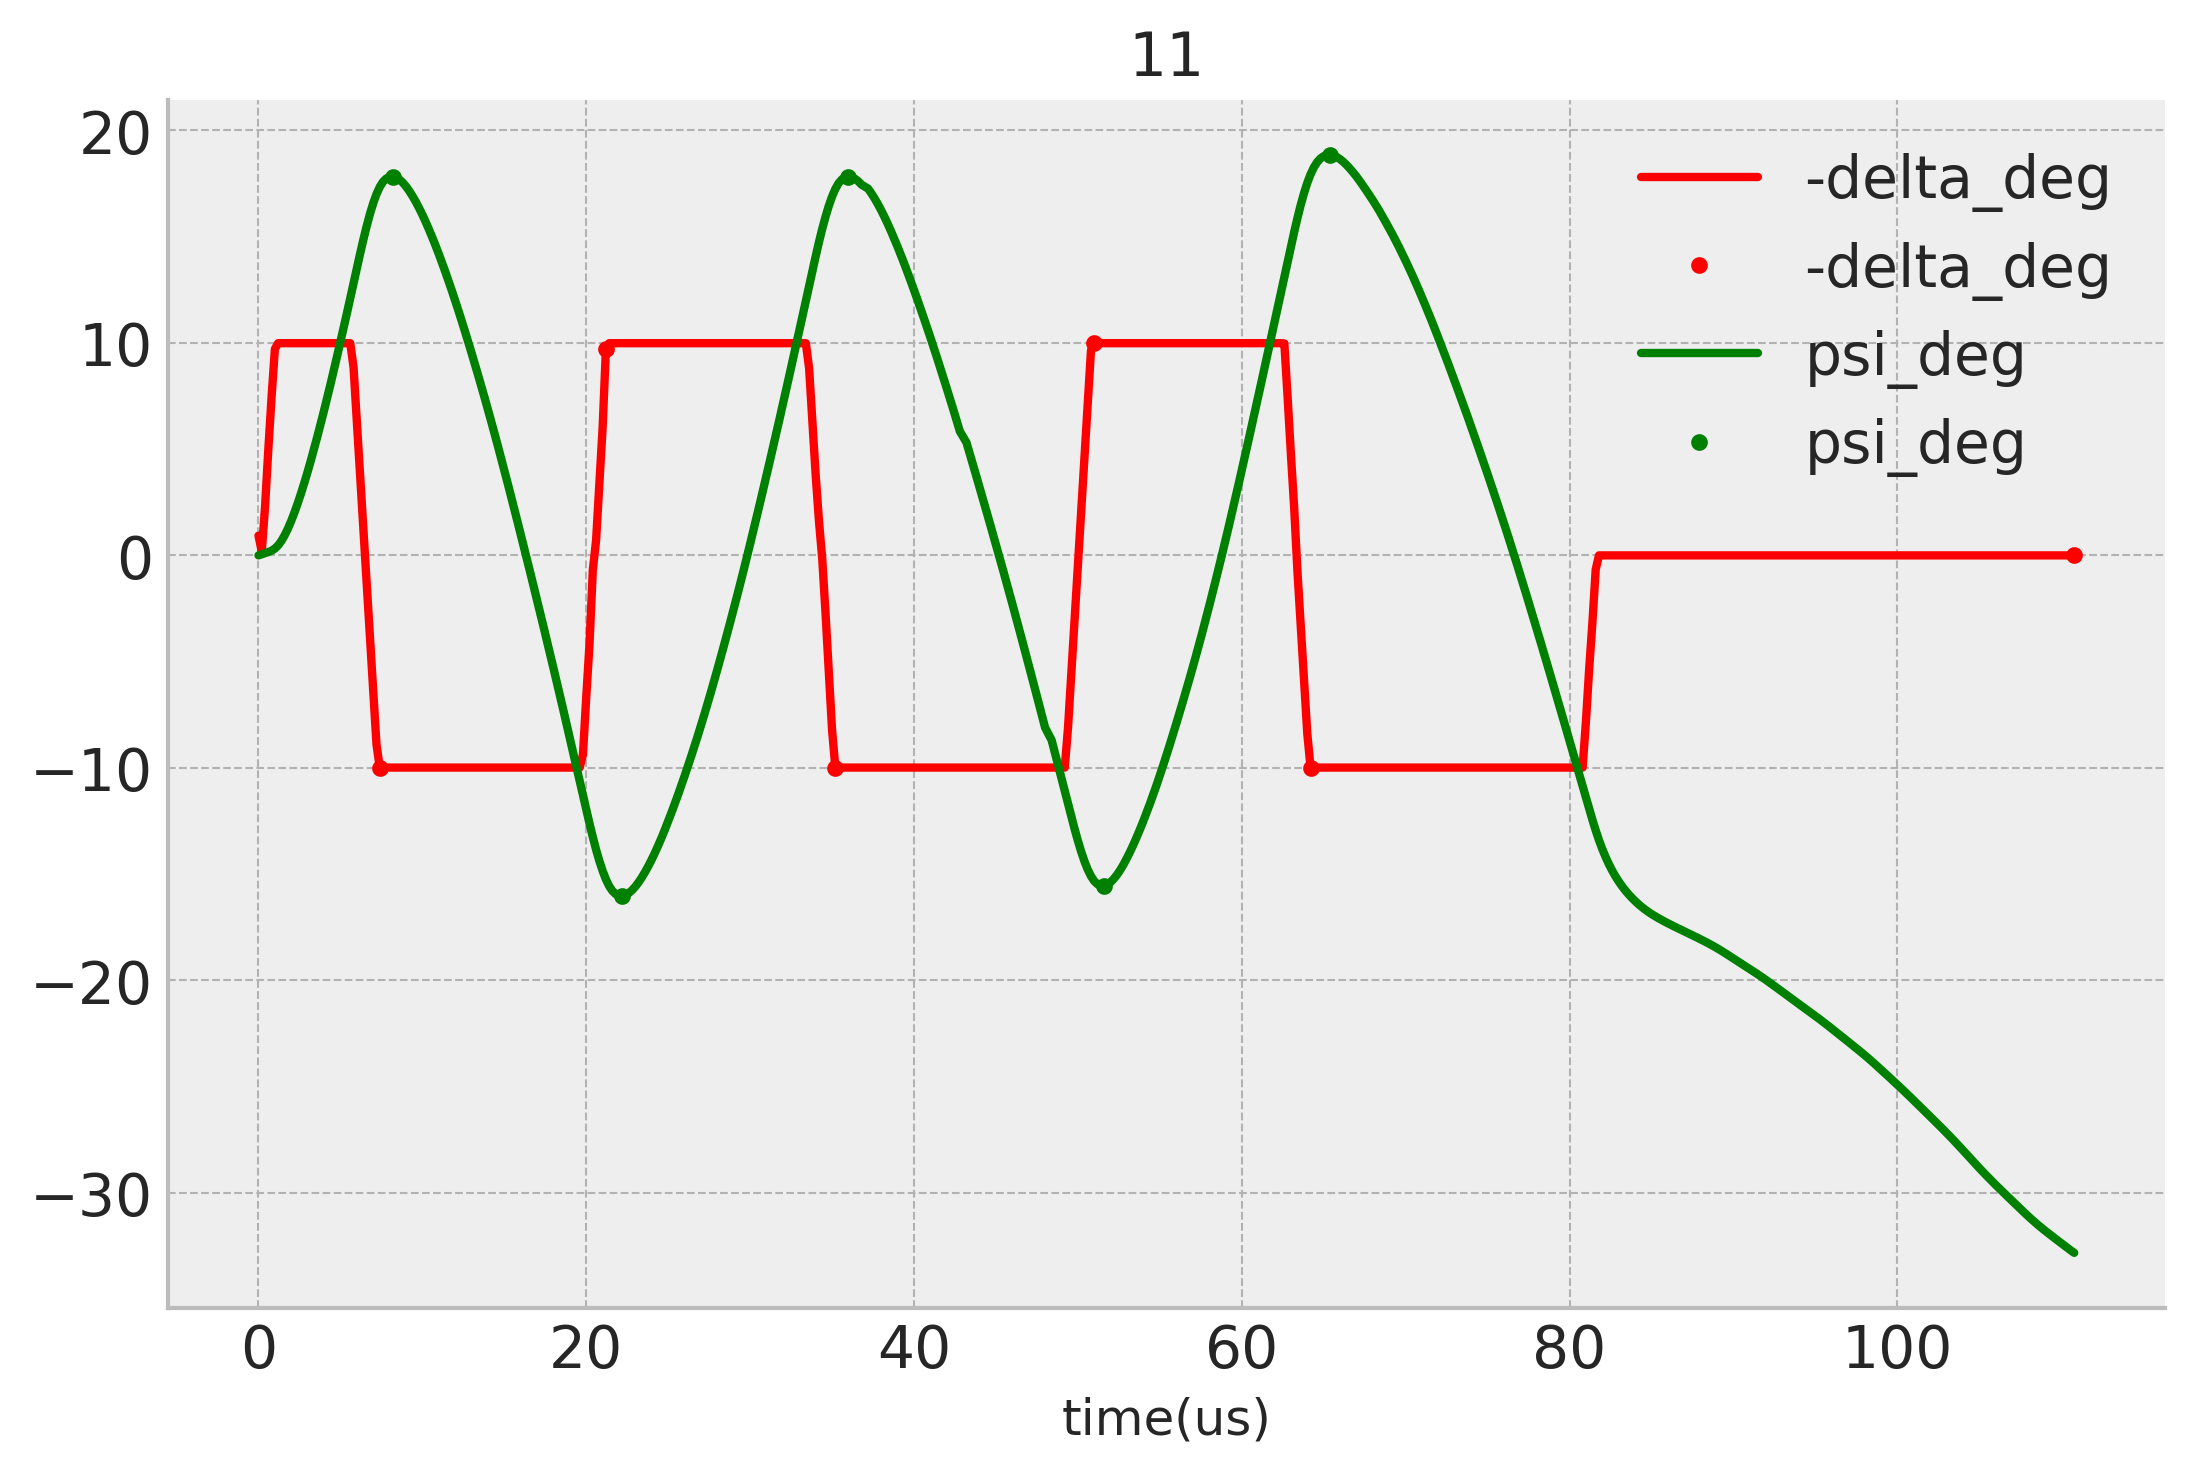

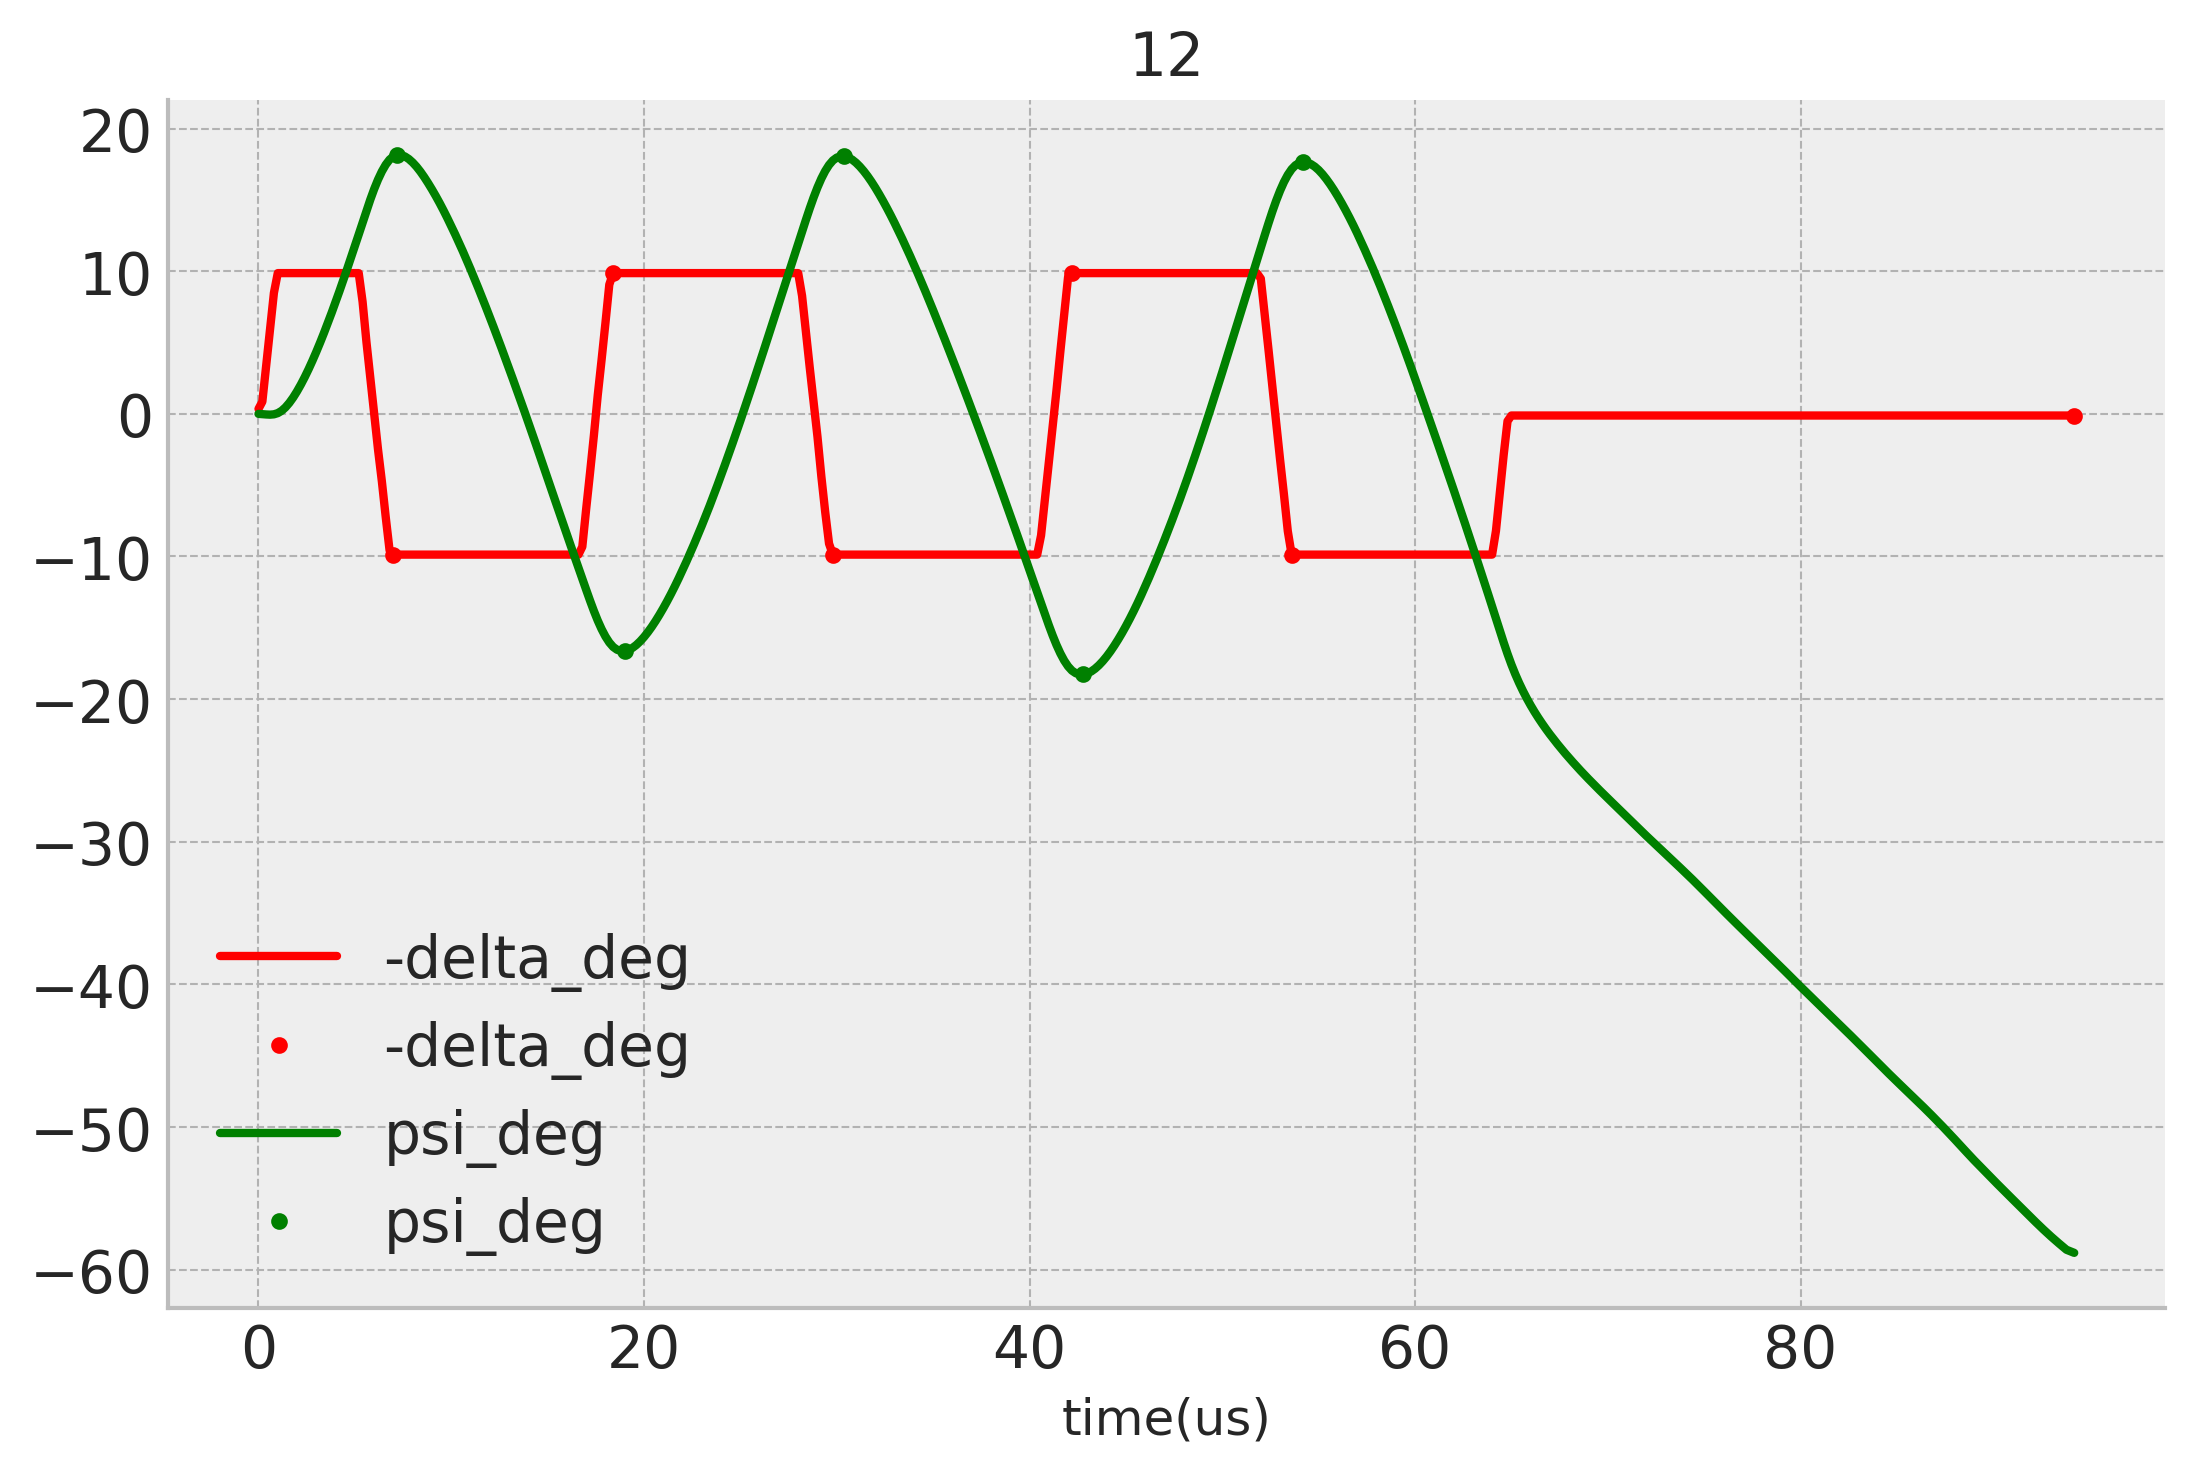

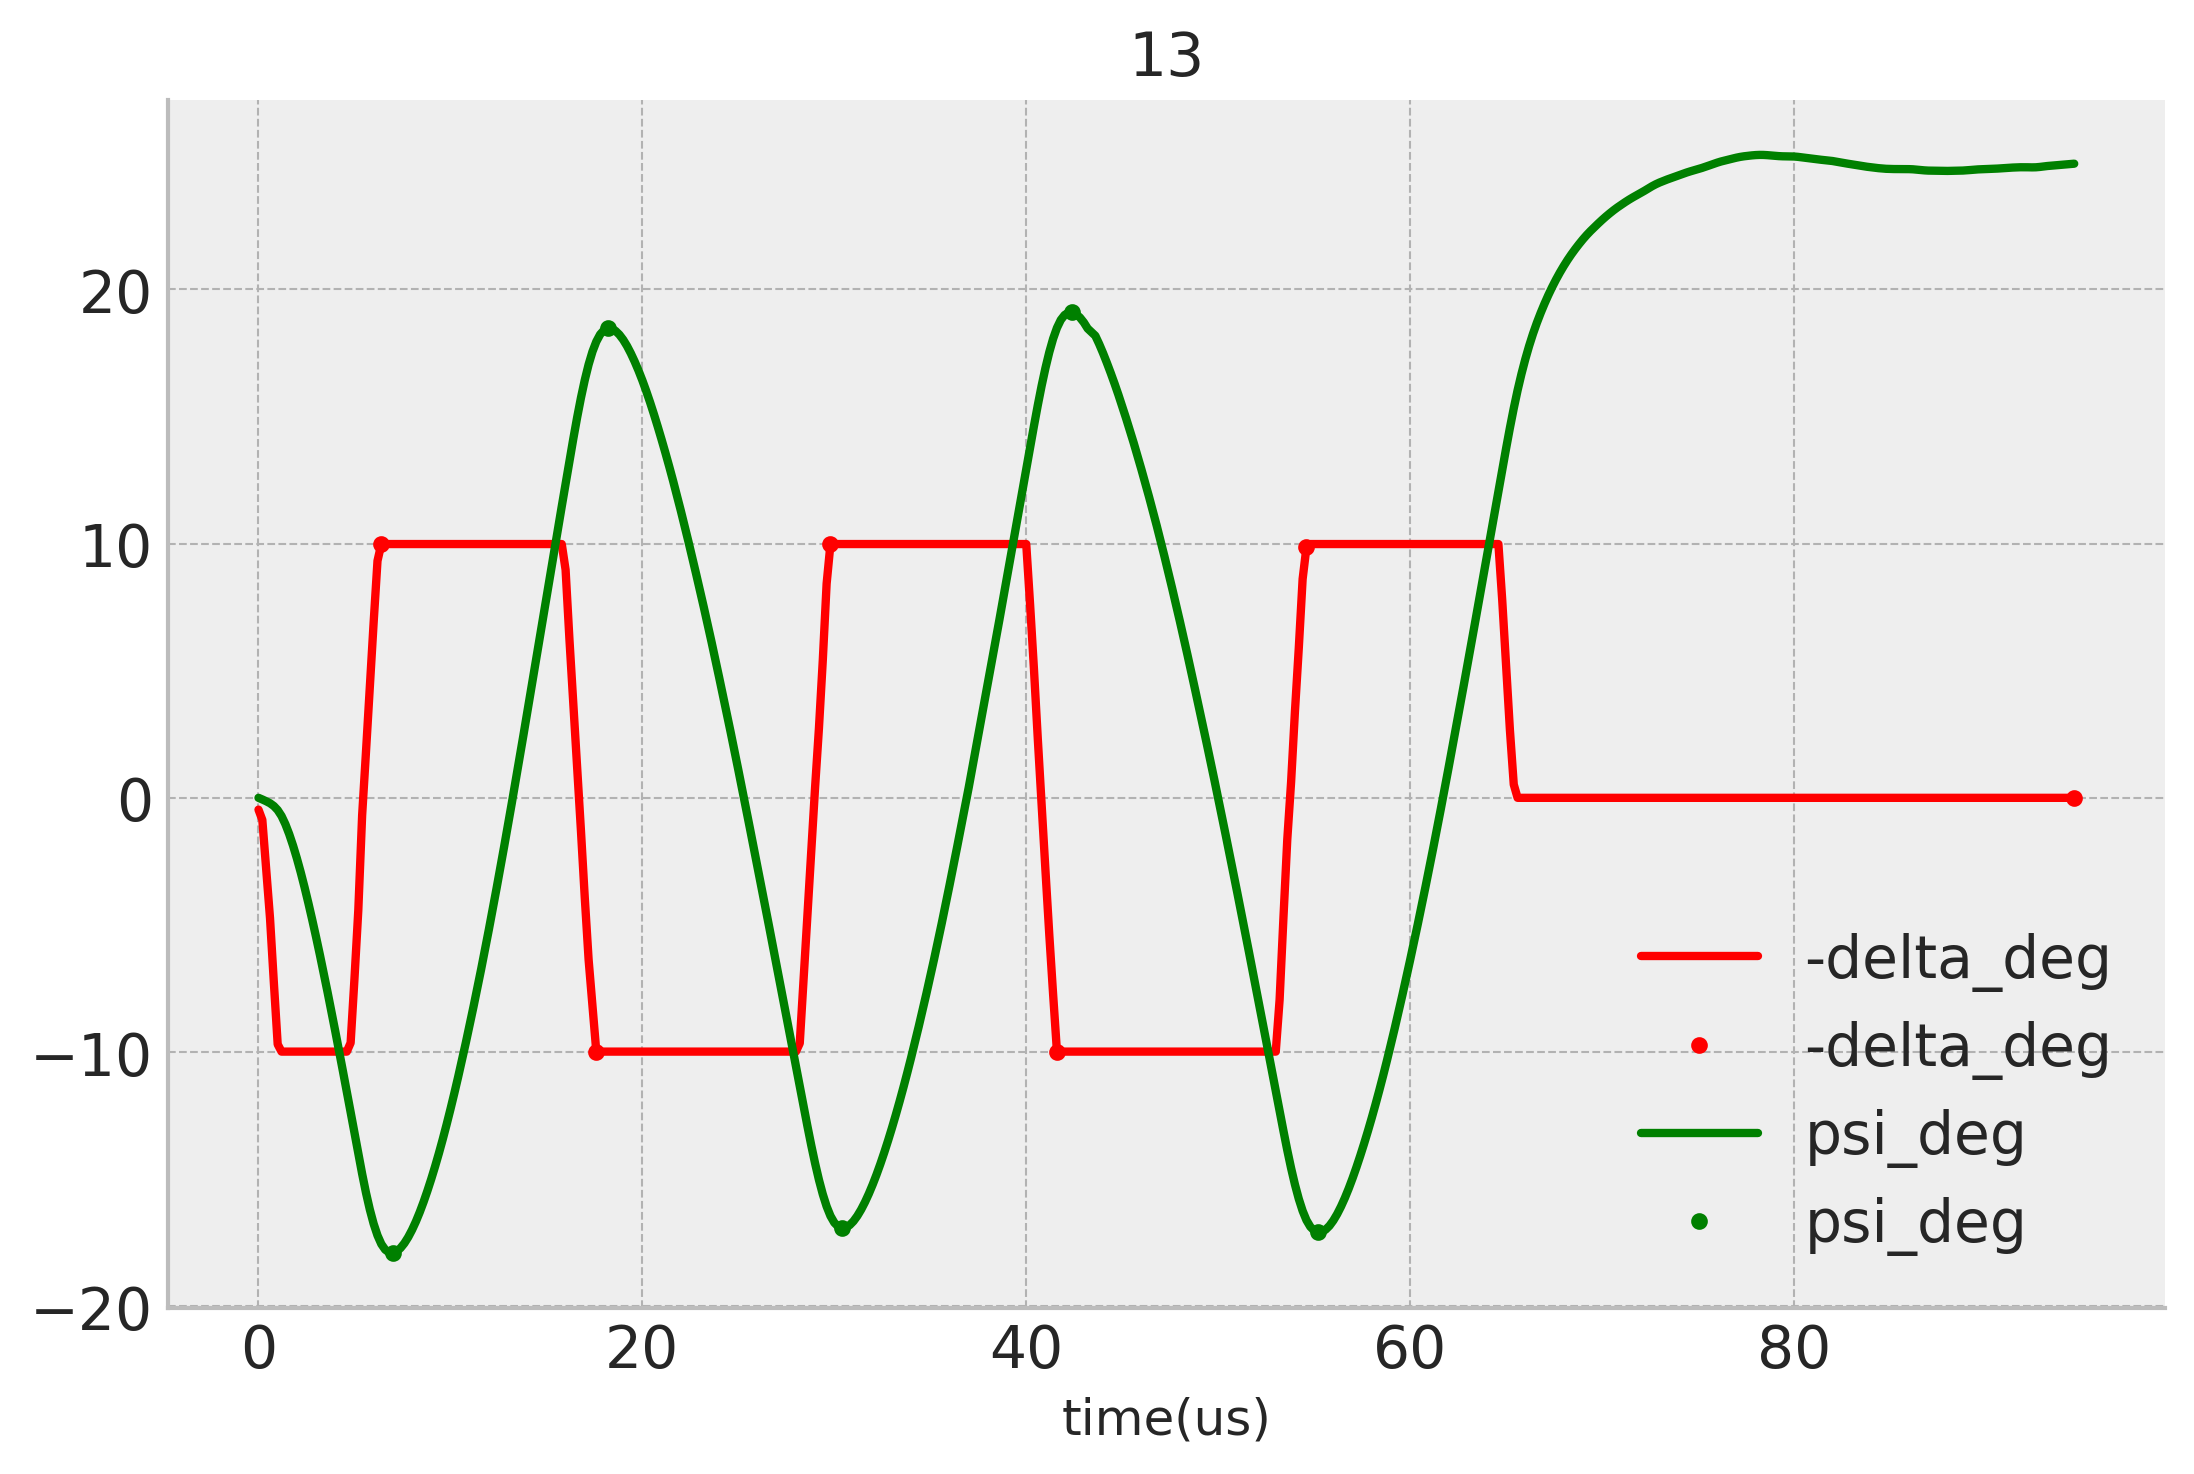

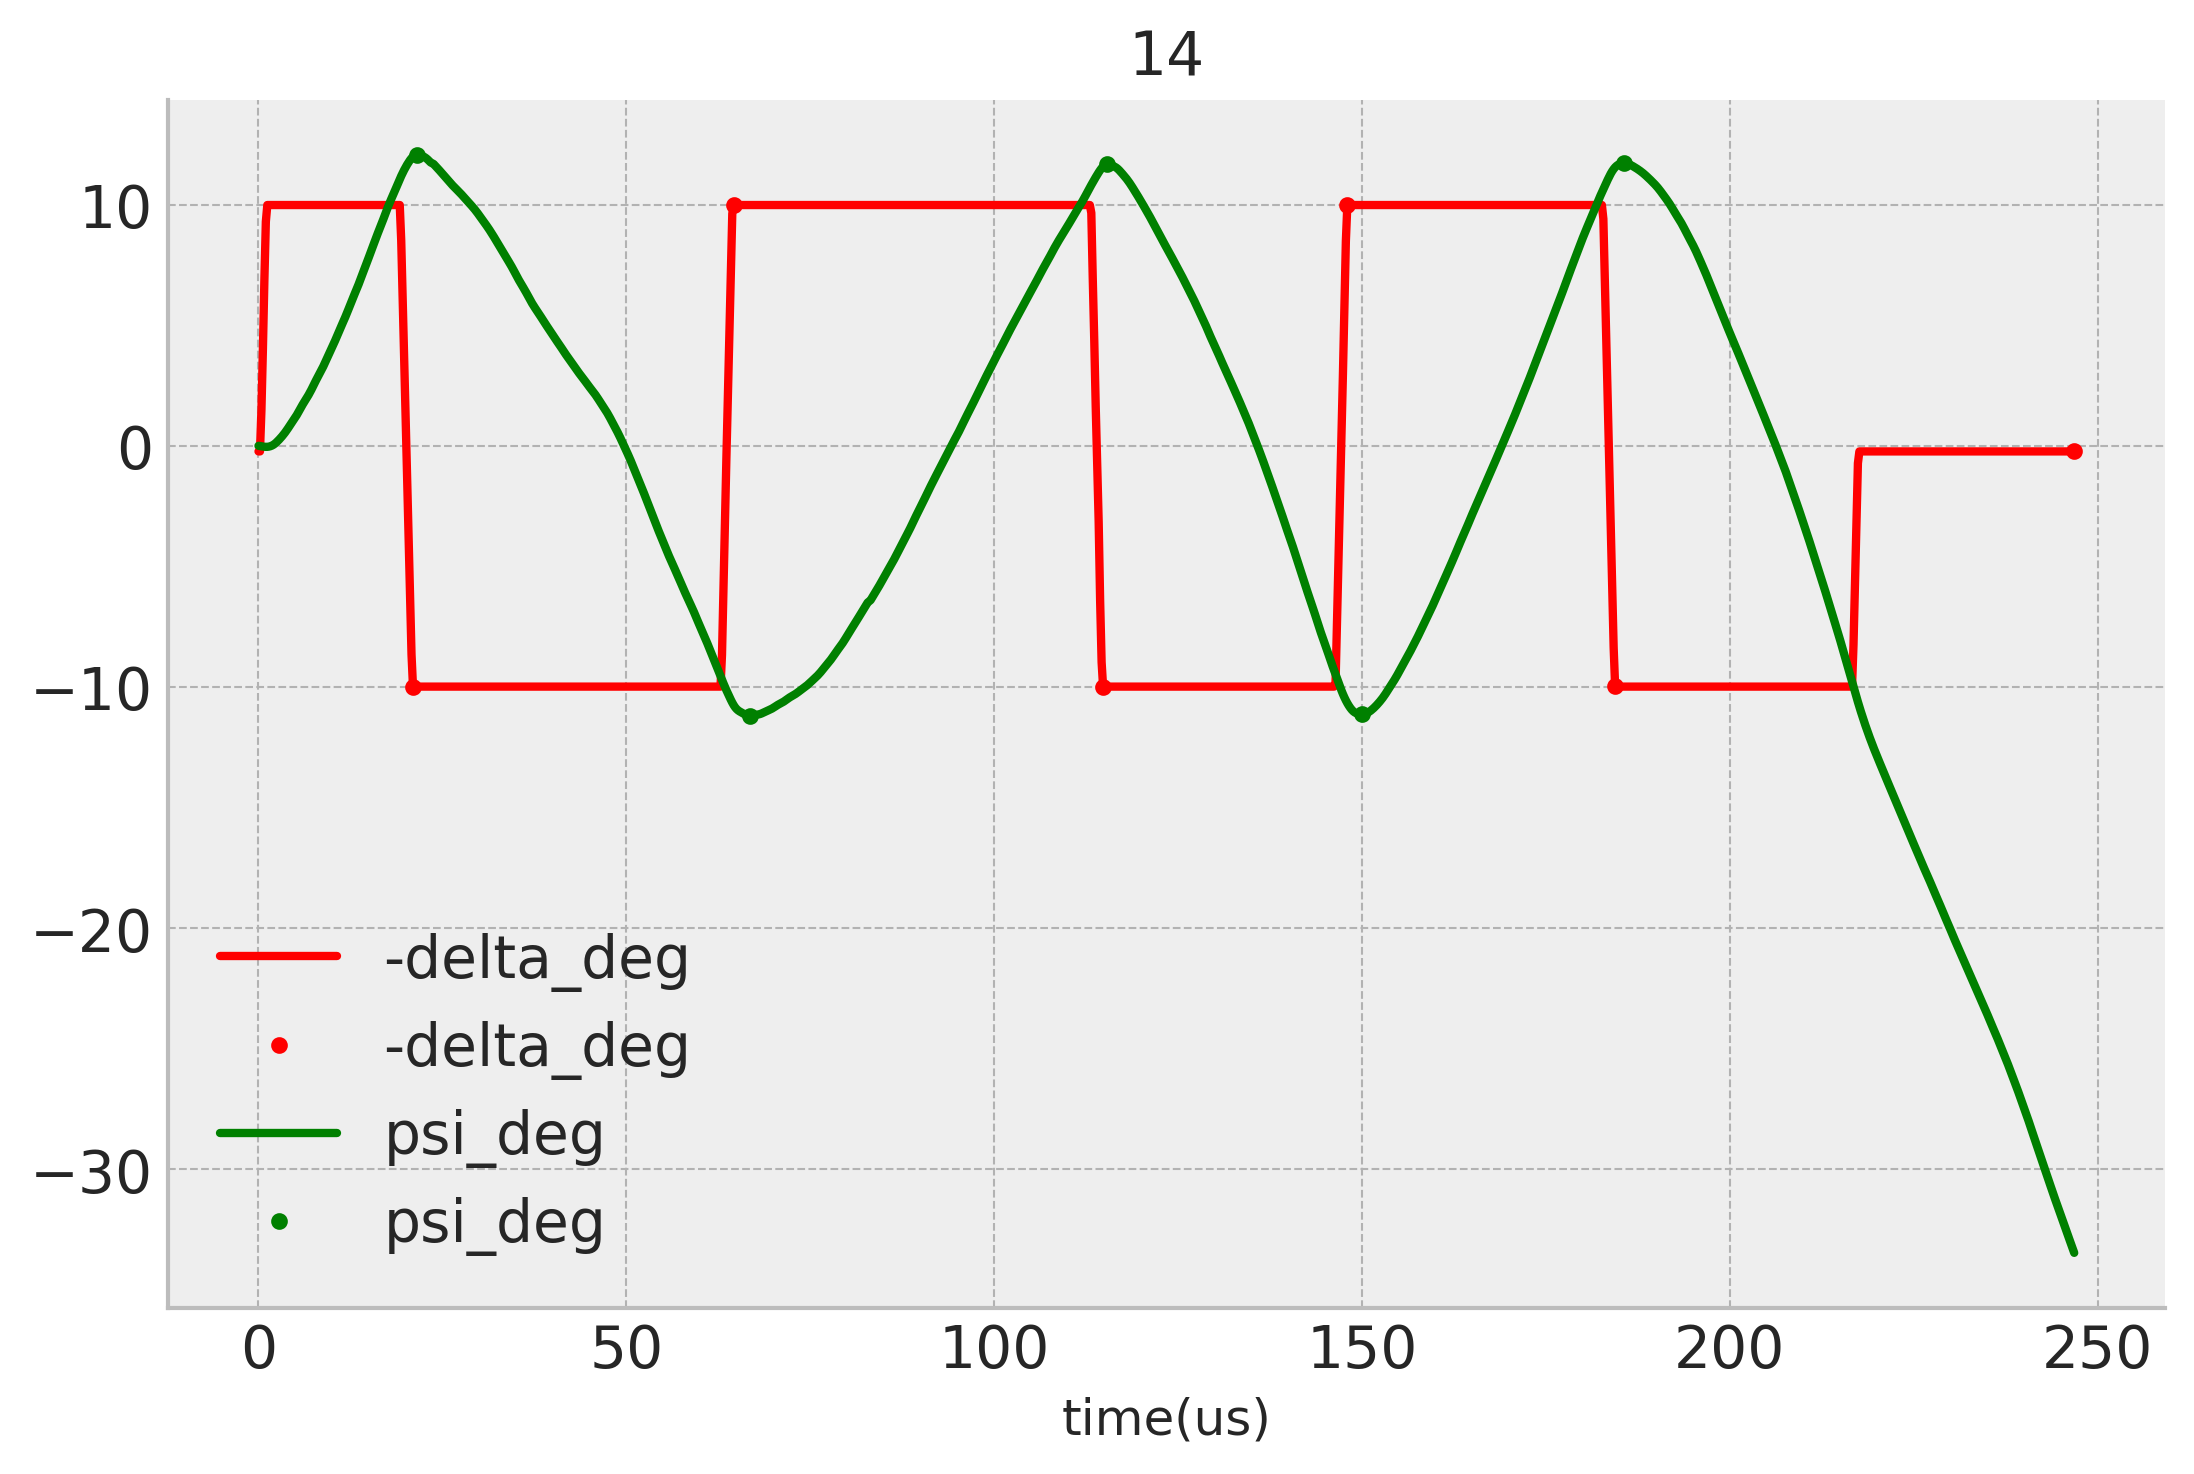

In [29]:
_ = []
mask = time_series_meta_data['type'] == 'zigzag'
time_series_selection = time_series_meta_data.loc[mask].copy()
#time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_field_data(id)
    except:
        continue
     
    df['psi_deg'] = np.rad2deg(df['psi'])
    df['delta']-=(df['delta'].max() + df['delta'].min())/2
    df['-delta_deg']=-np.rad2deg(df['delta'])
    angle = np.round(np.rad2deg((df['delta'].max() - df['delta'].min())/2)/10,0)*10
    
    corners = zigzag._get_corners(angle=np.deg2rad(angle), df=df)
    maximums = zigzag._get_maximums(df=df, corners=corners)
    
    fig,ax=plt.subplots()
    df.plot(y='-delta_deg', style='r-', ax=ax)
    corners.plot(y='-delta_deg', style='r.', ax=ax)
    
    df.plot(y='psi_deg', style='g-', ax=ax)
    maximums.plot(y='psi_deg', style='g.', ax=ax)
    ax.set_title(id)
    
    results = evaluate(df=df, angle=angle)
    results['angle1'] = angle
    _.append(results)
    
evaluations_field_data = pd.DataFrame(_)
evaluations_field_data = pd.merge(left=evaluations_field_data, right=time_series_meta_data.drop(columns=['V']), left_index=True, right_index=True, how='left')

In [30]:
evaluations_field_data.head()

overshoot_1  overshoot_2  overshoot_3  overshoot_4  overshoot_5   period_1   period_2   period_3         V  angle1       yaw       cog       sog  rudderTarget  rudderAngle   latitude  longitude  heelAngle    awaBow    awsBow    twaBow    twsBow  awaStern  awsStern  twaStern  twsStern  thrusterTarget  courseTarget  pitchAngle     GyroX     GyroY     GyroZ    AccelX    AccelY    AccelZ  awaBowRAW  awsBowRAW  twaBowRAW  twsBowRAW  awaSternRAW  awsSternRAW  twsSternRAW     delta       psi       phi     theta       y_GPS        x_GPS           x0          y0         u         v         r       u1d       v1d       r1d       aws       awa         U      beta       tws       twa  zigzag_test_id  inbetween_zigzags_id                       date                                           missions    type              time_series  twsSternRAW   mission
0     9.042492    12.336588     9.541449    12.517000     7.439664  10.599841  11.399841  10.799889  2.502891    10.0 -2.864242 -2.889714  2.234649      2.868355     2.832776  59.290854  18.324044   0.011661 -0.058411  1.826679 -3.087927  0.716626 -0.118637  1.810751 -3.054401  0.748773           100.0     -3.127585    0.009372  0.001654 -0.000898  0.017665  0.109068 -0.097567 -9.823668  -0.058420   1.811687  -2.989640   0.715064    -0.119148     1.805596     0.741702 -0.049476 -2.864242  0.011661  0.009372  330.864004  1292.087658  1289.644522  330.626305  2.213394 -0.056214  0.017060 -0.003191 -0.002605  0.000107  1.808642 -0.086549  2.223344  0.025849  0.697867  0.252704             0.0                   NaN 2021-04-28 10:27:01.224843  ZigZag: start (59.29170990,18.32409477),ZigZag...  zigzag  01_motoring_7m_all_data           NaN      NaN
1     9.373942    14.801140    10.666155    13.550887     9.017555  11.599835  11.199851  12.599800  2.280803    10.0  2.976625  2.998904  2.168764      1.477648     1.630257  59.282847  18.322966   0.022045 -0.282939  6.409136 -0.453019  4.581796 -0.283185  5.890818 -0.491481  4.070700           100.0     -3.141585    0.008296  0.001285 -0.001100 -0.008247  0.114604 -0.222498 -9.828266  -0.258706   6.441708  -0.427223   4.606597    -0.256902     5.943986     4.109235 -0.028388  2.976625  0.022045  0.008296  263.751884   400.585296   398.123112  264.646209  2.134177  0.042547 -0.008983  0.000275  0.000605 -0.000225  6.192847 -0.257964  2.143850 -0.020857  4.359494  2.578117             1.0                   NaN 2021-04-28 10:41:19.614095  ZigZag: start (59.28369141,18.32298660),ZigZag...  zigzag  01_motoring_7m_all_data           NaN      NaN
2    10.422892     7.015131    11.015980     7.073513     9.625066  10.999864  12.399811  12.199831  2.204374    10.0 -0.018528 -0.013551  2.038934      3.097150     3.048385  59.286838  18.323604   0.013129 -3.125625  0.945938  3.056870  2.539891  3.102171  1.002460  3.092492  2.561186            80.0     -0.174485    0.006784  0.001729 -0.000705  0.006267  0.085932 -0.144246 -9.816204   3.088457   0.998176   3.052197   2.545398     3.016688     1.043875     2.553118 -0.053224 -0.018528  0.013129  0.006784  302.978464   844.904568   847.541383  302.445856  2.017471  0.012468  0.005269 -0.000062  0.001371 -0.000106  1.021025  3.091711  2.025568 -0.005463  2.572108  3.018951             2.0                   NaN 2021-04-28 10:49:38.207640  ZigZag: start (59.28599167,18.32381248),ZigZag...  zigzag  01_motoring_7m_all_data           NaN      NaN
3     9.463899     6.951007     9.281892     6.181635     9.996262  10.599913  12.399818  10.599820  2.151340    10.0 -0.380535 -0.331138  2.017676      1.157022     1.210832  59.290528  18.322799   0.020048  1.498830  0.671117 -3.116795  2.194133  0.478455  0.764705  3.121852  2.015721            80.0     -0.174485    0.007668  0.002284 -0.000954 -0.008573  0.084852 -0.204163 -9.815556   0.521966   0.712779  -3.120169   2.232912    -0.111416     0.802591     2.050055 -0.021130 -0.380535  0.020048  0.007668  259.700598  1256.254169  1258.481638  258.293331  1.987480  0.098440 

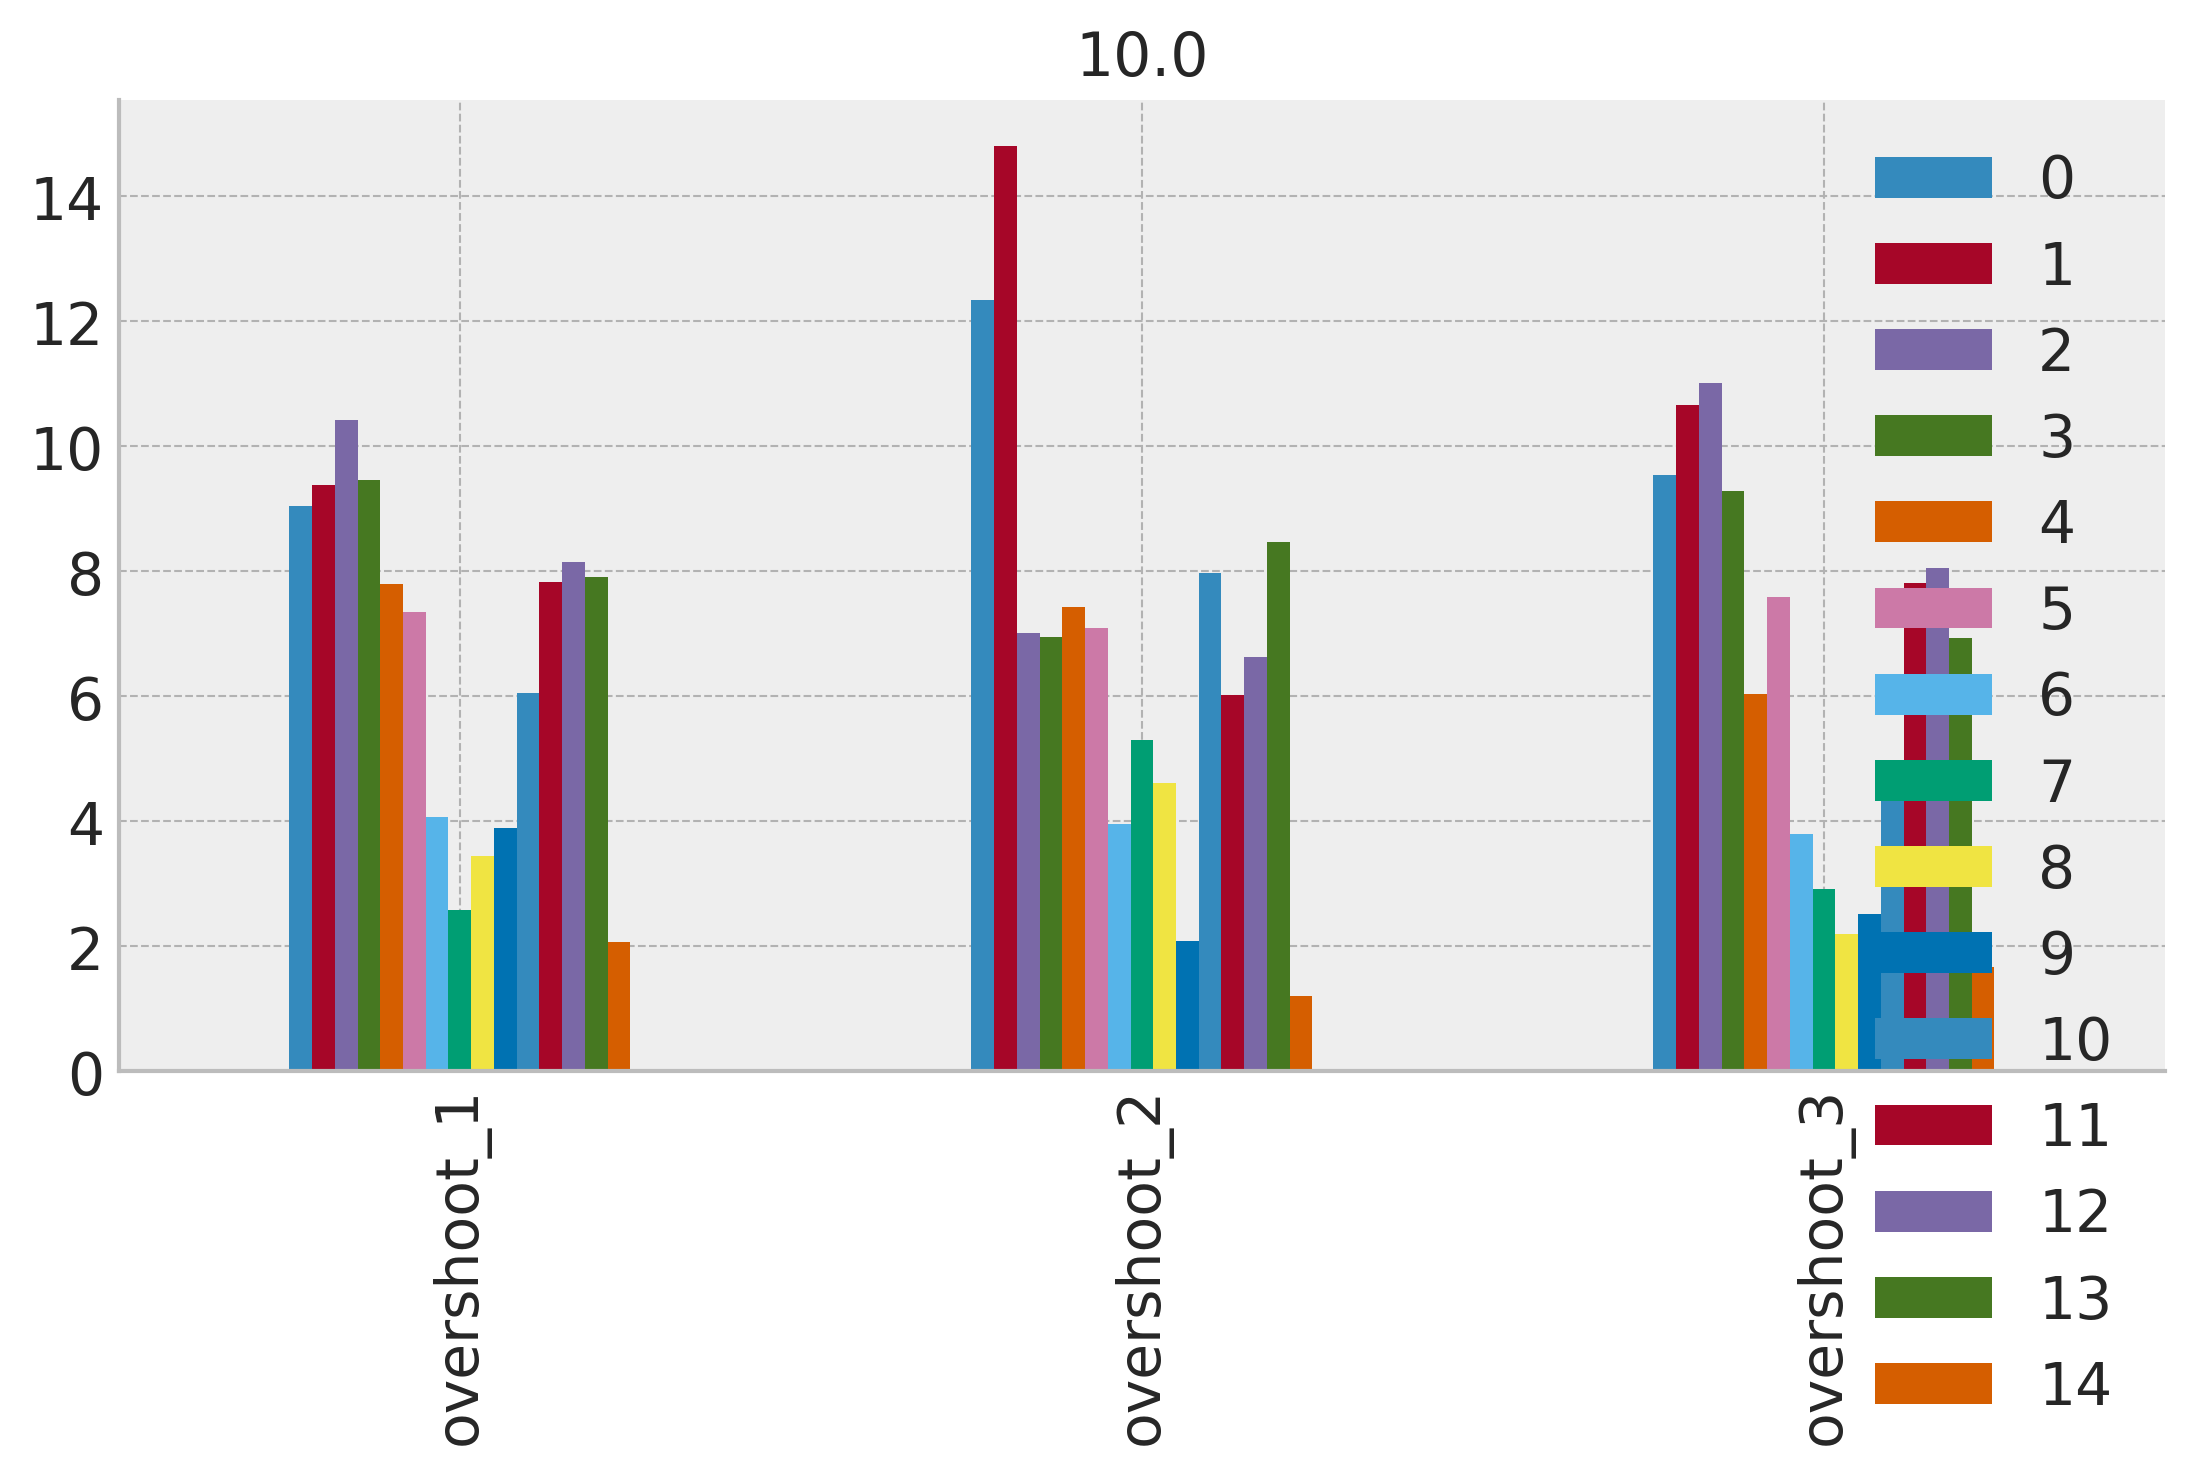

In [31]:
for angle, group in evaluations_field_data.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2','overshoot_3']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

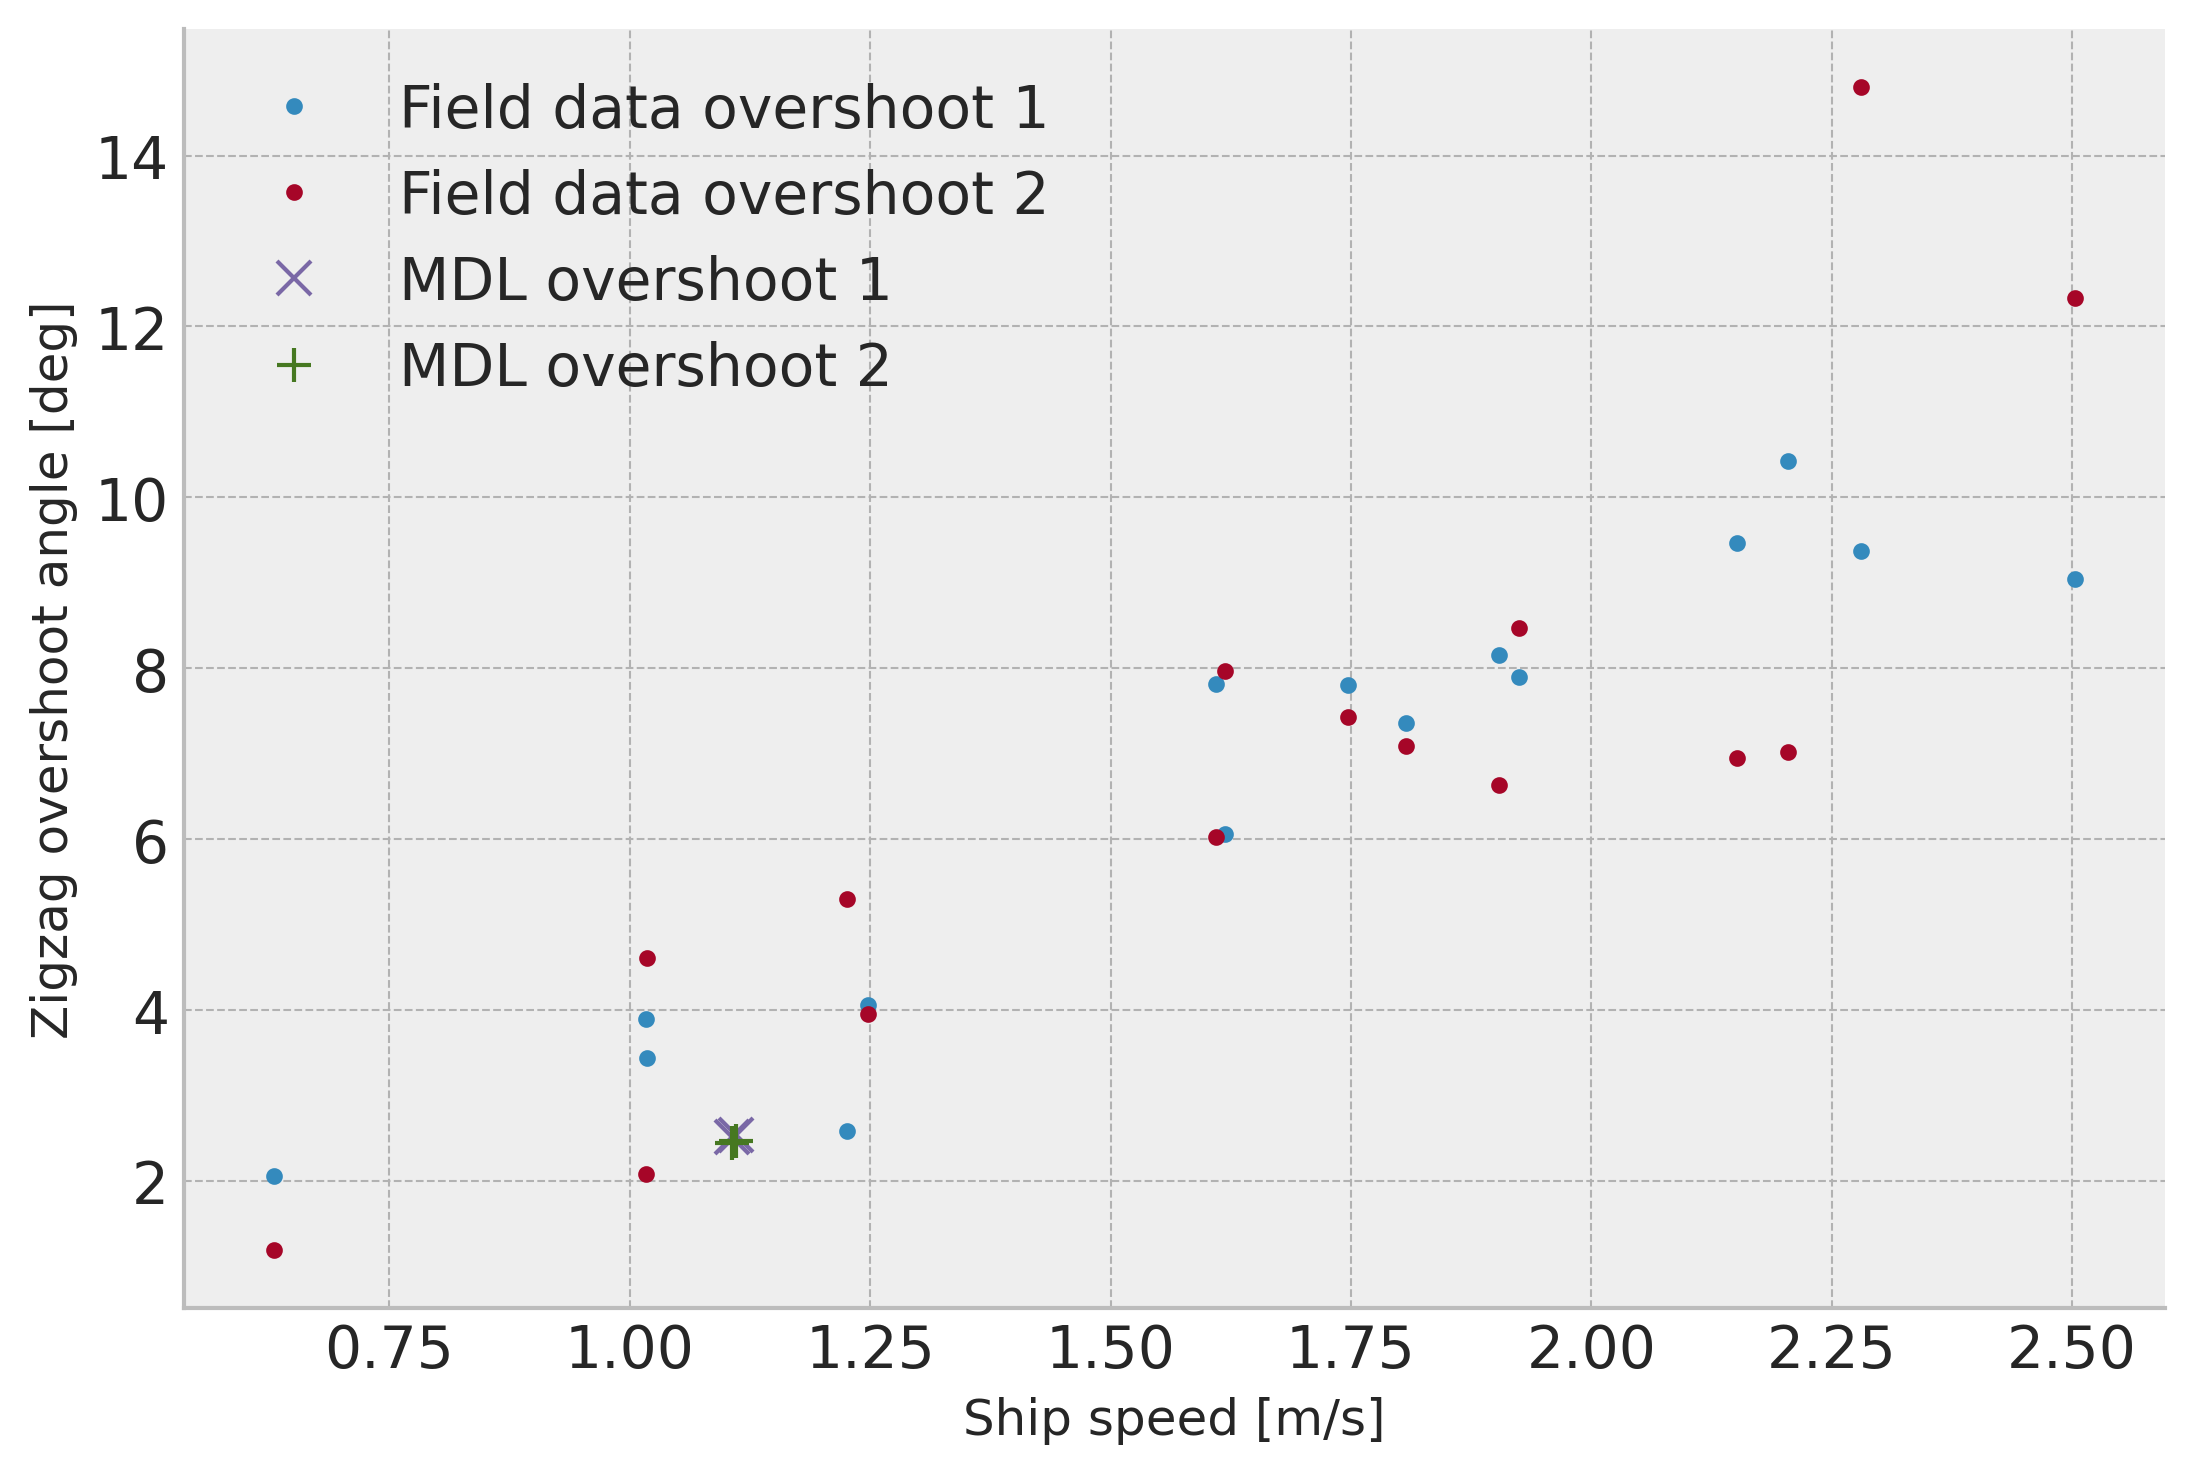

In [32]:
fig,ax=plt.subplots()
evaluations_field_data.plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['Field data overshoot 1','Field data overshoot 2'], style='.', ax=ax)
evaluations_MDL.groupby(by='angle1').get_group(10).plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['MDL overshoot 1','MDL overshoot 2'], style=['x','+'], ms=8, ax=ax)
ax.set_ylabel('Zigzag overshoot angle [deg]')
ax.set_xlabel('Ship speed [m/s]')
paper.save_fig(fig, file_name="overshoots.pdf")

In [33]:
mask = evaluations_field_data['V'].between(2.17,2.50)
df_selection = evaluations_field_data.loc[mask]

df_selection[['V','aws','overshoot_1','overshoot_2']]

V       aws  overshoot_1  overshoot_2
1  2.280803  6.192847     9.373942    14.801140
2  2.204374  1.021025    10.422892     7.015131

<Axes: xlabel='V'>

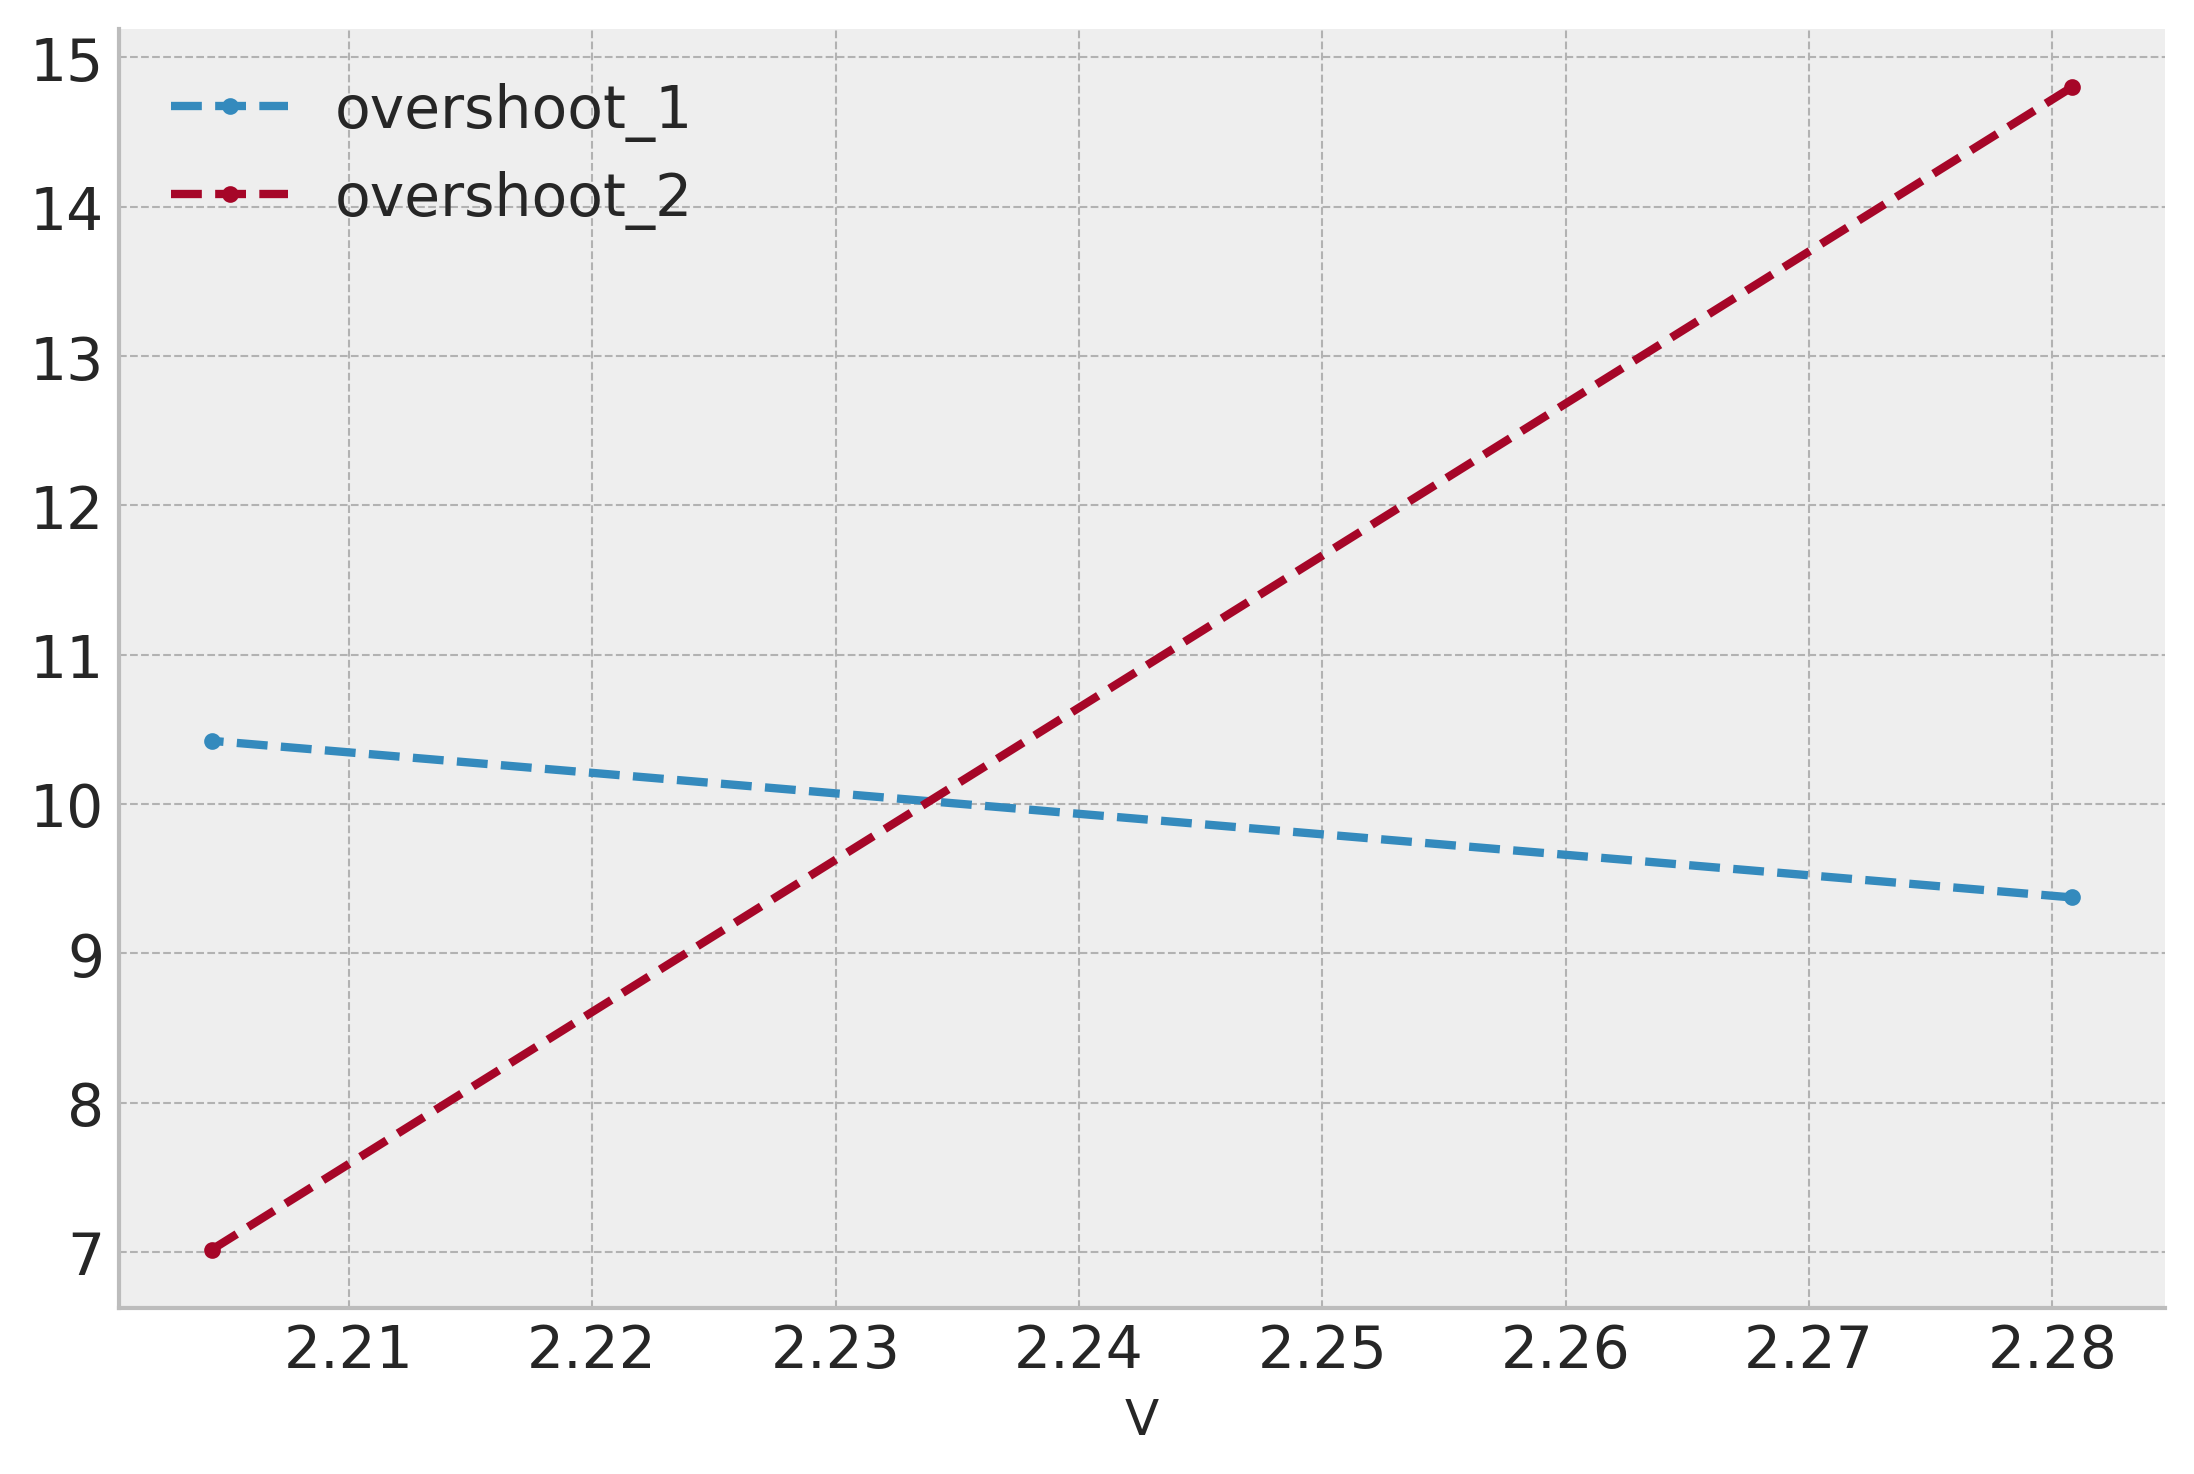

In [34]:
df_selection.plot(x='V', y=['overshoot_1','overshoot_2'],style='--.')

<Axes: xlabel='aws'>

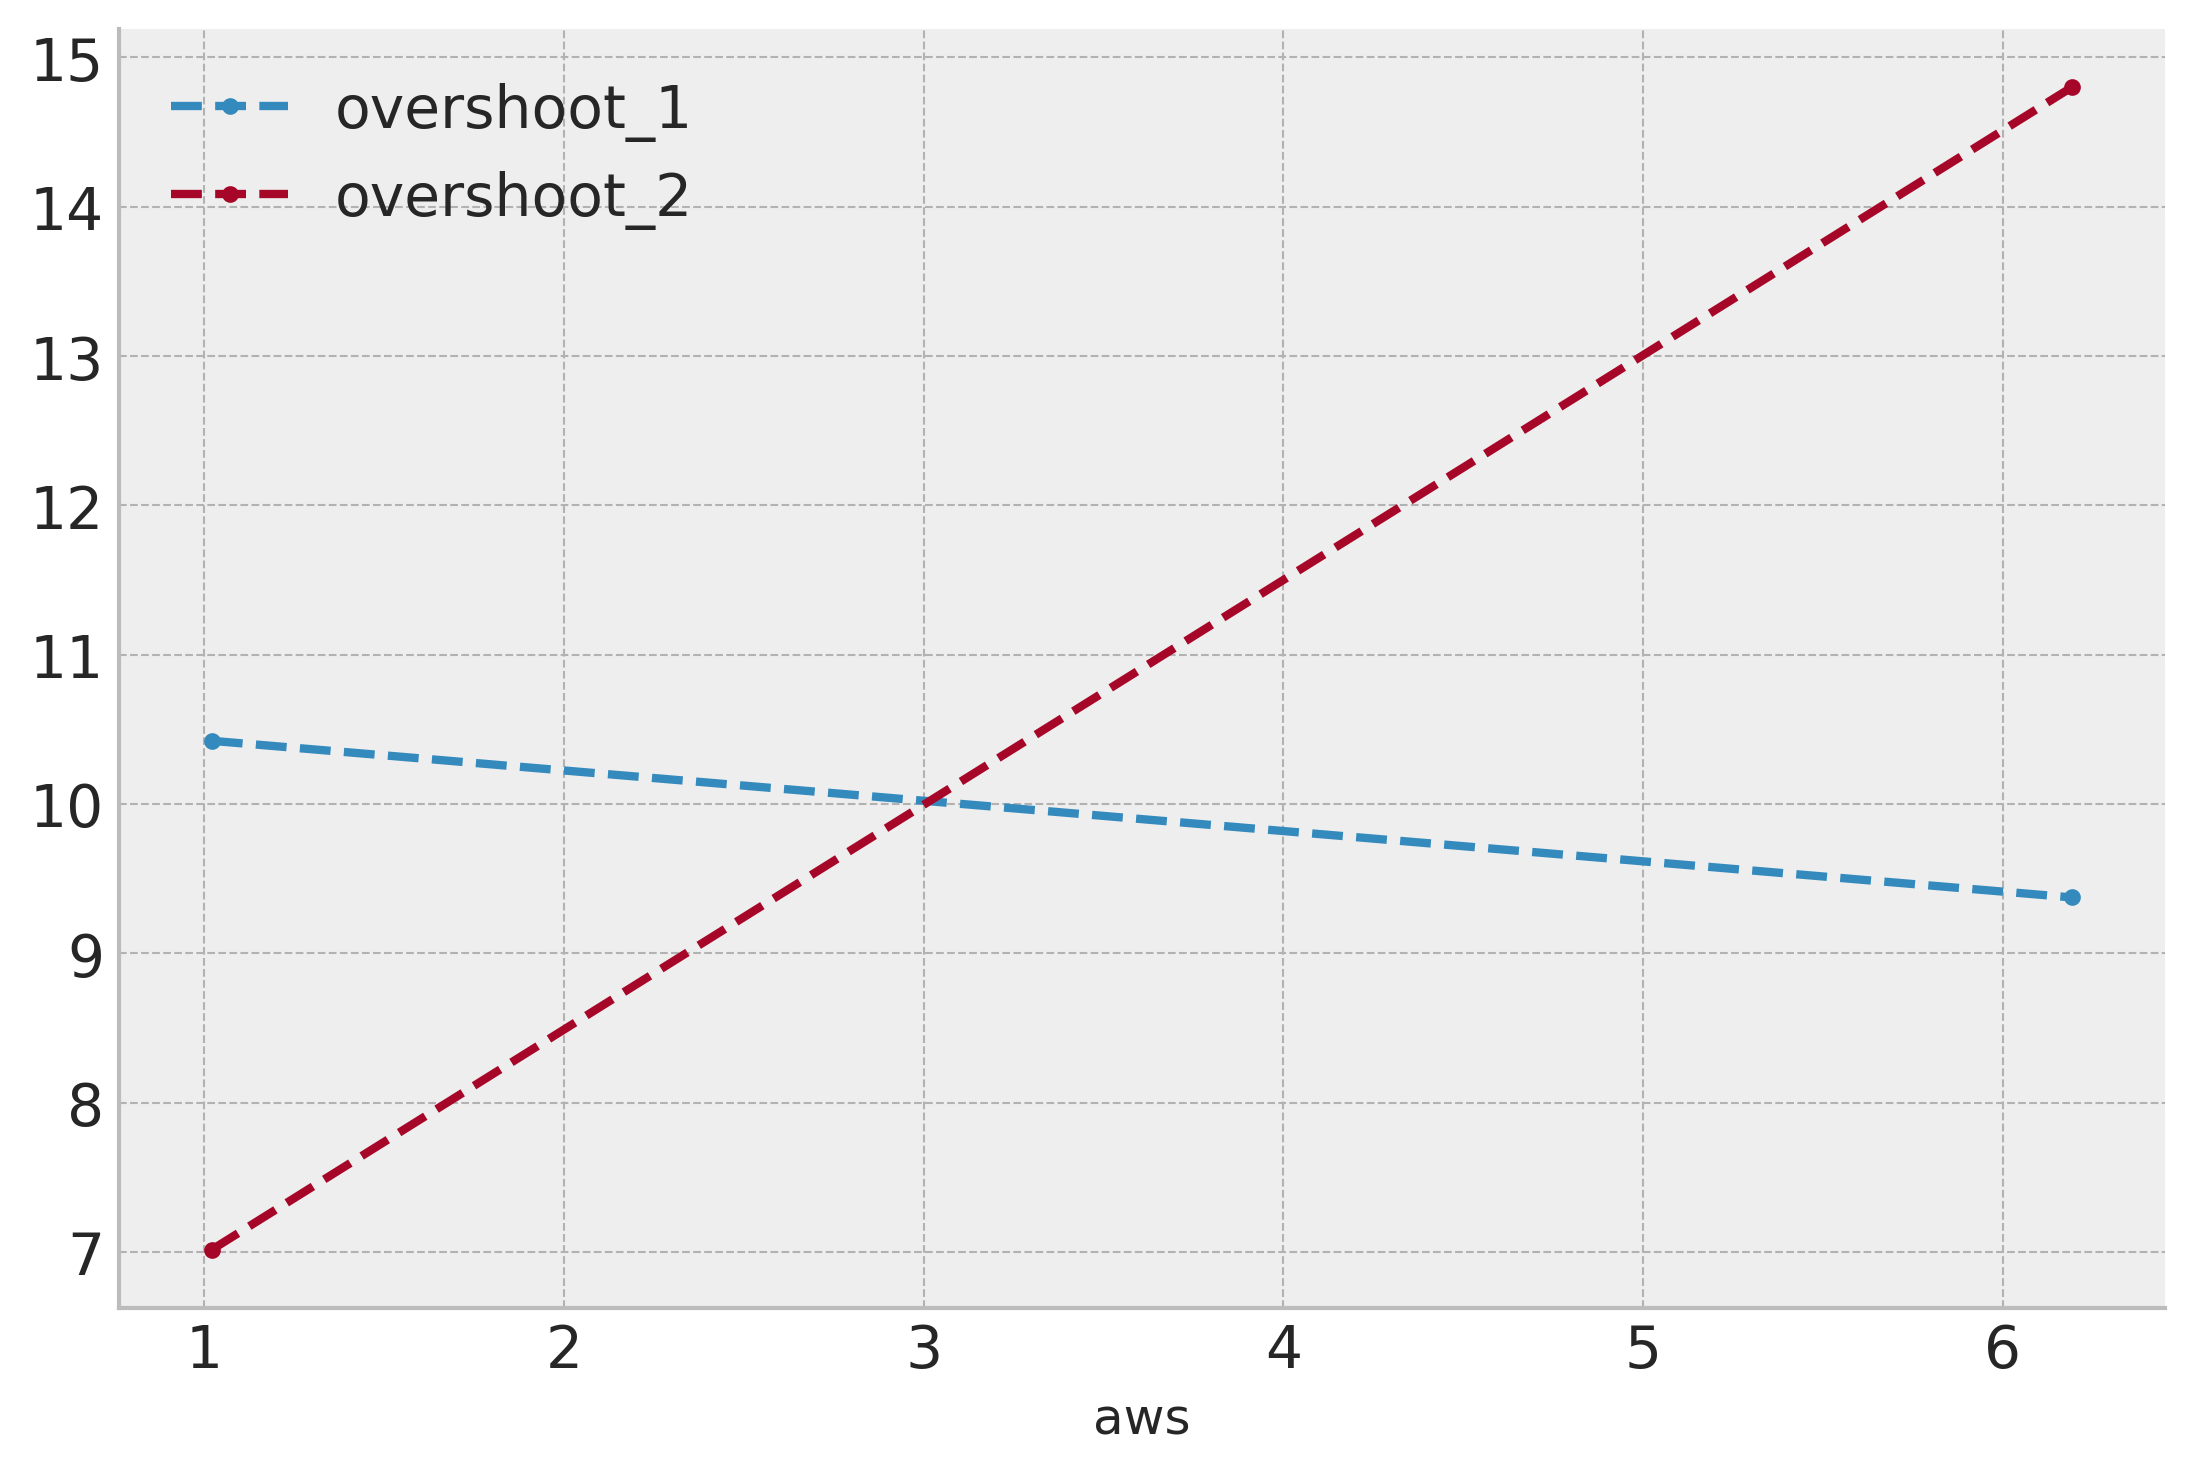

In [35]:
df_selection.sort_values(by='aws').plot(x='aws', y=['overshoot_1','overshoot_2'],style='--.')

<Axes: xlabel='V'>

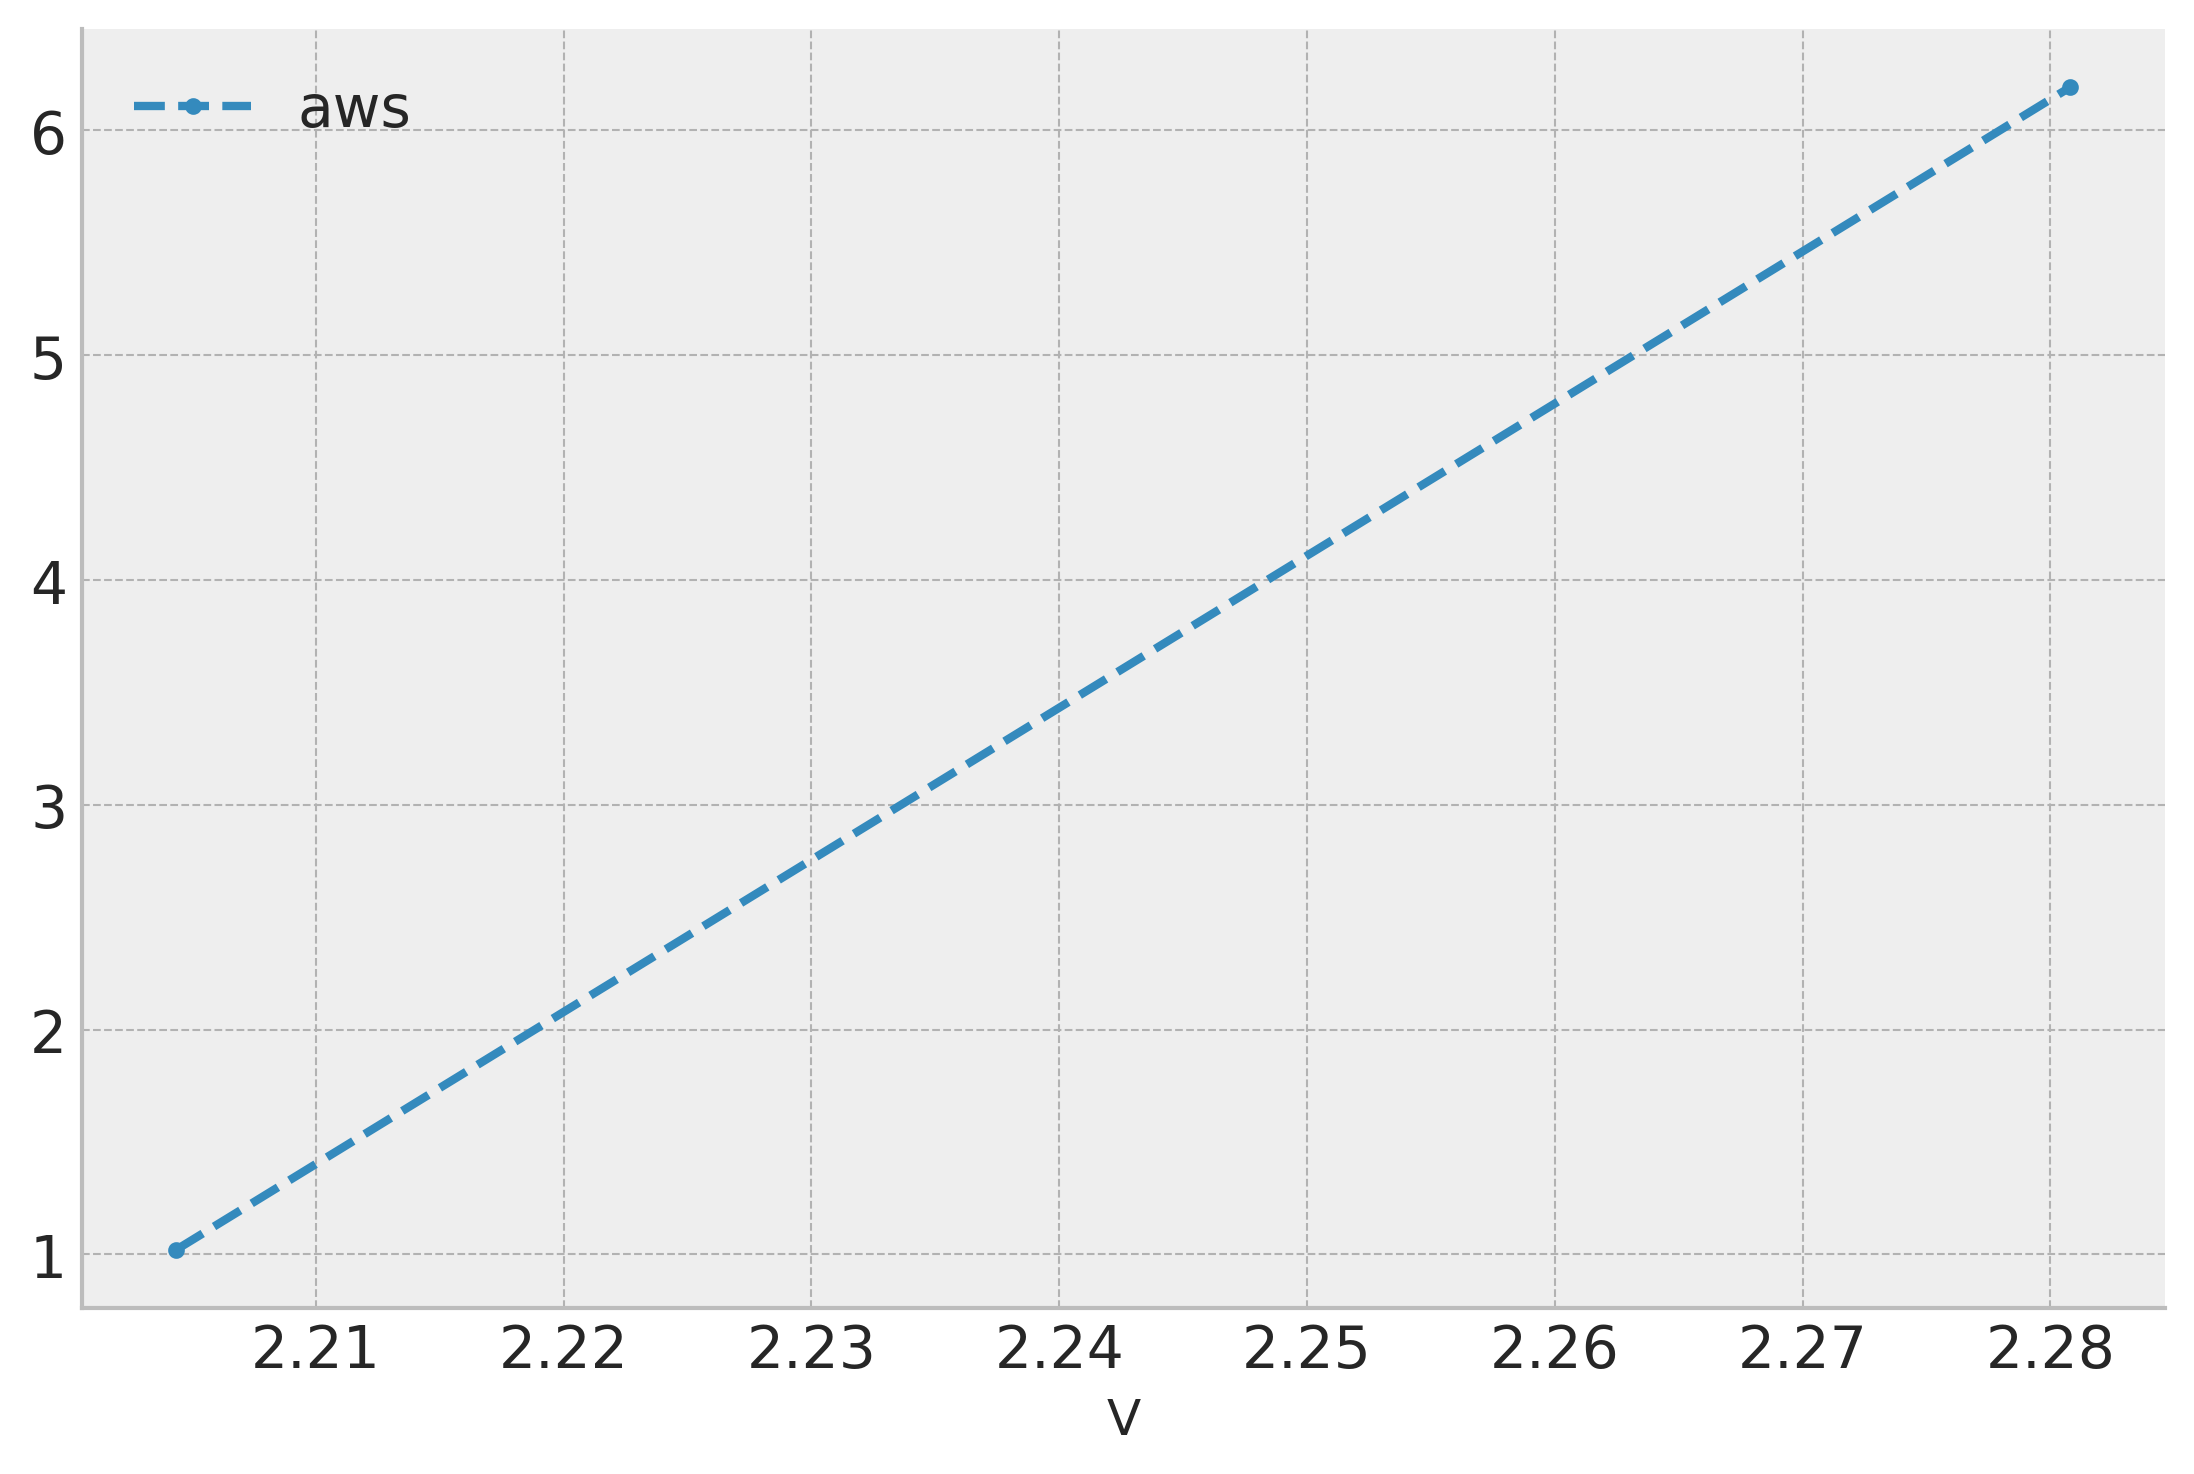

In [36]:
df_selection.sort_values(by='V').plot(x='V', y=['aws'],style='--.')

In [47]:
evaluations_field_data[['V','tws','aws','awa','overshoot_1','overshoot_2','period_1']]

V       tws       aws       awa  overshoot_1  overshoot_2   period_1
0   2.502891  0.697867  1.808642 -0.086549     9.042492    12.336588  10.599841
1   2.280803  4.359494  6.192847 -0.257964     9.373942    14.801140  11.599835
2   2.204374  2.572108  1.021025  3.091711    10.422892     7.015131  10.999864
3   2.151340  2.110859  0.757685 -0.252413     9.463899     6.951007  10.599913
4   1.747200  4.199936  2.699279 -2.635583     7.799348     7.425828  14.799814
5   1.807711  3.765890  2.235229 -2.962611     7.354096     7.087934  12.799811
6   1.247962  1.716245  1.301948  1.664630     4.063690     3.950224  15.399779
7   1.226056  2.002504  1.085730  2.802505     2.582457     5.302353  14.799836
8   1.017498  4.166469  5.015626 -0.348243     3.440164     4.613462  18.999686
9   1.016627  3.385243  4.229845 -0.335307     3.898248     2.076118  17.399756
10  1.619011  4.037081  5.251794 -0.425732     6.058227     7.965538  12.199834
11  1.609564  4.527615  5.909972 -0.142393     7.821738     6.021048  13.999824
12  1.903746  3.935675  5.429320 -0.310489     8.155427     6.630665  11.799791
13  1.925029  3.676812  5.122797 -0.393716     7.901002     8.471785  11.199906
14  0.629512  3.464107  2.952728  2.645015     2.062511     1.196588  45.199291

In [49]:
evaluations_field_data.index = evaluations_field_data.index.astype(int)

In [56]:
table = evaluations_field_data.loc[0:13][['V','tws','aws','awa','overshoot_1','overshoot_2','period_1']].copy()
units['awa'] = 'deg'
table['awa'] = np.rad2deg(smallest_signed_angle(table['awa']))
table = table.applymap(np.format_float_positional, 
                                                          precision=3, 
                                                          unique=False, 
                                                          fractional=False)

units['V']='m/s'
table_units = pd.Series({key:units.get(key,'') for key in table.columns})
table.loc[-1] = table_units
table.sort_index(inplace=True)
table['Test'] = table.index.astype(str)
table['Time'] = evaluations_field_data['date'].dt.strftime('%H:%M')

table.loc[-1,'Test']=None
table.rename(columns={'overshoot_1':r'overshoot 1',
                      'overshoot_2':r'overshoot 2',
                      'period_1':r'period 1'}, inplace=True)

In [57]:
file_path = paper.file_path_with_nb_ref("field_study_test_overshoots.csv",directory='tables')
table[['Test','Time','V','tws','aws','awa','overshoot 1',r'overshoot 2',r'period 1']].to_csv(file_path,index=False, na_rep='')